# Extraction time analysis (new mixcr)

i want to analyze repertoire propetries, and see if they corrolate to extraction time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [2]:
import os
import pandas as pd

# --- File paths ---
mixcr_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

time_threshold = 750

# --- Load metadata ---
meta_df = pd.read_csv(meta_file)
meta_df = meta_df[["Sample_ID", "extraction_time"]]

# --- Load all mixcr files ---
# Columns to keep from MiXCR files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount",
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]

clonotype_dfs = []

for fname in os.listdir(mixcr_dir):
    if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
        sample_prefix = fname.split("_")[0]
        file_path = os.path.join(mixcr_dir, fname)
        
        df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
        df["Sample_ID"] = sample_prefix
        clonotype_dfs.append(df)



In [3]:
# Merge all clonotype data
clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

# Merge with metadata to get extraction time
clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")

# Create 'group' column: fast vs slow
clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# --- Group into fast vs slow ---
# median_time = clonotype_df["extraction_time"].median()
fast_group = clonotype_df[clonotype_df["extraction_time"] <= time_threshold]
slow_group = clonotype_df[clonotype_df["extraction_time"] > time_threshold]

# --- Get unique clonotypes in each group ---
fast_clonotypes = set(fast_group["aaSeqCDR3"].unique())
slow_clonotypes = set(slow_group["aaSeqCDR3"].unique())

# --- Clonotypes that disappeared in the slow group ---
disappeared_clonotypes = fast_clonotypes - slow_clonotypes

# --- Analyze how "public" they were in the fast group ---
public_stats = (
    fast_group[fast_group["aaSeqCDR3"].isin(disappeared_clonotypes)]
    .groupby("aaSeqCDR3")["readCount"]
    .agg(["sum", "mean", "count"])
    .rename(columns={"sum": "total_reads", "mean": "avg_reads", "count": "num_samples"})
    .sort_values("total_reads", ascending=False)
)

# --- Output summary ---
print(f"Total clonotypes in fast group: {len(fast_clonotypes)}")
print(f"Total clonotypes in slow group: {len(slow_clonotypes)}")
print(f"Clonotypes that disappeared in slow group: {len(disappeared_clonotypes)}")
print(public_stats.head(10))


Total clonotypes in fast group: 8991978
Total clonotypes in slow group: 1852705
Clonotypes that disappeared in slow group: 8469359
                    total_reads      avg_reads  num_samples
aaSeqCDR3                                                  
CASSSVGSGRIVTNEQFF     906275.0  226568.750000            4
CASSPLAGAADEQFF        847424.0  141237.333333            6
CASSLAYWGGEQETQYF      715096.0  238365.333333            3
CASSQGAGARGAYNEQFF     598550.0  299275.000000            2
CASSASEFTGDIQYF        558397.0  279198.500000            2
CASSLGQQGDEQFF         459736.0  114934.000000            4
CASSQDRTGPRYF          437574.0  218787.000000            2
CASSADRLGYAMAQYF       389754.0   55679.142857            7
CASSDKTGERADTQYF       376723.0  188361.500000            2
CASSLGGFVTSGPYEQYF     373313.0  186656.500000            2


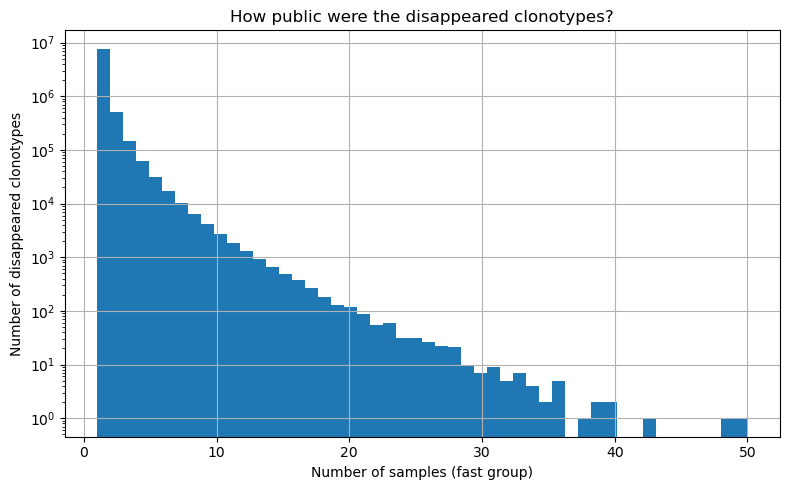

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
public_stats["num_samples"].plot.hist(bins=50, log=True)
plt.xlabel("Number of samples (fast group)")
plt.ylabel("Number of disappeared clonotypes")
plt.title("How public were the disappeared clonotypes?")
plt.grid(True)
plt.tight_layout()
plt.show()


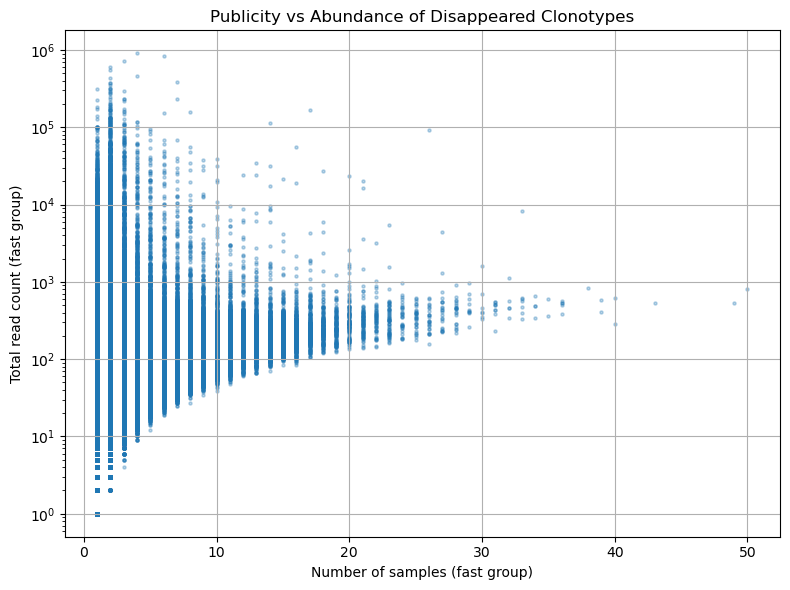

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(
    public_stats["num_samples"], 
    public_stats["total_reads"], 
    alpha=0.3, s=5
)
plt.xlabel("Number of samples (fast group)")
plt.ylabel("Total read count (fast group)")
plt.title("Publicity vs Abundance of Disappeared Clonotypes")
plt.xscale("linear")
plt.yscale("log")  # often helpful due to long tail
plt.grid(True)
plt.tight_layout()
plt.show()


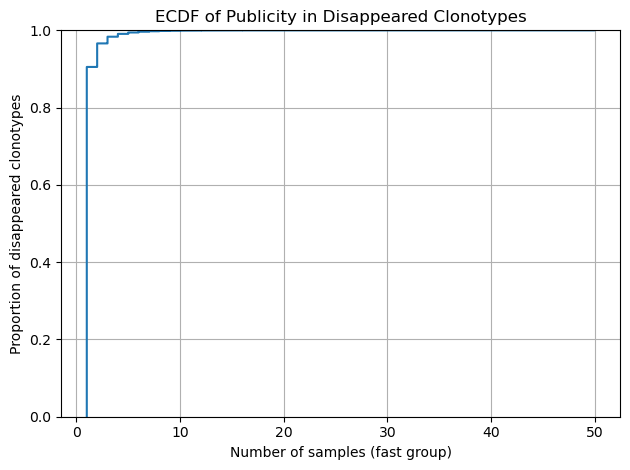

In [6]:
sns.ecdfplot(public_stats["num_samples"])
plt.xlabel("Number of samples (fast group)")
plt.ylabel("Proportion of disappeared clonotypes")
plt.title("ECDF of Publicity in Disappeared Clonotypes")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
num_fast_samples = fast_group["Sample_ID"].nunique()
num_slow_samples = slow_group["Sample_ID"].nunique()

print(f"Number of samples in fast group: {num_fast_samples}")
print(f"Number of samples in slow group: {num_slow_samples}")

# --- Count clonotypes per sample ---
fast_clonotypes_per_sample = (
    fast_group.groupby("Sample_ID")["aaSeqCDR3"].nunique()
)
slow_clonotypes_per_sample = (
    slow_group.groupby("Sample_ID")["aaSeqCDR3"].nunique()
)

# --- Stats ---
avg_fast = fast_clonotypes_per_sample.mean()
med_fast = fast_clonotypes_per_sample.median()

avg_slow = slow_clonotypes_per_sample.mean()
med_slow = slow_clonotypes_per_sample.median()

# --- Print results ---
num_fast_samples = fast_group["Sample_ID"].nunique()
num_slow_samples = slow_group["Sample_ID"].nunique()

print(f"Number of samples in fast group: {num_fast_samples}")
print(f"Average clonotypes per fast sample: {avg_fast:.1f}")
print(f"Median clonotypes per fast sample: {med_fast:.1f}\n")

print(f"Number of samples in slow group: {num_slow_samples}")
print(f"Average clonotypes per slow sample: {avg_slow:.1f}")
print(f"Median clonotypes per slow sample: {med_slow:.1f}")


Number of samples in fast group: 153
Number of samples in slow group: 58
Number of samples in fast group: 153
Average clonotypes per fast sample: 82060.1
Median clonotypes per fast sample: 75004.0

Number of samples in slow group: 58
Average clonotypes per slow sample: 37566.7
Median clonotypes per slow sample: 32296.5


In [8]:
# --- Presence matrix: clonotype vs sample ---
fast_presence = (
    fast_group.groupby(["aaSeqCDR3", "Sample_ID"])
    .size()
    .unstack(fill_value=0)
    .astype(bool)
)

slow_presence = (
    slow_group.groupby(["aaSeqCDR3", "Sample_ID"])
    .size()
    .unstack(fill_value=0)
    .astype(bool)
)

# --- Count in how many samples each clonotype appears ---
fast_counts = fast_presence.sum(axis=1)
slow_counts = slow_presence.sum(axis=1)

# --- Merge into a DataFrame for comparison ---
clonotype_presence_comparison = pd.DataFrame({
    "samples_in_fast": fast_counts,
    "samples_in_slow": slow_counts.reindex(fast_counts.index).fillna(0)
})

# --- Filter clonotypes that are public in fast but missing in slow ---
consistently_disappeared = clonotype_presence_comparison[
    (clonotype_presence_comparison["samples_in_fast"] >= 3) &  # adjustable threshold
    (clonotype_presence_comparison["samples_in_slow"] == 0)
]

print(f"Clonotypes consistently missing in slow group: {len(consistently_disappeared)}")
print(consistently_disappeared.sort_values("samples_in_fast", ascending=False).head(10))


Clonotypes consistently missing in slow group: 277870
                samples_in_fast  samples_in_slow
aaSeqCDR3                                       
CASSLGAGTEAFF                44              0.0
CASSLGGGVYEQYF               41              0.0
CASSTRDTQYF                  36              0.0
CASSSGNYEQYF                 35              0.0
CASSKGETQYF                  33              0.0
CASSLGTSYGYTF                33              0.0
CASSLGPGNYGYTF               33              0.0
CASSLGLHNEQFF                32              0.0
CASSLTLTDTQYF                32              0.0
CASSPGGPGELFF                32              0.0


In [9]:
# Reuse fast_group and filter by disappeared clonotypes
disappeared_reads = (
    fast_group[fast_group["aaSeqCDR3"].isin(consistently_disappeared.index)]
    .groupby("aaSeqCDR3")["readCount"]
    .agg(total_reads="sum", avg_reads="mean")
)

# Merge with `consistently_disappeared`
enriched_disappeared = consistently_disappeared.merge(disappeared_reads, left_index=True, right_index=True)


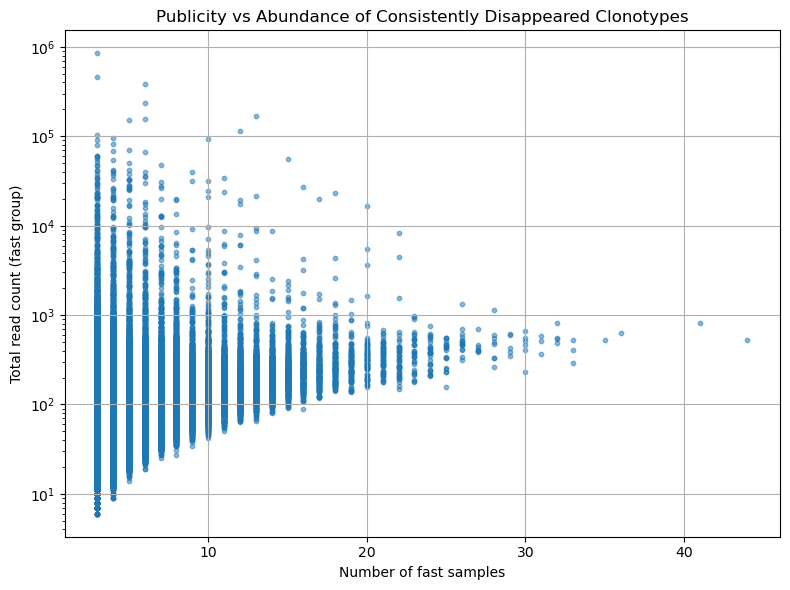

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(
    enriched_disappeared["samples_in_fast"], 
    enriched_disappeared["total_reads"],
    alpha=0.5, s=10
)
plt.xlabel("Number of fast samples")
plt.ylabel("Total read count (fast group)")
plt.title("Publicity vs Abundance of Consistently Disappeared Clonotypes")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()


## General groups EDA

Lets analyze the groups. 

In [57]:
# Step 1: Subset by group
fast_df = clonotype_df[clonotype_df["group"] == "fast"].copy()
slow_df = clonotype_df[clonotype_df["group"] == "slow"].copy()

we will start by comparing v/j usage across both groups.

In [ ]:
# --- Vectorized helper to extract and clean gene names ---
def extract_clean_genes(df, col):
    exploded = df[[col]].dropna().copy()
    exploded[col] = exploded[col].str.split(",")
    exploded = exploded.explode(col)
    exploded[col] = exploded[col].str.split("*").str[0]
    return exploded[col]

# Convert to sorted DataFrames for plotting
def counter_to_df(counter, label):
    df = pd.DataFrame(counter.items(), columns=[label, "count"])
    return df.sort_values("count", ascending=False)

def plot_gene_usage(df, gene_type, color, group_label, top_n=100):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df.head(top_n), x=gene_type, y="count", color=color)
    plt.title(f"Top {top_n} {gene_type} Usage in {group_label}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Count")
    plt.xlabel(f"{gene_type} Name")
    plt.tight_layout()
    plt.show()

def prepare_comparison_df(counts1, counts2, label1, label2, gene_type, top_n=50):
    # All unique gene names
    all_genes = set(counts1.keys()).union(set(counts2.keys()))
    
    # Normalize each counter
    total1 = sum(counts1.values())
    total2 = sum(counts2.values())

    data = []
    for gene in all_genes:
        norm1 = counts1.get(gene, 0) / total1
        norm2 = counts2.get(gene, 0) / total2
        data.append((gene, norm1, norm2))
    
    df = pd.DataFrame(data, columns=[gene_type, label1, label2])
    
    # Keep top N genes based on total usage
    df["combined"] = df[label1] + df[label2]
    df = df.sort_values("combined", ascending=False).head(top_n).drop(columns="combined")
    
    return df.set_index(gene_type)

def plot_comparison(df, gene_type, title="Gene Usage: Fast vs Slow TCRs (Normalized)"):
    ax = df.plot(kind="bar", figsize=(12, 5))
    plt.title(f"{gene_type} {title}")
    plt.ylabel("Proportion of Total")
    plt.xlabel(f"{gene_type} Gene")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


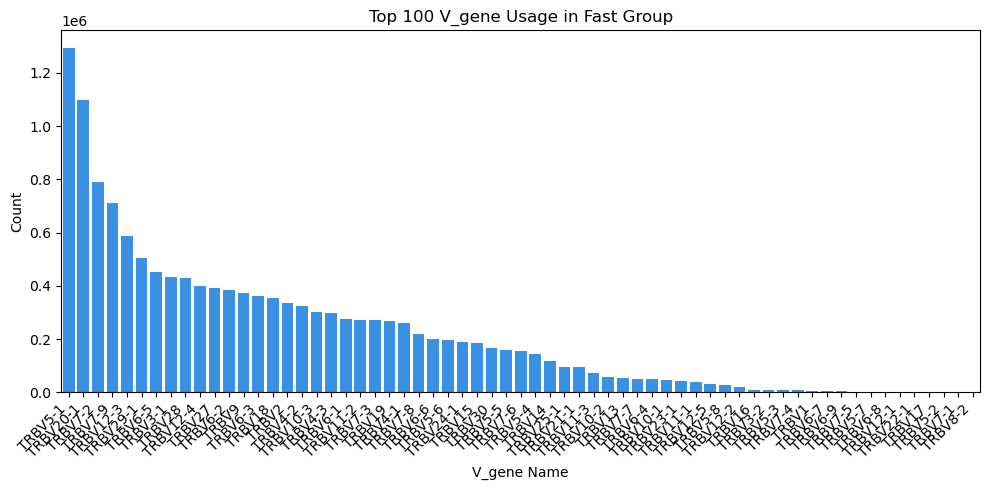

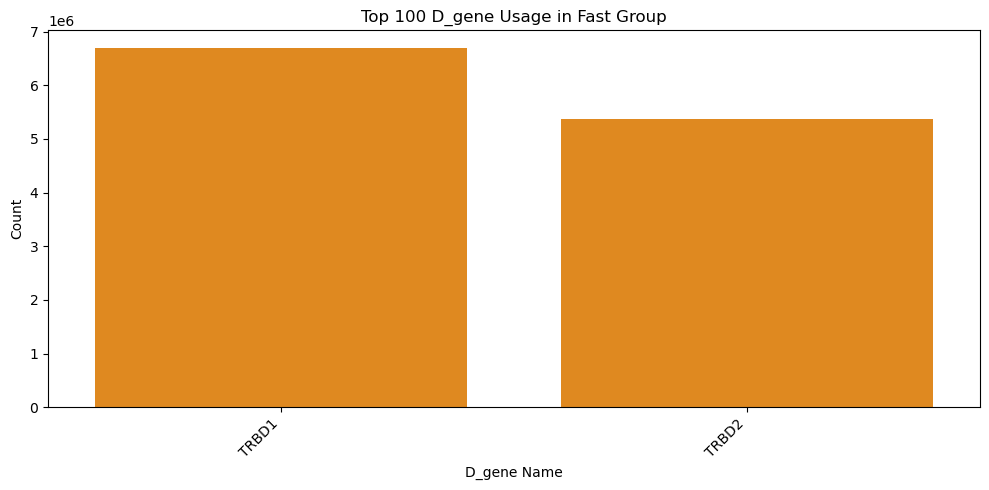

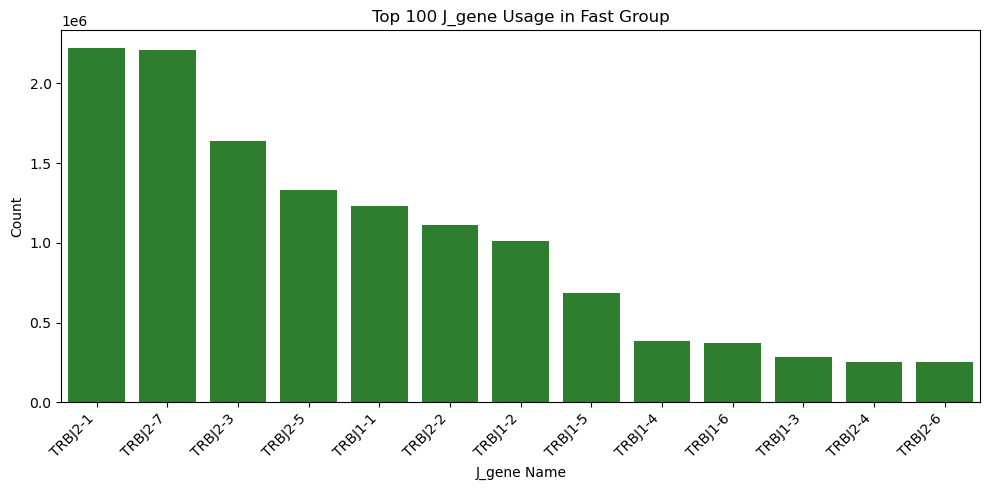

In [60]:
# Extract gene names
fast_v = extract_clean_genes(fast_df, "allVHitsWithScore")
fast_d = extract_clean_genes(fast_df, "allDHitsWithScore")
fast_j = extract_clean_genes(fast_df, "allJHitsWithScore")

# Count
fast_v_counts = fast_v.value_counts().to_dict()
fast_d_counts = fast_d.value_counts().to_dict()
fast_j_counts = fast_j.value_counts().to_dict()

# Convert to DataFrames
fast_v_df = counter_to_df(fast_v_counts, "V_gene")
fast_d_df = counter_to_df(fast_d_counts, "D_gene")
fast_j_df = counter_to_df(fast_j_counts, "J_gene")

# Plot
plot_gene_usage(fast_v_df, "V_gene", "dodgerblue", "Fast Group")
plot_gene_usage(fast_d_df, "D_gene", "darkorange", "Fast Group")
plot_gene_usage(fast_j_df, "J_gene", "forestgreen", "Fast Group")


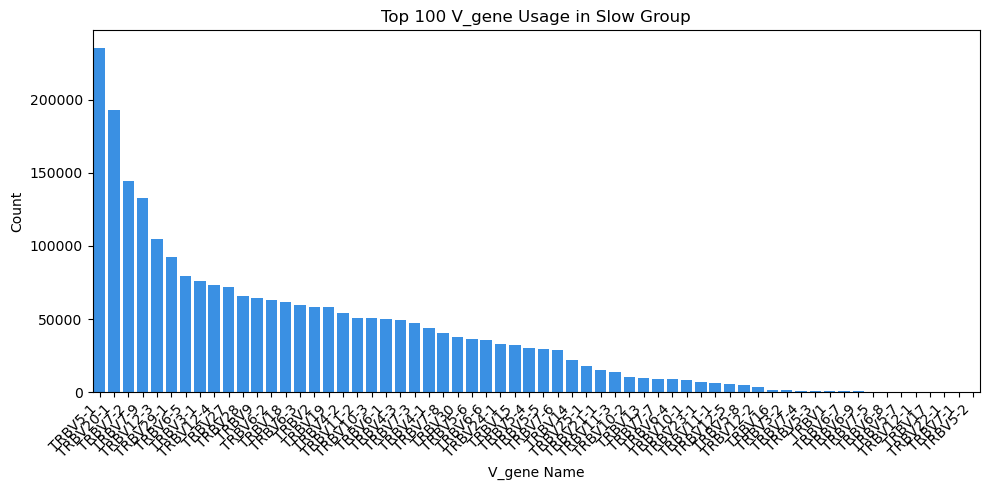

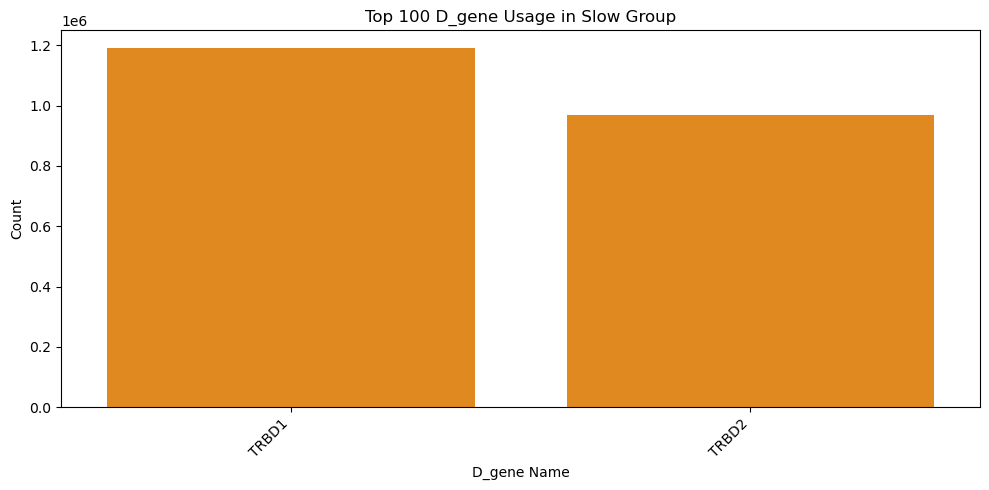

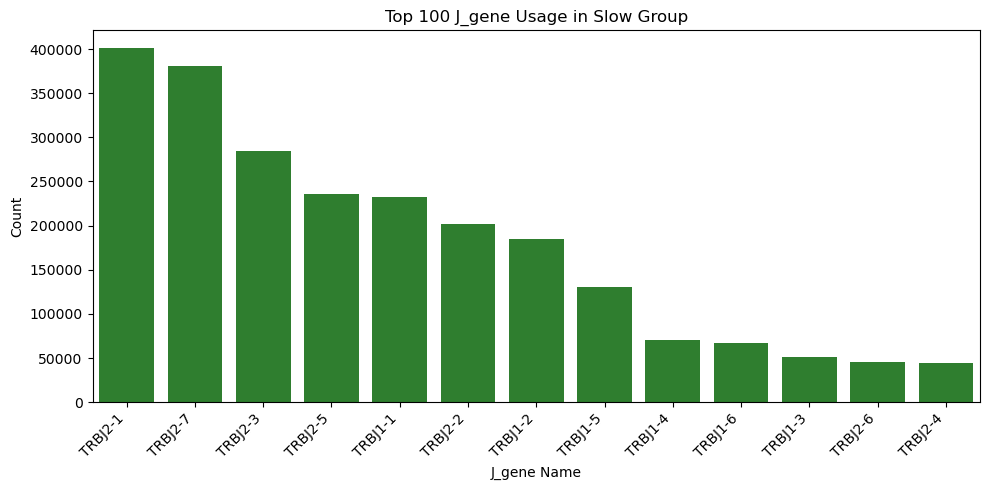

In [58]:
# Extract gene names
slow_v = extract_clean_genes(slow_df, "allVHitsWithScore")
slow_d = extract_clean_genes(slow_df, "allDHitsWithScore")
slow_j = extract_clean_genes(slow_df, "allJHitsWithScore")

# Count
slow_v_counts = slow_v.value_counts().to_dict()
slow_d_counts = slow_d.value_counts().to_dict()
slow_j_counts = slow_j.value_counts().to_dict()

# Convert to DataFrames
slow_v_df = counter_to_df(slow_v_counts, "V_gene")
slow_d_df = counter_to_df(slow_d_counts, "D_gene")
slow_j_df = counter_to_df(slow_j_counts, "J_gene")

# Plot
plot_gene_usage(slow_v_df, "V_gene", "dodgerblue", "Slow Group")
plot_gene_usage(slow_d_df, "D_gene", "darkorange", "Slow Group")
plot_gene_usage(slow_j_df, "J_gene", "forestgreen", "Slow Group")


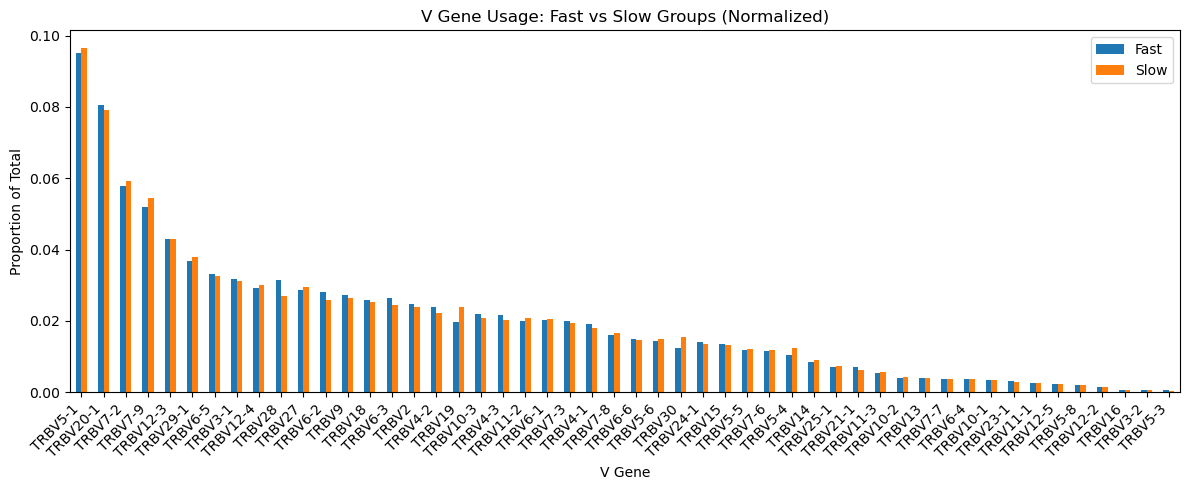

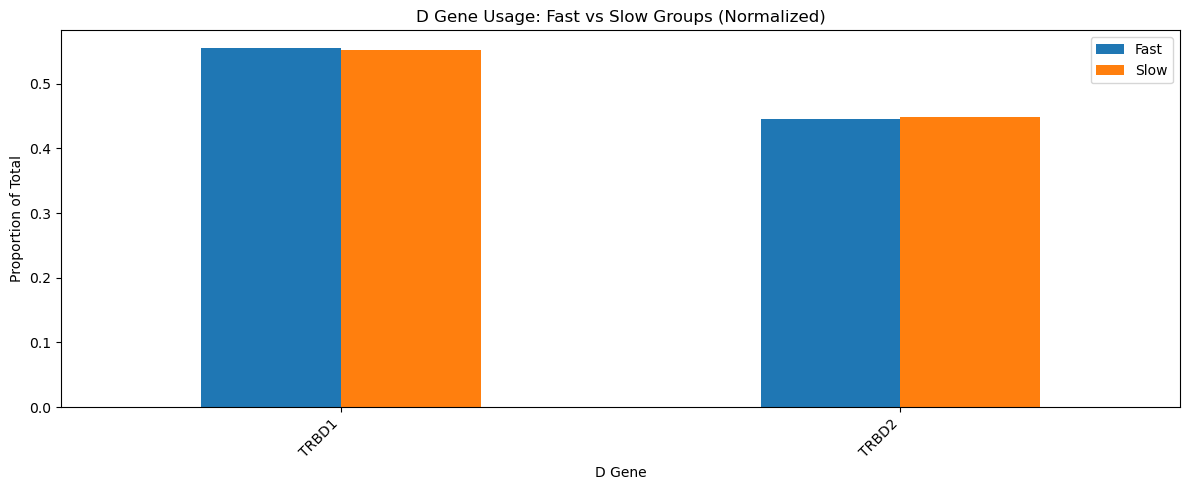

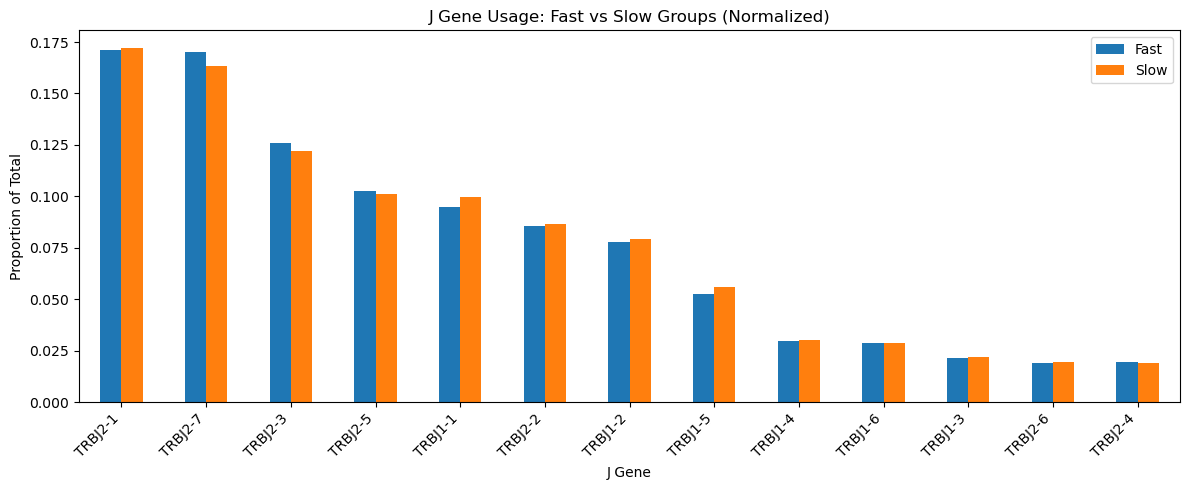

In [61]:
# Prepare comparison DataFrames
v_comp_fastslow = prepare_comparison_df(fast_v_counts, slow_v_counts, "Fast", "Slow", "V_gene")
d_comp_fastslow = prepare_comparison_df(fast_d_counts, slow_d_counts, "Fast", "Slow", "D_gene")
j_comp_fastslow = prepare_comparison_df(fast_j_counts, slow_j_counts, "Fast", "Slow", "J_gene")

# Plot comparisons
plot_comparison(v_comp_fastslow, "V", title="Gene Usage: Fast vs Slow Groups (Normalized)")
plot_comparison(d_comp_fastslow, "D", title="Gene Usage: Fast vs Slow Groups (Normalized)")
plot_comparison(j_comp_fastslow, "J", title="Gene Usage: Fast vs Slow Groups (Normalized)")


## Survivors with shared Nucleotide Seq

Among TCRs that share the same amino acid CDR3 (aaSeqCDR3) between fast and slow samples, how many:

- Have the same nucleotide sequence (nSeqCDR3)?

- Have different nucleotide sequences?

In [11]:
clonotype_df.columns

Index(['readCount', 'allVHitsWithScore', 'allDHitsWithScore',
       'allJHitsWithScore', 'nSeqCDR3', 'aaSeqCDR3', 'Sample_ID',
       'extraction_time', 'group'],
      dtype='object')

In [12]:
from collections import defaultdict

# Step 1: Filter only required columns
aa_nt_df = clonotype_df[["aaSeqCDR3", "nSeqCDR3", "group"]].dropna()

# Step 2: For each group, collect nucleotide sequences per AA
grouped_nt = defaultdict(lambda: {"fast": set(), "slow": set()})

for _, row in aa_nt_df.iterrows():
    aa = row["aaSeqCDR3"]
    nt = row["nSeqCDR3"]
    grp = row["group"]
    grouped_nt[aa][grp].add(nt)

# Step 3: Classify each AA CDR3
same_nt = []
diff_nt = []

for aa_seq, seqs in grouped_nt.items():
    if seqs["fast"] and seqs["slow"]:  # Appears in both groups
        if seqs["fast"] == seqs["slow"]:
            same_nt.append(aa_seq)
        else:
            diff_nt.append(aa_seq)

# Step 4: Report
print(f"Total shared AA sequences (fast & slow): {len(same_nt) + len(diff_nt)}")
print(f"Same nucleotide sequences: {len(same_nt)}")
print(f"Different nucleotide sequences: {len(diff_nt)}")
print(f"Fraction with different NTs: {len(diff_nt) / (len(same_nt) + len(diff_nt)):.2%}")


Total shared AA sequences (fast & slow): 539849
Same nucleotide sequences: 6980
Different nucleotide sequences: 532869
Fraction with different NTs: 98.71%


First lets assess Survivors group clonality.

In [55]:
survivors_set = set(same_nt + diff_nt)
survivor_df_clonality = clonotype_df[clonotype_df["aaSeqCDR3"].isin(survivors_set)].copy()
clonotype_counts = (
    survivor_df_clonality.groupby("nSeqCDR3")["readCount"]
    .sum()
    .sort_values(ascending=False)
)

In [62]:
# Aggregate total read count per nucleotide clonotype
top_clones = (
    survivor_df_clonality.groupby(["nSeqCDR3", "aaSeqCDR3"])["readCount"]
    .sum()
    .reset_index()
    .sort_values("readCount", ascending=False)
)

# Calculate clone fraction
total_reads = top_clones["readCount"].sum()
top_clones["cloneFraction"] = top_clones["readCount"] / total_reads

# Show top N clones
top_10_clones = top_clones.head(10)
print(top_10_clones.to_string(index=False))

                                              nSeqCDR3          aaSeqCDR3  readCount  cloneFraction
                  TGTGCCAGCAGCACTTTAAACAATGAGCAGTTCTTC       CASSTLNNEQFF   714285.0       0.006579
                  TGTGCCAGCAGTTACGGAGGGAATGAGCAGTTCTTC       CASSYGGNEQFF   712368.0       0.006561
            TGTGCCAGCAGCTTAGGTGGGGCCACAGATACGCAGTATTTT     CASSLGGATDTQYF   682542.0       0.006287
            TGTGCCAGCAGTTTAGCCGGACGGACCGGGGAGCTGTTTTTT     CASSLAGRTGELFF   626564.0       0.005771
         TGTGCCAGCAGTTTATCTAGCGGGGGGTCCTACGAGCAGTACTTC    CASSLSSGGSYEQYF   494398.0       0.004554
TGTGCCAGCAGAGCGGGACTAGCGGGAGGGCCCGCCACCGGGGAGCTGTTTTTT CASRAGLAGGPATGELFF   490163.0       0.004515
         TGTGCCAGCAGTCCGGACTCAGGGGGGACAGATACGCAGTATTTT    CASSPDSGGTDTQYF   471527.0       0.004343
                     TGTGCCAGCAGCCCTTACTACGAGCAGTACTTC        CASSPYYEQYF   465576.0       0.004288
            TGCGCCAGCAGCATAGGACAGGGGTCAGATACGCAGTATTTT     CASSIGQGSDTQYF   455584.0       0.004196


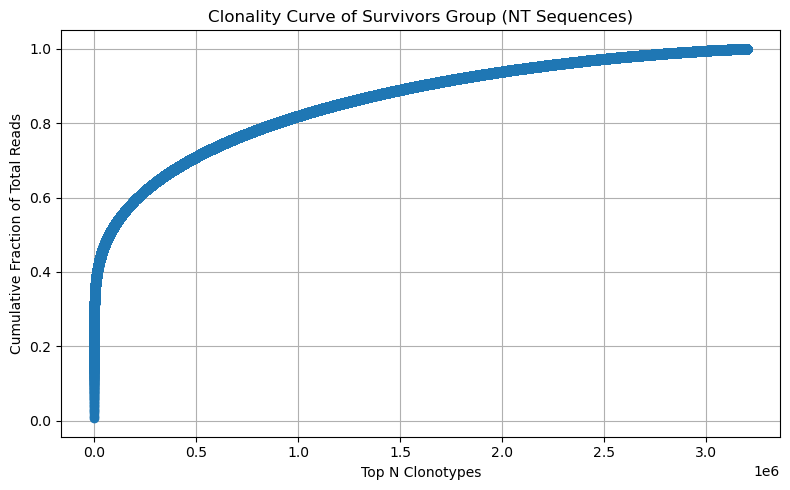

In [56]:
# Normalize counts
cumulative_counts = clonotype_counts.cumsum()
total_reads = clonotype_counts.sum()
fraction_reads = cumulative_counts / total_reads
x = np.arange(1, len(fraction_reads) + 1)

plt.figure(figsize=(8, 5))
plt.plot(x, fraction_reads, marker='o', linestyle='-')
plt.xlabel("Top N Clonotypes")
plt.ylabel("Cumulative Fraction of Total Reads")
plt.title("Clonality Curve of Survivors Group (NT Sequences)")
plt.grid(True)
plt.tight_layout()
plt.show()

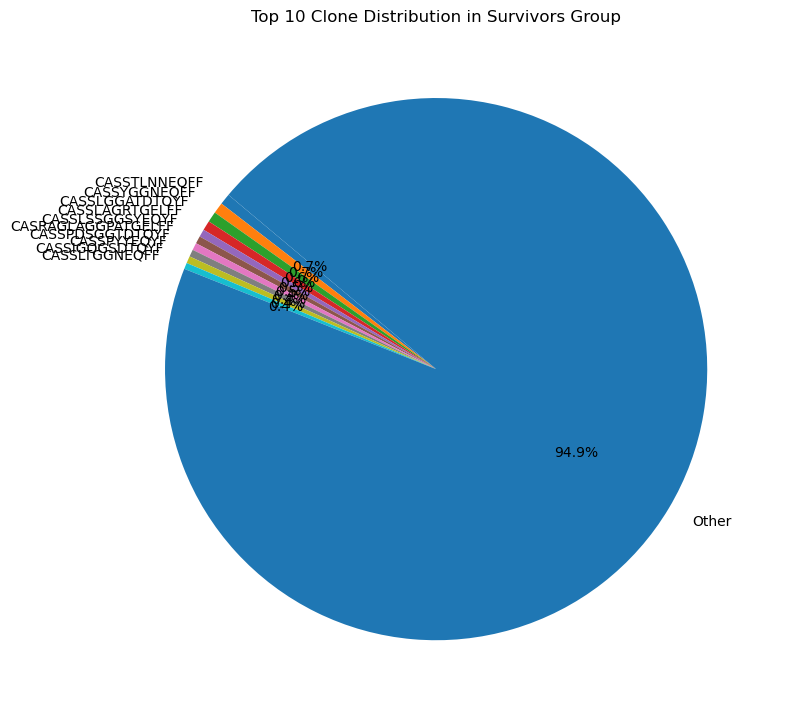

In [64]:
top_n = 10
top = top_clones.head(top_n)
other_fraction = 1 - top["cloneFraction"].sum()

labels = list(top["aaSeqCDR3"]) + ["Other"]
sizes = list(top["cloneFraction"]) + [other_fraction]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct="%.1f%%", startangle=140)
plt.title(f"Top {top_n} Clone Distribution in Survivors Group")
plt.tight_layout()
plt.show()


### Common TCRs - Common structore?

In [13]:
# Get sets of common (shared) vs private (group-specific) TCRs
common_tcrs = set(diff_nt)  # appear in both groups, with different NTs
all_aas = set(clonotype_df["aaSeqCDR3"].dropna())
private_tcrs = all_aas - set(same_nt) - set(diff_nt)  # appear in only one group


#### Logo

Lets padd sequences for a uniform length:

In [14]:
from Bio import SeqIO

def pad_sequences(seq_list, pad_char='-'):
    max_len = max(len(s) for s in seq_list)
    padded = [s.ljust(max_len, pad_char) for s in seq_list]
    
    # Sanity check: confirm all lengths are equal
    lengths = [len(seq) for seq in padded]
    if len(set(lengths)) > 1:
        raise ValueError("Padding failed — sequences are still of different lengths.")
    
    return padded

# Apply padding
# Combine both sets to get shared max length
all_seqs = list(common_tcrs) + list(private_tcrs)
shared_max_len = max(len(s) for s in all_seqs)

# Pad both sets to same length
common_aligned = pad_sequences(list(common_tcrs), pad_char='-',)
private_aligned = pad_sequences(list(private_tcrs), pad_char='-')

dataframe:
rows = poisition
columns : 20 amino acids
Each cell is the count of how many times that AA appeared at that position.

In [15]:
import logomaker

def get_logo_df(seq_list):
    # Convert list of aligned sequences to DataFrame
    counts_mat = logomaker.alignment_to_matrix(seq_list, to_type='counts')
    return counts_mat

common_df = get_logo_df(common_aligned)
private_df = get_logo_df(private_aligned)

Matplotlib is building the font cache; this may take a moment.


<Figure size 1200x300 with 0 Axes>

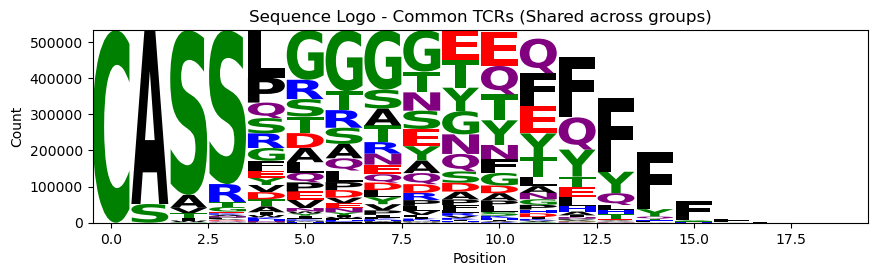

<Figure size 1200x300 with 0 Axes>

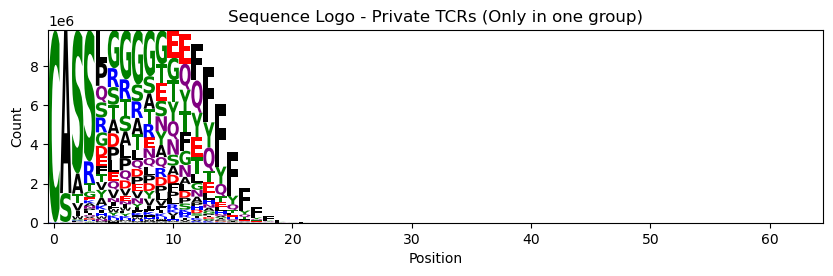

In [16]:
# Plot common TCR logo
plt.figure(figsize=(12, 3))
logomaker.Logo(common_df, color_scheme='chemistry')
plt.title("Sequence Logo - Common TCRs (Shared across groups)")
plt.xlabel("Position")
plt.ylabel("Count")
plt.show()

# Plot private TCR logo
plt.figure(figsize=(12, 3))
logomaker.Logo(private_df, color_scheme='chemistry')
plt.title("Sequence Logo - Private TCRs (Only in one group)")
plt.xlabel("Position")
plt.ylabel("Count")
plt.show()

<Figure size 1200x300 with 0 Axes>

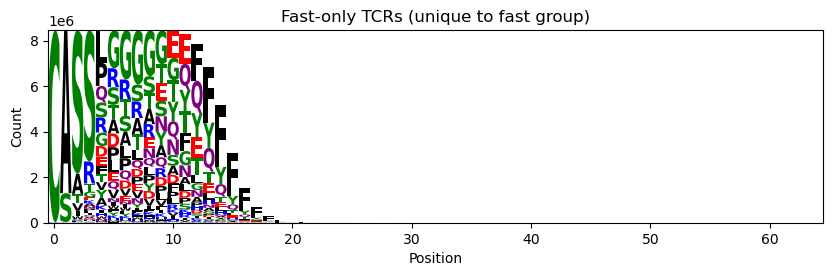

<Figure size 1200x300 with 0 Axes>

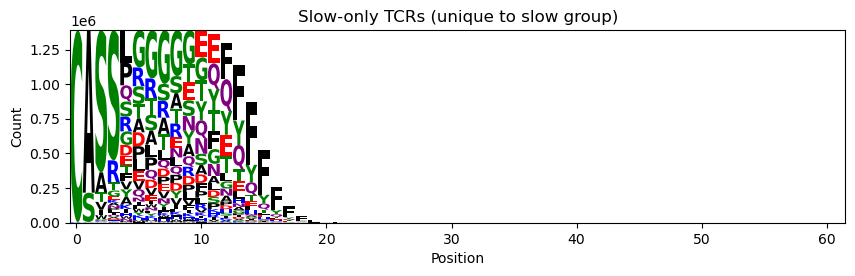

In [17]:
# Ensure required columns exist
assert {"aaSeqCDR3", "group"}.issubset(clonotype_df.columns)

# Create group-wise sets
fast_seqs = set(clonotype_df[clonotype_df["group"] == "fast"]["aaSeqCDR3"].dropna())
slow_seqs = set(clonotype_df[clonotype_df["group"] == "slow"]["aaSeqCDR3"].dropna())

# Shared between groups with different NTs (already from your earlier logic)
shared_seqs = set(diff_nt)

# Private sequences
fast_only = fast_seqs - slow_seqs
slow_only = slow_seqs - fast_seqs

## Padding (using previously established function)
# Combine all to determine max length
all_seqs = list(shared_seqs | fast_only | slow_only)
max_len = max(len(s) for s in all_seqs)

# Pad each group using your function
fast_aligned = pad_sequences(list(fast_only), pad_char='-')
slow_aligned = pad_sequences(list(slow_only), pad_char='-')

def plot_logo(seq_list, title):
    df = logomaker.alignment_to_matrix(seq_list, to_type='counts')
    plt.figure(figsize=(12, 3))
    logomaker.Logo(df, color_scheme='chemistry')
    plt.title(title)
    plt.xlabel("Position")
    plt.ylabel("Count")
    plt.show()

# Plot each group
plot_logo(fast_aligned, "Fast-only TCRs (unique to fast group)")
plot_logo(slow_aligned, "Slow-only TCRs (unique to slow group)")

are the 2 logos (only fast/only slow) identical?

In [18]:
# Choose a reasonable cutoff
cutoff_len = 25

# Truncate all padded sequences
fast_trunc = [seq[:cutoff_len] for seq in fast_aligned]
slow_trunc = [seq[:cutoff_len] for seq in slow_aligned]

fast_df = logomaker.alignment_to_matrix(fast_trunc, to_type='counts')
slow_df = logomaker.alignment_to_matrix(slow_trunc, to_type='counts')

fast_freq = fast_df.div(fast_df.sum(axis=1), axis=0).fillna(0)
slow_freq = slow_df.div(slow_df.sum(axis=1), axis=0).fillna(0)

corrs = fast_freq.corrwith(slow_freq, axis=1)
print(corrs.describe())



count    25.000000
mean      0.999836
std       0.000185
min       0.999449
25%       0.999827
50%       0.999910
75%       0.999972
max       1.000000
dtype: float64


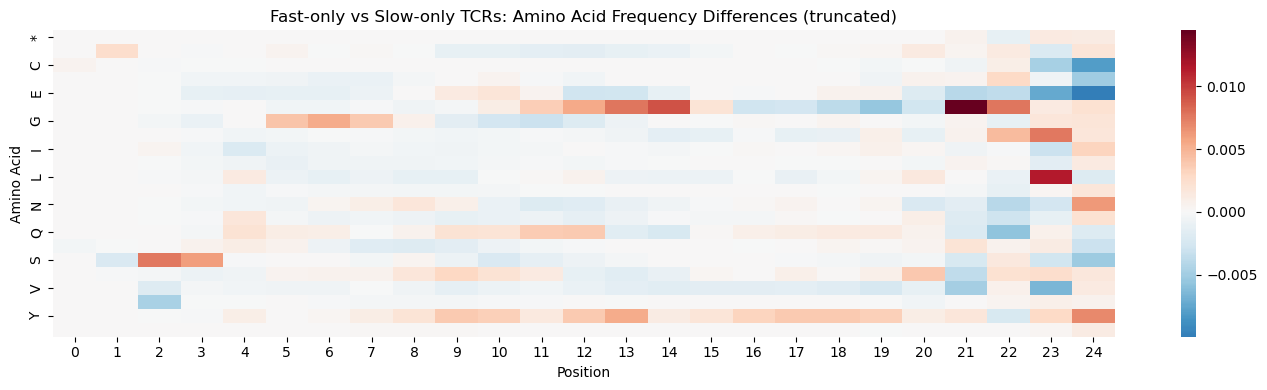

In [19]:
diff_matrix = fast_freq - slow_freq

# Plot again
plt.figure(figsize=(14, 4))
sns.heatmap(diff_matrix.T, cmap="RdBu_r", center=0)
plt.title("Fast-only vs Slow-only TCRs: Amino Acid Frequency Differences (truncated)")
plt.xlabel("Position")
plt.ylabel("Amino Acid")
plt.tight_layout()
plt.show()

#### tcrdist3

we will focus on shared aa TCRs, therefor will drop NT variations leading to the same AA seq, and focus only on AA seq.

In [20]:
# surviving_aa_seqs = set(same_nt) | set(diff_nt)

# # Safely drop duplicates at AA level
# shared_df_aa = clonotype_df[
#     clonotype_df["aaSeqCDR3"].isin(set(same_nt) | set(diff_nt))
# ].drop_duplicates(subset=["aaSeqCDR3"]).copy()

# # clean gene names
# # TCRdist enfores strict gene names with alleles, so we will replace 00 (mixcr output for unconfident allele) with 01.
# def extract_clean_gene_column(df, col):
#     cleaned = df[col].dropna().str.split(",").str[0]             # Take first gene if multiple
#     cleaned = cleaned.str.replace(r"\*00(\([^\)]*\))?", "*01", regex=True)  # Replace *00 or *00(score) with *01
#     return cleaned

# shared_df_aa["v_b_gene"] = extract_clean_gene_column(shared_df_aa, "allVHitsWithScore")
# shared_df_aa["j_b_gene"] = extract_clean_gene_column(shared_df_aa, "allJHitsWithScore")

# shared_df_aa = shared_df_aa.rename(columns={
#     "aaSeqCDR3": "cdr3_b_aa"
#     # v_b_gene and j_b_gene already set correctly
# })


In [21]:
# from tcrdist.repertoire import TCRrep

# tcrrep = TCRrep(
#     cell_df=shared_df_aa,
#     organism='human',
#     chains=['beta'],
#     compute_distances=True
# )


In [22]:
# tcrrep.cpus = 24  # or more — depends on actual core count, but you can afford it
# tcrrep.compute_sparse_rect_distances(radius=40, chunk_size=5000)


In [23]:
# from hdbscan import HDBSCAN
# import numpy as np

# dist_matrix = tcrrep.pw_beta

# # Convert condensed distance matrix to 2D
# model = HDBSCAN(metric='precomputed', min_cluster_size=5)
# cluster_labels = model.fit_predict(dist_matrix)

# shared_df_aa['cluster'] = cluster_labels

### Gene usage

In [24]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# --- Vectorized helper to extract and clean gene names ---
def extract_clean_genes(df, col):
    exploded = df[[col]].dropna().copy()
    exploded[col] = exploded[col].str.split(",")
    exploded = exploded.explode(col)
    exploded[col] = exploded[col].str.split("*").str[0]
    return exploded[col]

# Convert to sorted DataFrames for plotting
def counter_to_df(counter, label):
    df = pd.DataFrame(counter.items(), columns=[label, "count"])
    return df.sort_values("count", ascending=False)

def plot_gene_usage(df, gene_type, color, group_label, top_n=100):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df.head(top_n), x=gene_type, y="count", color=color)
    plt.title(f"Top {top_n} {gene_type} Usage in {group_label}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Count")
    plt.xlabel(f"{gene_type} Name")
    plt.tight_layout()
    plt.show()


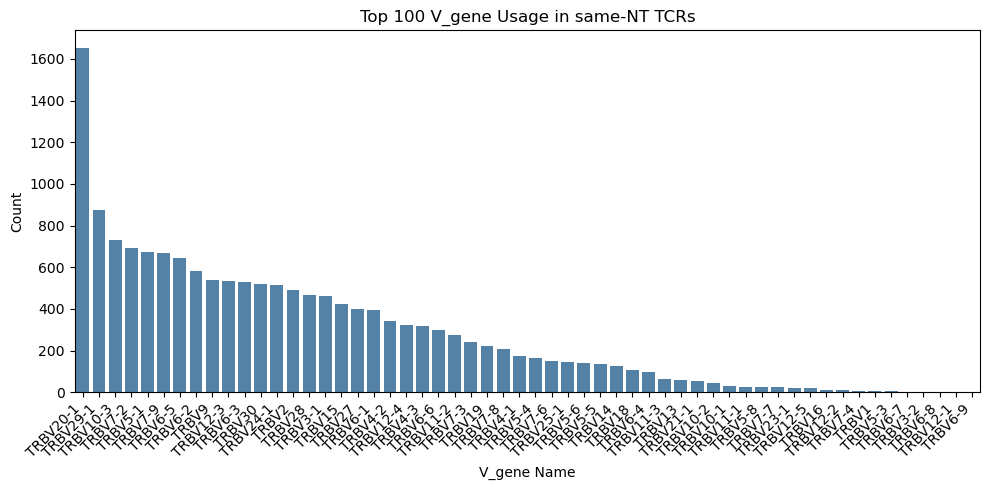

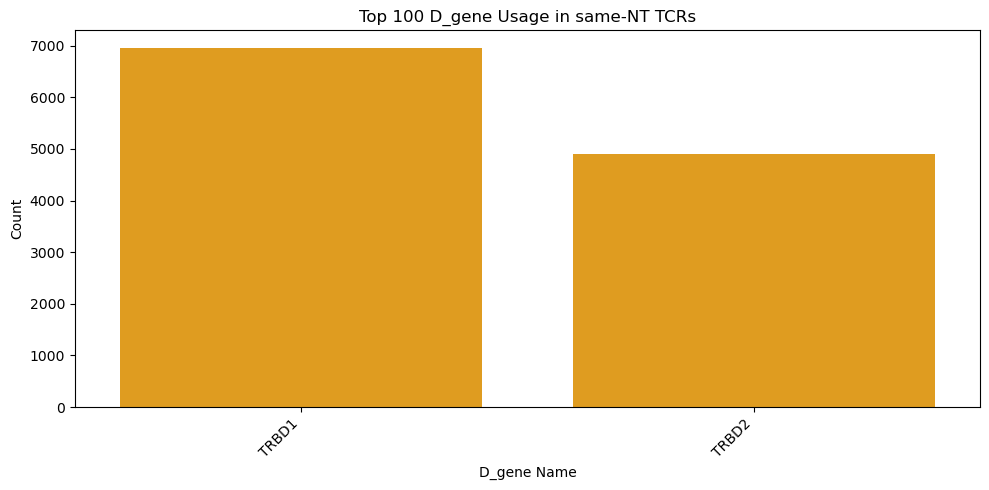

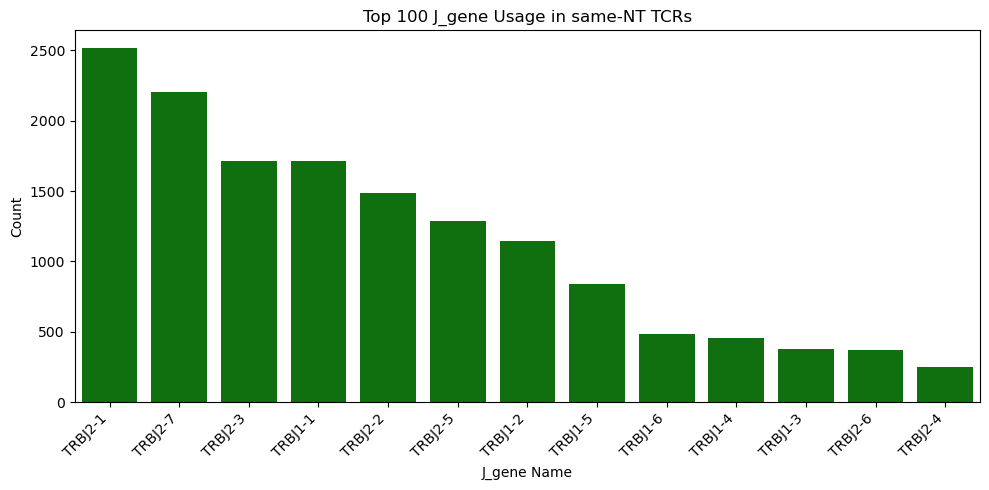

In [25]:

# Step 1: Filter clonotypes with shared identical nucleotide sequences
same_nt_df = clonotype_df[clonotype_df["aaSeqCDR3"].isin(same_nt)].copy()

# --- Apply to same-NT group ---
v_genes = extract_clean_genes(same_nt_df, "allVHitsWithScore")
d_genes = extract_clean_genes(same_nt_df, "allDHitsWithScore")
j_genes = extract_clean_genes(same_nt_df, "allJHitsWithScore")

# --- Count frequencies
v_counts = v_genes.value_counts().to_dict()
d_counts = d_genes.value_counts().to_dict()
j_counts = j_genes.value_counts().to_dict()

v_df = counter_to_df(v_counts, "V_gene")
d_df = counter_to_df(d_counts, "D_gene")
j_df = counter_to_df(j_counts, "J_gene")

plot_gene_usage(v_df, "V_gene", "steelblue", "same-NT TCRs")
plot_gene_usage(d_df, "D_gene", "orange", "same-NT TCRs")
plot_gene_usage(j_df, "J_gene", "green", "same-NT TCRs")


In [26]:
# Unique gene counts
n_v_genes = len(set(v_genes))
n_d_genes = len(set(d_genes))
n_j_genes = len(set(j_genes))

print(f"Number of unique V genes in same-NT group: {n_v_genes}")
print(f"Number of unique D genes in same-NT group: {n_d_genes}")
print(f"Number of unique J genes in same-NT group: {n_j_genes}")

Number of unique V genes in same-NT group: 56
Number of unique D genes in same-NT group: 2
Number of unique J genes in same-NT group: 13


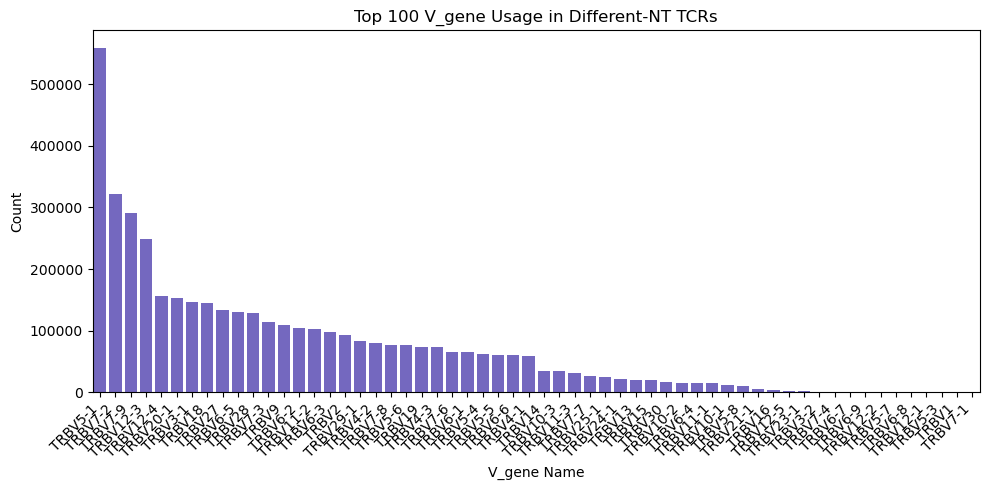

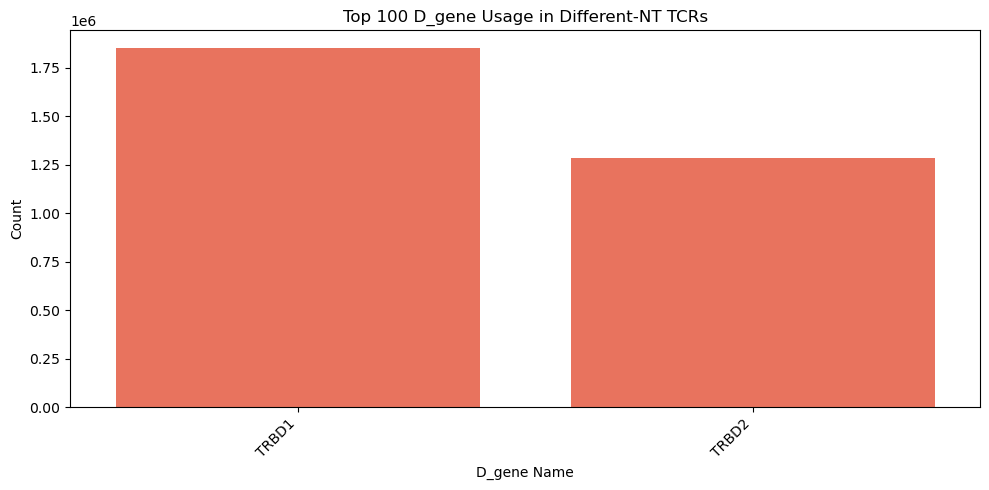

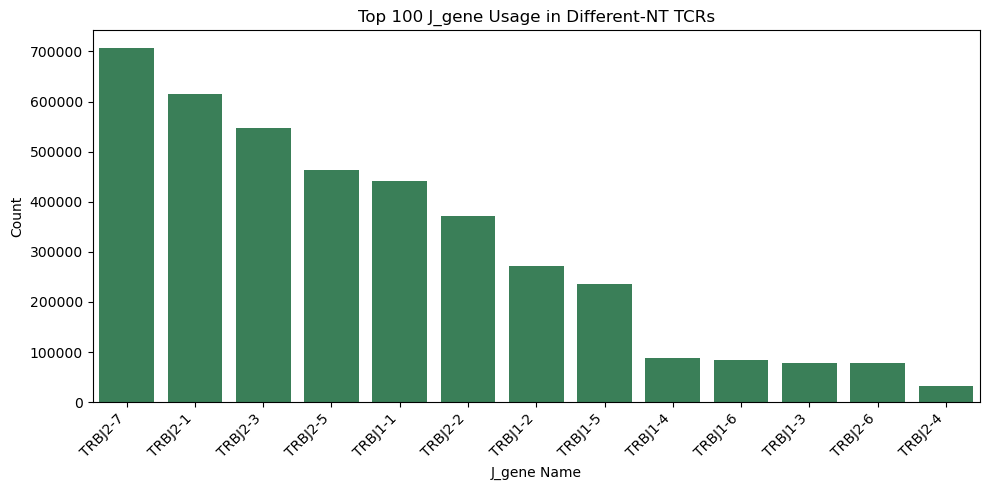

In [27]:
# Step 1: Filter clonotypes with shared amino acid but different nucleotide sequences
diff_nt_df = clonotype_df[clonotype_df["aaSeqCDR3"].isin(diff_nt)].copy()

# --- Extract gene names ---
v_genes_diff = extract_clean_genes(diff_nt_df, "allVHitsWithScore")
d_genes_diff = extract_clean_genes(diff_nt_df, "allDHitsWithScore")
j_genes_diff = extract_clean_genes(diff_nt_df, "allJHitsWithScore")

# --- Count frequencies (same as Counter but faster)
v_counts_diff = v_genes_diff.value_counts().to_dict()
d_counts_diff = d_genes_diff.value_counts().to_dict()
j_counts_diff = j_genes_diff.value_counts().to_dict()

v_df_diff = counter_to_df(v_counts_diff, "V_gene")
d_df_diff = counter_to_df(d_counts_diff, "D_gene")
j_df_diff = counter_to_df(j_counts_diff, "J_gene")

plot_gene_usage(v_df_diff, "V_gene", "slateblue", "Different-NT TCRs")
plot_gene_usage(d_df_diff, "D_gene", "tomato", "Different-NT TCRs")
plot_gene_usage(j_df_diff, "J_gene", "seagreen", "Different-NT TCRs")


In [28]:
# Unique gene counts
n_v_genes = len(set(v_genes_diff))
n_d_genes = len(set(d_genes_diff))
n_j_genes = len(set(j_genes_diff))

print(f"Number of unique V genes in same-NT group: {n_v_genes}")
print(f"Number of unique D genes in same-NT group: {n_d_genes}")
print(f"Number of unique J genes in same-NT group: {n_j_genes}")

Number of unique V genes in same-NT group: 58
Number of unique D genes in same-NT group: 2
Number of unique J genes in same-NT group: 13


comparing gene expression between both groups.

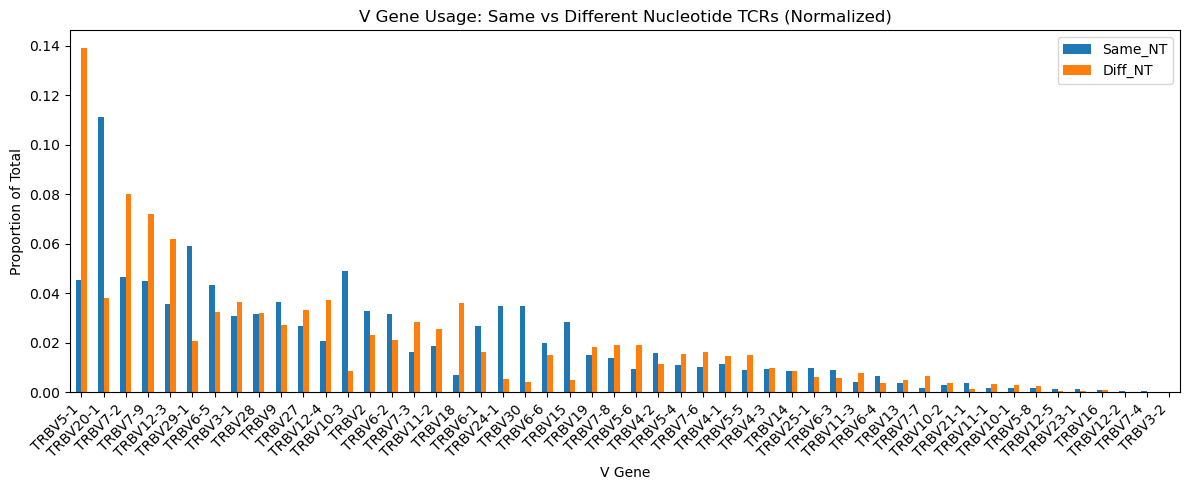

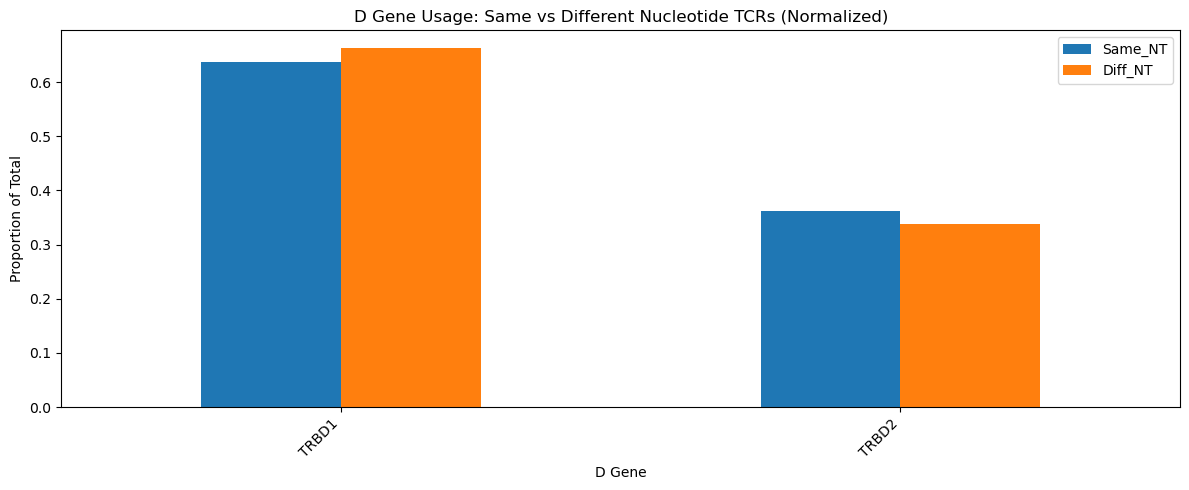

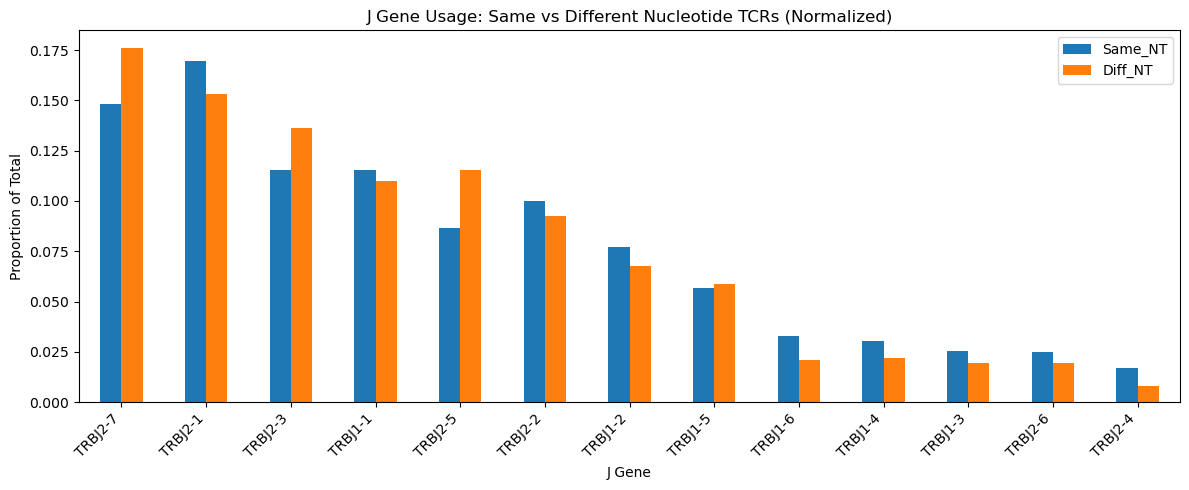

In [53]:
# --- Helper: Merge & normalize counts ---
def prepare_comparison_df(counts1, counts2, label1, label2, gene_type, top_n=50):
    # All unique gene names
    all_genes = set(counts1.keys()).union(set(counts2.keys()))
    
    # Normalize each counter
    total1 = sum(counts1.values())
    total2 = sum(counts2.values())

    data = []
    for gene in all_genes:
        norm1 = counts1.get(gene, 0) / total1
        norm2 = counts2.get(gene, 0) / total2
        data.append((gene, norm1, norm2))
    
    df = pd.DataFrame(data, columns=[gene_type, label1, label2])
    
    # Keep top N genes based on total usage
    df["combined"] = df[label1] + df[label2]
    df = df.sort_values("combined", ascending=False).head(top_n).drop(columns="combined")
    
    return df.set_index(gene_type)

# --- Compare each gene type ---
v_comp_df = prepare_comparison_df(v_counts, v_counts_diff, "Same_NT", "Diff_NT", "V_gene")
d_comp_df = prepare_comparison_df(d_counts, d_counts_diff, "Same_NT", "Diff_NT", "D_gene")
j_comp_df = prepare_comparison_df(j_counts, j_counts_diff, "Same_NT", "Diff_NT", "J_gene")

# --- Plotting function ---
def plot_comparison(df, gene_type, title="Gene Usage: Same vs Different Nucleotide TCRs (Normalized)"):
    ax = df.plot(kind="bar", figsize=(12, 5))
    plt.title(f"{gene_type} {title}")
    plt.ylabel("Proportion of Total")
    plt.xlabel(f"{gene_type} Gene")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_comparison(v_comp_df, "V")
plot_comparison(d_comp_df, "D")
plot_comparison(j_comp_df, "J")


now run the same code, but take into account only the first gene value in cell, if multiple genes are presented.

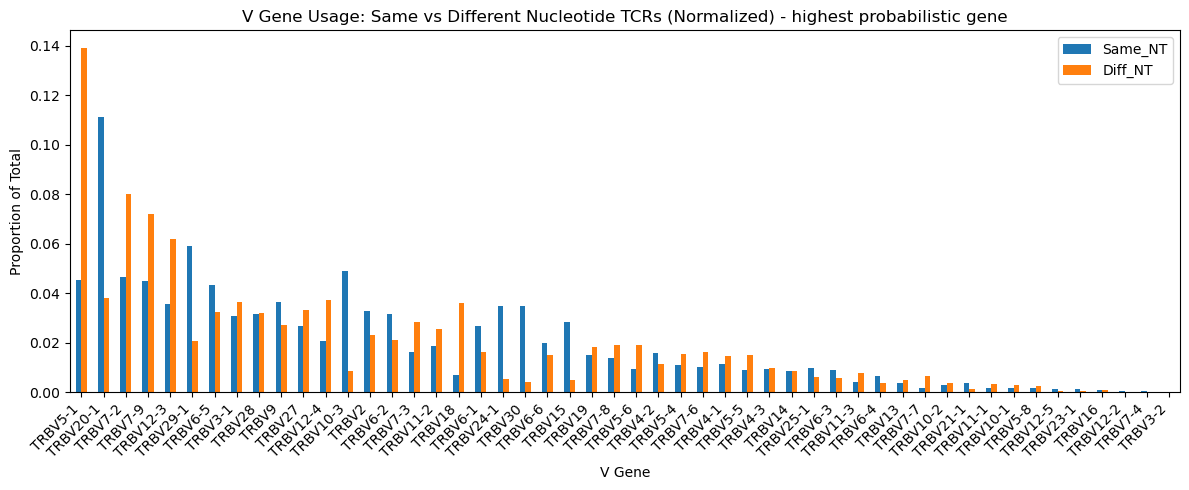

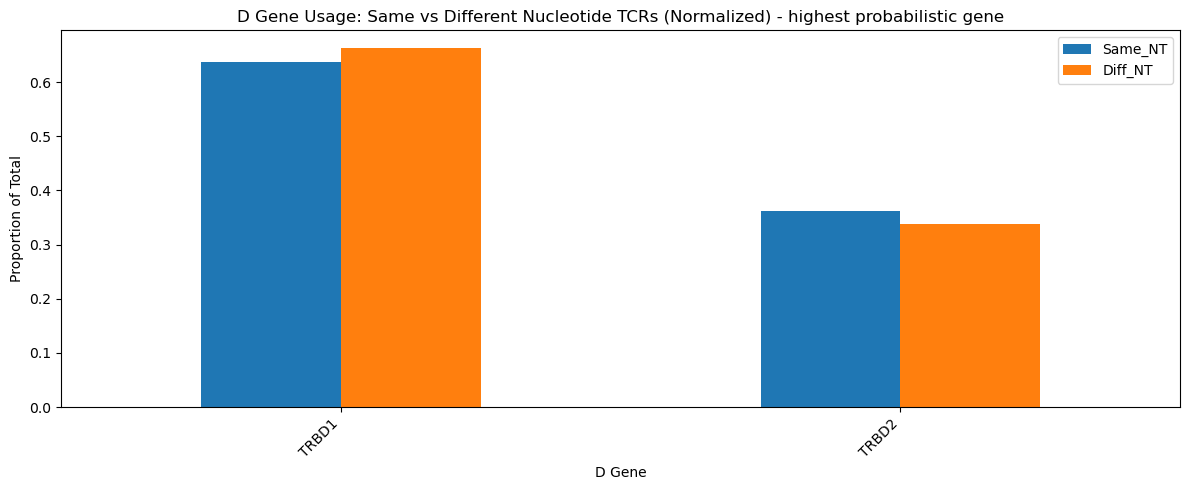

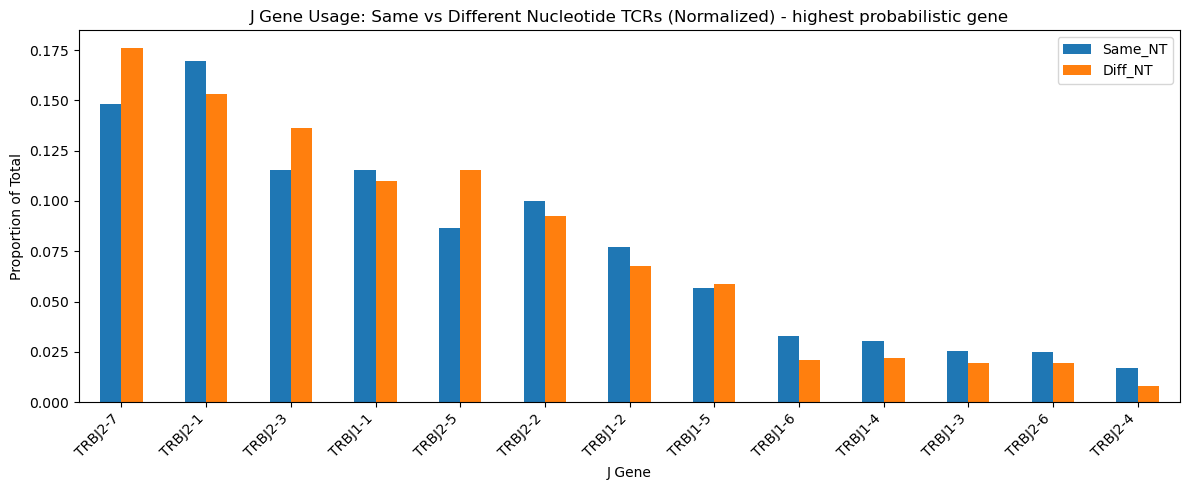

In [54]:
# --- Extract first gene only (before *, ignore rest) ---
def extract_first_gene(df, col):
    cleaned = df[[col]].dropna().copy()
    cleaned[col] = cleaned[col].str.split(",").str[0]         # first gene only
    cleaned[col] = cleaned[col].str.split("*").str[0]         # remove score
    return cleaned[col]


# --- SAME-NT GROUP ---
v_genes_same = extract_first_gene(same_nt_df, "allVHitsWithScore")
d_genes_same = extract_first_gene(same_nt_df, "allDHitsWithScore")
j_genes_same = extract_first_gene(same_nt_df, "allJHitsWithScore")

v_counts = v_genes_same.value_counts().to_dict()
d_counts = d_genes_same.value_counts().to_dict()
j_counts = j_genes_same.value_counts().to_dict()

# --- DIFF-NT GROUP ---
v_genes_diff = extract_first_gene(diff_nt_df, "allVHitsWithScore")
d_genes_diff = extract_first_gene(diff_nt_df, "allDHitsWithScore")
j_genes_diff = extract_first_gene(diff_nt_df, "allJHitsWithScore")

v_counts_diff = v_genes_diff.value_counts().to_dict()
d_counts_diff = d_genes_diff.value_counts().to_dict()
j_counts_diff = j_genes_diff.value_counts().to_dict()


# Prepare comparison DataFrames
v_comp_df = prepare_comparison_df(v_counts, v_counts_diff, "Same_NT", "Diff_NT", "V_gene")
d_comp_df = prepare_comparison_df(d_counts, d_counts_diff, "Same_NT", "Diff_NT", "D_gene")
j_comp_df = prepare_comparison_df(j_counts, j_counts_diff, "Same_NT", "Diff_NT", "J_gene")

# Plot
new_title = "Gene Usage: Same vs Different Nucleotide TCRs (Normalized) - highest probabilistic gene"
plot_comparison(v_comp_df, "V", title=new_title)
plot_comparison(d_comp_df, "D", title=new_title)
plot_comparison(j_comp_df, "J", title=new_title)


### differnt nt group

In [31]:
from collections import Counter

# Filter relevant columns from diff_nt group
diff_nt_df_filtered = clonotype_df[clonotype_df["aaSeqCDR3"].isin(diff_nt)][["aaSeqCDR3", "nSeqCDR3"]].dropna().drop_duplicates()

# Group all nucleotide sequences by identical aaSeqCDR3
nt_groups = diff_nt_df_filtered.groupby("aaSeqCDR3")["nSeqCDR3"].apply(list)

# Codon mutation counters
aa_pos_counter = Counter()
codon_base_counter = Counter()

# Process each group
for aa_seq, nt_list in nt_groups.items():
    codon_length = len(aa_seq)
    nt_list = [nt for nt in nt_list if len(nt) == codon_length * 3]  # sanity check

    if len(nt_list) < 2:
        continue  # skip if not enough NT variants to compare

    # Compare all pairs (conservatively, pairwise)
    for i in range(len(nt_list)):
        for j in range(i + 1, len(nt_list)):
            nt1 = nt_list[i]
            nt2 = nt_list[j]
            for codon_idx in range(codon_length):
                codon1 = nt1[codon_idx*3 : codon_idx*3+3]
                codon2 = nt2[codon_idx*3 : codon_idx*3+3]

                for base_pos in range(3):
                    if codon1[base_pos] != codon2[base_pos]:
                        aa_pos_counter[codon_idx + 1] += 1               # 1-based AA position
                        codon_base_counter[base_pos + 1] += 1           # 1, 2, 3 base in codon


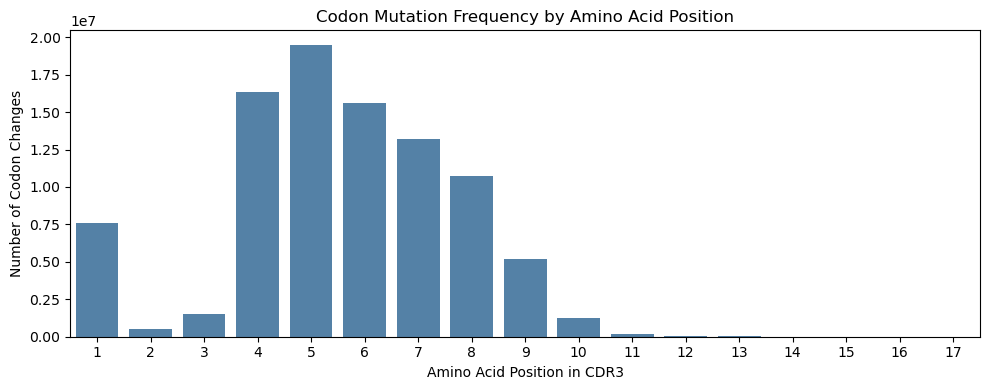

In [32]:
plt.figure(figsize=(10, 4))
sns.barplot(x=list(aa_pos_counter.keys()), y=list(aa_pos_counter.values()), color="steelblue")
plt.title("Codon Mutation Frequency by Amino Acid Position")
plt.xlabel("Amino Acid Position in CDR3")
plt.ylabel("Number of Codon Changes")
plt.tight_layout()
plt.show()


Should normelize

/tmp/ipykernel_128118/867360641.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["1st base", "2nd base", "3rd base"], y=[codon_base_counter[1], codon_base_counter[2], codon_base_counter[3]], palette="Set2")


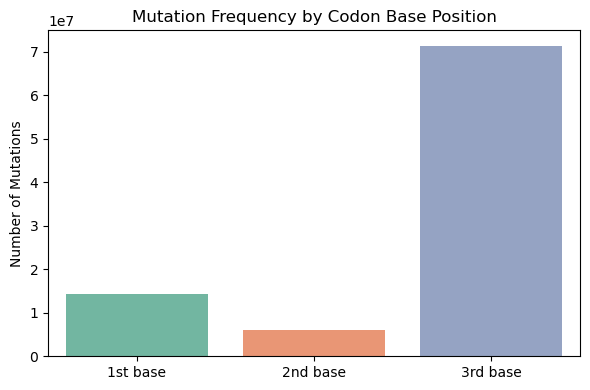

In [33]:
plt.figure(figsize=(6, 4))
sns.barplot(x=["1st base", "2nd base", "3rd base"], y=[codon_base_counter[1], codon_base_counter[2], codon_base_counter[3]], palette="Set2")
plt.title("Mutation Frequency by Codon Base Position")
plt.ylabel("Number of Mutations")
plt.tight_layout()
plt.show()


In [34]:
from collections import Counter

# Mutation direction tracker
nt_substitution_counter = Counter()

# Group by AA and get nSeqCDR3 list per aaSeqCDR3 (same as before)
nt_groups = diff_nt_df_filtered.groupby("aaSeqCDR3")["nSeqCDR3"].apply(list)

base_occurrence_counter = Counter()

# Compare all unique nucleotide pairs for each shared AA
for aa_seq, nt_list in nt_groups.items():
    codon_length = len(aa_seq)
    nt_list = [nt for nt in nt_list if len(nt) == codon_length * 3]

    if len(nt_list) < 2:
        continue

    for i in range(len(nt_list)):
        for j in range(i + 1, len(nt_list)):
            nt1 = nt_list[i]
            nt2 = nt_list[j]

            for pos in range(len(nt1)):
                base1 = nt1[pos]
                base2 = nt2[pos]
                # Track total base occurrences (regardless of match)
                base_occurrence_counter[base1] += 1
                base_occurrence_counter[base2] += 1
                # Track substitution
                if base1 != base2:
                    nt_substitution_counter[(base1, base2)] += 1

/tmp/ipykernel_128118/3459576537.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


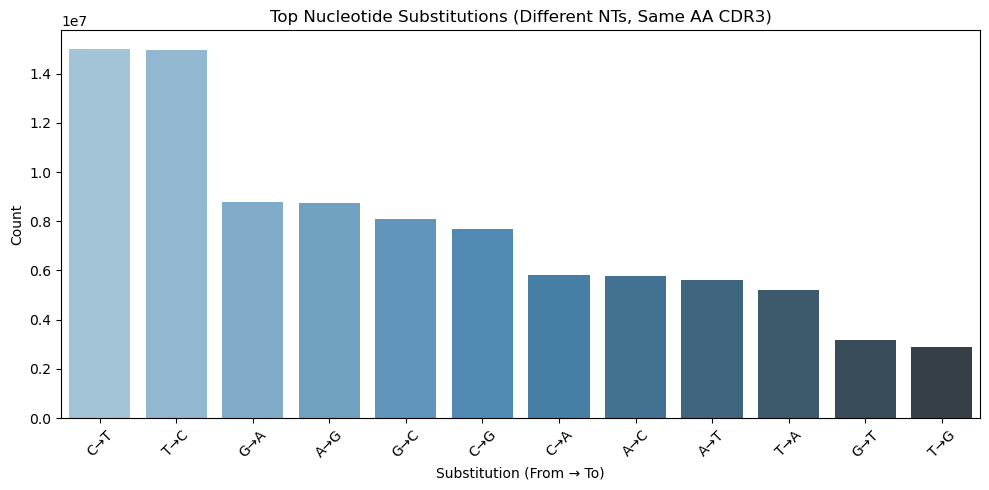

In [35]:
# Convert to sorted DataFrame
mut_df = pd.DataFrame(
    [(k[0], k[1], v) for k, v in nt_substitution_counter.items()],
    columns=["from", "to", "count"]
).sort_values("count", ascending=False)

# Create a new column with "A→G" style labels
mut_df["substitution"] = mut_df["from"] + "→" + mut_df["to"]

# Plot top 20 substitutions
plt.figure(figsize=(10, 5))
sns.barplot(
    data=mut_df.head(20),
    x="substitution",
    y="count",
    palette="Blues_d"
)
plt.title("Top Nucleotide Substitutions (Different NTs, Same AA CDR3)")
plt.xlabel("Substitution (From → To)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


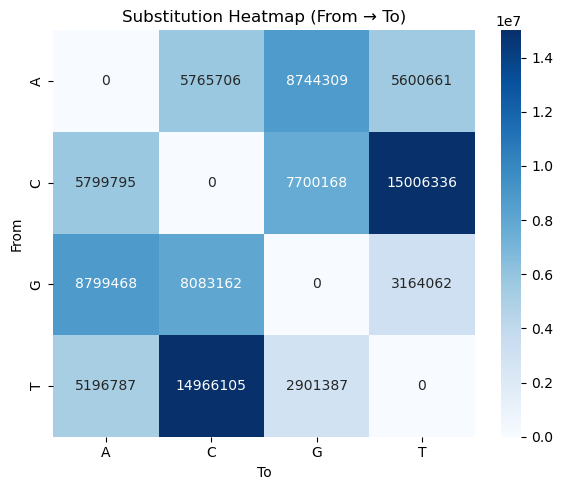

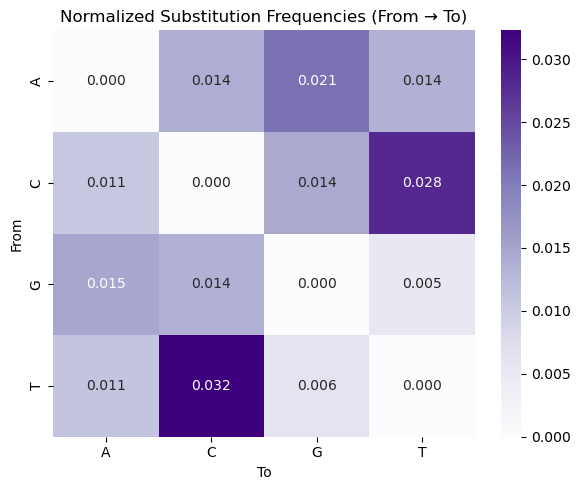

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming nt_substitution_counter and base_occurrence_counter already exist from earlier run

# Step 1: Heatmap of raw substitution counts
bases = ["A", "C", "G", "T"]
heatmap_matrix = pd.DataFrame(0, index=bases, columns=bases)

for (b1, b2), count in nt_substitution_counter.items():
    if b1 in bases and b2 in bases:
        heatmap_matrix.loc[b1, b2] = count

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Substitution Heatmap (From → To)")
plt.xlabel("To")
plt.ylabel("From")
plt.tight_layout()
plt.show()

# Step 2: Heatmap of normalized substitution frequencies
norm_data = []

for (b1, b2), count in nt_substitution_counter.items():
    total_b1 = base_occurrence_counter.get(b1, 1)  # prevent division by 0
    norm_freq = count / total_b1
    norm_data.append((b1, b2, norm_freq))

norm_df = pd.DataFrame(norm_data, columns=["from", "to", "normalized_freq"])

heatmap_norm = pd.DataFrame(0.0, index=bases, columns=bases)

for _, row in norm_df.iterrows():
    if row["from"] in bases and row["to"] in bases:
        heatmap_norm.loc[row["from"], row["to"]] = row["normalized_freq"]

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_norm, annot=True, fmt=".3f", cmap="Purples")
plt.title("Normalized Substitution Frequencies (From → To)")
plt.xlabel("To")
plt.ylabel("From")
plt.tight_layout()
plt.show()


Normelized frequency is count / total occurrences of "from", meaning - given "from" count, how likely it mutates to "to".

Now lets see if above pattern repeats in each of the 3 bases.

In [37]:
# Prep counters
substitution_by_position = {1: Counter(), 2: Counter(), 3: Counter()}
base_occurrence_by_position = {1: Counter(), 2: Counter(), 3: Counter()}

# Group nt sequences per identical AA
nt_groups = diff_nt_df_filtered.groupby("aaSeqCDR3")["nSeqCDR3"].apply(list)

for aa_seq, nt_list in nt_groups.items():
    codon_length = len(aa_seq)
    nt_list = [nt for nt in nt_list if len(nt) == codon_length * 3]

    if len(nt_list) < 2:
        continue

    for i in range(len(nt_list)):
        for j in range(i + 1, len(nt_list)):
            nt1 = nt_list[i]
            nt2 = nt_list[j]

            for codon_idx in range(codon_length):
                codon1 = nt1[codon_idx*3 : codon_idx*3+3]
                codon2 = nt2[codon_idx*3 : codon_idx*3+3]

                for base_pos in range(3):  # 0,1,2 → codon base 1,2,3
                    b1 = codon1[base_pos]
                    b2 = codon2[base_pos]
                    pos = base_pos + 1

                    base_occurrence_by_position[pos][b1] += 1
                    base_occurrence_by_position[pos][b2] += 1
                    if b1 != b2:
                        substitution_by_position[pos][(b1, b2)] += 1


/tmp/ipykernel_128118/2856317834.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sub_df.sort_values("count", ascending=False).head(15),


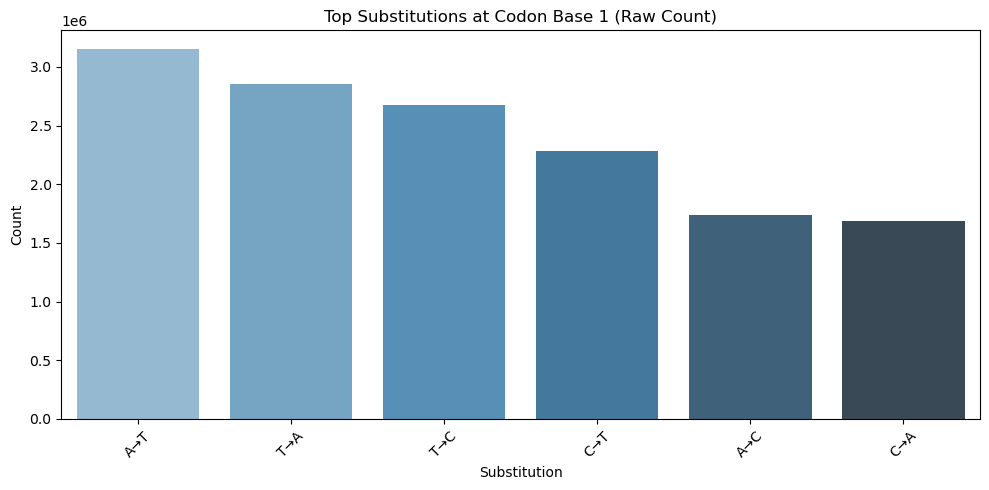

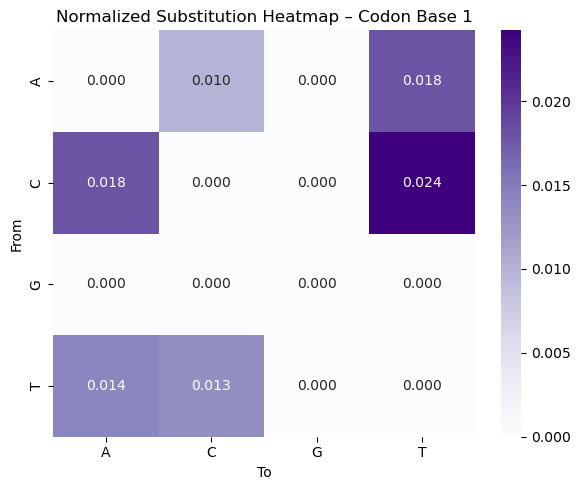

/tmp/ipykernel_128118/2856317834.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sub_df.sort_values("count", ascending=False).head(15),


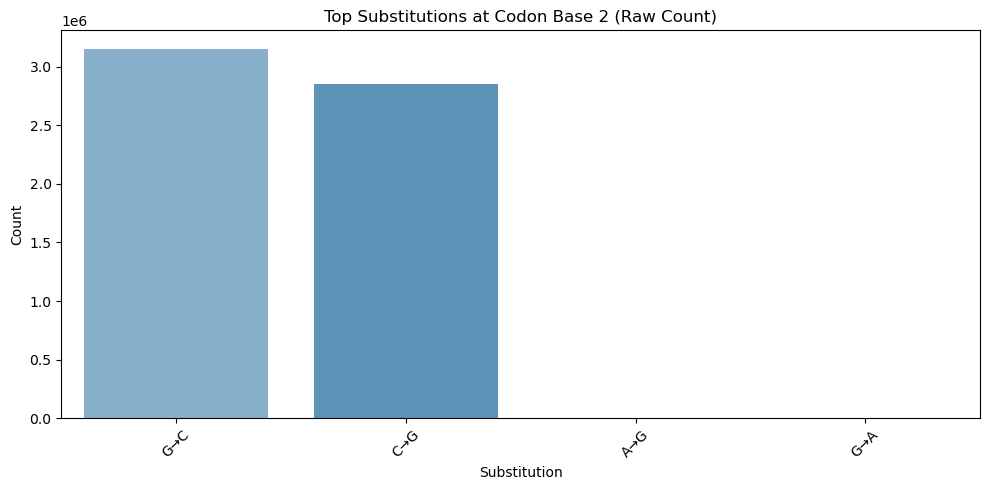

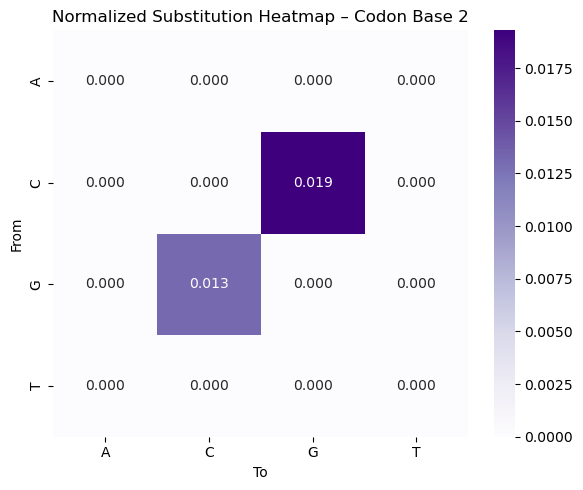

/tmp/ipykernel_128118/2856317834.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sub_df.sort_values("count", ascending=False).head(15),


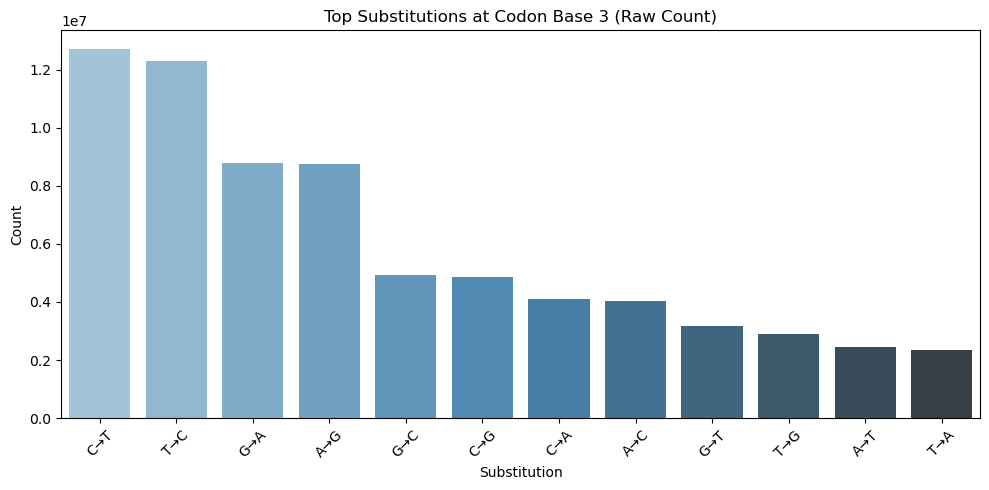

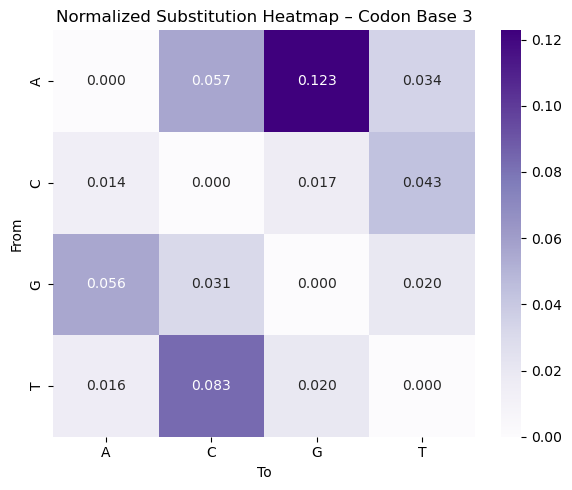

In [38]:
for pos in [1, 2, 3]:
    sub_counter = substitution_by_position[pos]
    base_counter = base_occurrence_by_position[pos]

    # Build DataFrame
    data = []
    for (from_base, to_base), count in sub_counter.items():
        total_from = base_counter.get(from_base, 1)
        norm_freq = count / total_from
        data.append((from_base, to_base, count, norm_freq))

    sub_df = pd.DataFrame(data, columns=["from", "to", "count", "normalized"])
    sub_df["substitution"] = sub_df["from"] + "→" + sub_df["to"]

    # Plot top 15 by count
    plt.figure(figsize=(10, 5))
    sns.barplot(data=sub_df.sort_values("count", ascending=False).head(15),
                x="substitution", y="count", palette="Blues_d")
    plt.title(f"Top Substitutions at Codon Base {pos} (Raw Count)")
    plt.xlabel("Substitution")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Optional: Normalized heatmap
    bases = ["A", "C", "G", "T"]
    heatmap_df = pd.DataFrame(0.0, index=bases, columns=bases)

    for _, row in sub_df.iterrows():
        f, t, val = row["from"], row["to"], row["normalized"]
        if f in bases and t in bases:
            heatmap_df.loc[f, t] = val

    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="Purples")
    plt.title(f"Normalized Substitution Heatmap – Codon Base {pos}")
    plt.xlabel("To")
    plt.ylabel("From")
    plt.tight_layout()
    plt.show()


אין ביאס מונחה ריצוף - אין שגיאות ריצוף - אלא זו נגזרת של השכיחות של השינויים ברצף הקודונים בגנום.

#### V gene usage

How many different nucleotide sequences (nSeqCDR3) encode the same amino acid sequence (aaSeqCDR3), and how that varies across different V genes.

X-axis – V Genes
Each label (e.g., TRBV4-1, TRBV20-1, etc.) represents a unique V gene assigned to a clonotype.

Only V genes with at least a minimum number of observations are shown (you filtered out low-count ones with min_cdr3s_per_gene).

Y-axis – Number of NT Variants per AA
The number of distinct nucleotide sequences (nSeqCDR3) found per each amino acid CDR3.

So each point represents a single (V_gene, aaSeqCDR3) pair and how many codon variants it has.

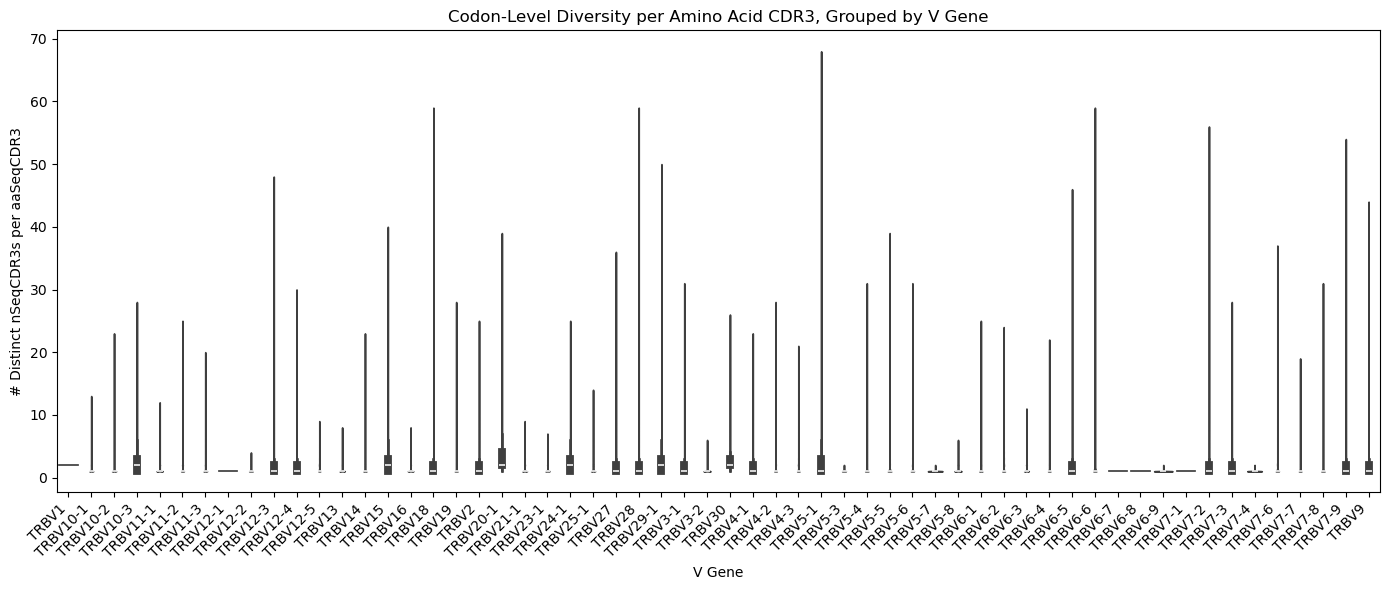

In [39]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter to unique (aa, nt, gene) rows from diff-nt group
gene_nt_df_v = diff_nt_df_filtered = clonotype_df[
    clonotype_df["aaSeqCDR3"].isin(diff_nt)
][["aaSeqCDR3", "nSeqCDR3", "allVHitsWithScore"]].dropna().drop_duplicates().copy()
gene_nt_df_v = gene_nt_df_v.drop_duplicates(subset=["aaSeqCDR3", "nSeqCDR3", "allVHitsWithScore"])

# Step 2: Extract first V gene using vectorized string ops
gene_nt_df_v["V_gene"] = (
    gene_nt_df_v["allVHitsWithScore"]
    .str.split(",").str[0]               # take first hit
    .str.extract(r"^([^*]+)")[0]         # extract before '*'
)

# Step 3: Count number of distinct NTs per AA CDR3 per V gene
diversity_df_v = (
    gene_nt_df_v.groupby(["V_gene", "aaSeqCDR3"])["nSeqCDR3"]
    .nunique()
    .reset_index(name="n_nt_variants")
)

# # Step 4: Optional - remove low-frequency V genes (fewer than N aaSeqCDR3s)
# min_cdr3s_per_gene = 10
# valid_genes = diversity_df["V_gene"].value_counts()[lambda x: x >= min_cdr3s_per_gene].index
# diversity_df = diversity_df[diversity_df["V_gene"].isin(valid_genes)]

# Step 5: Plot
plt.figure(figsize=(14, 6))
sns.violinplot(data=diversity_df_v, x="V_gene", y="n_nt_variants", inner="box", cut=0)
plt.xticks(rotation=45, ha="right")
plt.title("Codon-Level Diversity per Amino Acid CDR3, Grouped by V Gene")
plt.xlabel("V Gene")
plt.ylabel("# Distinct nSeqCDR3s per aaSeqCDR3")
plt.tight_layout()
plt.show()


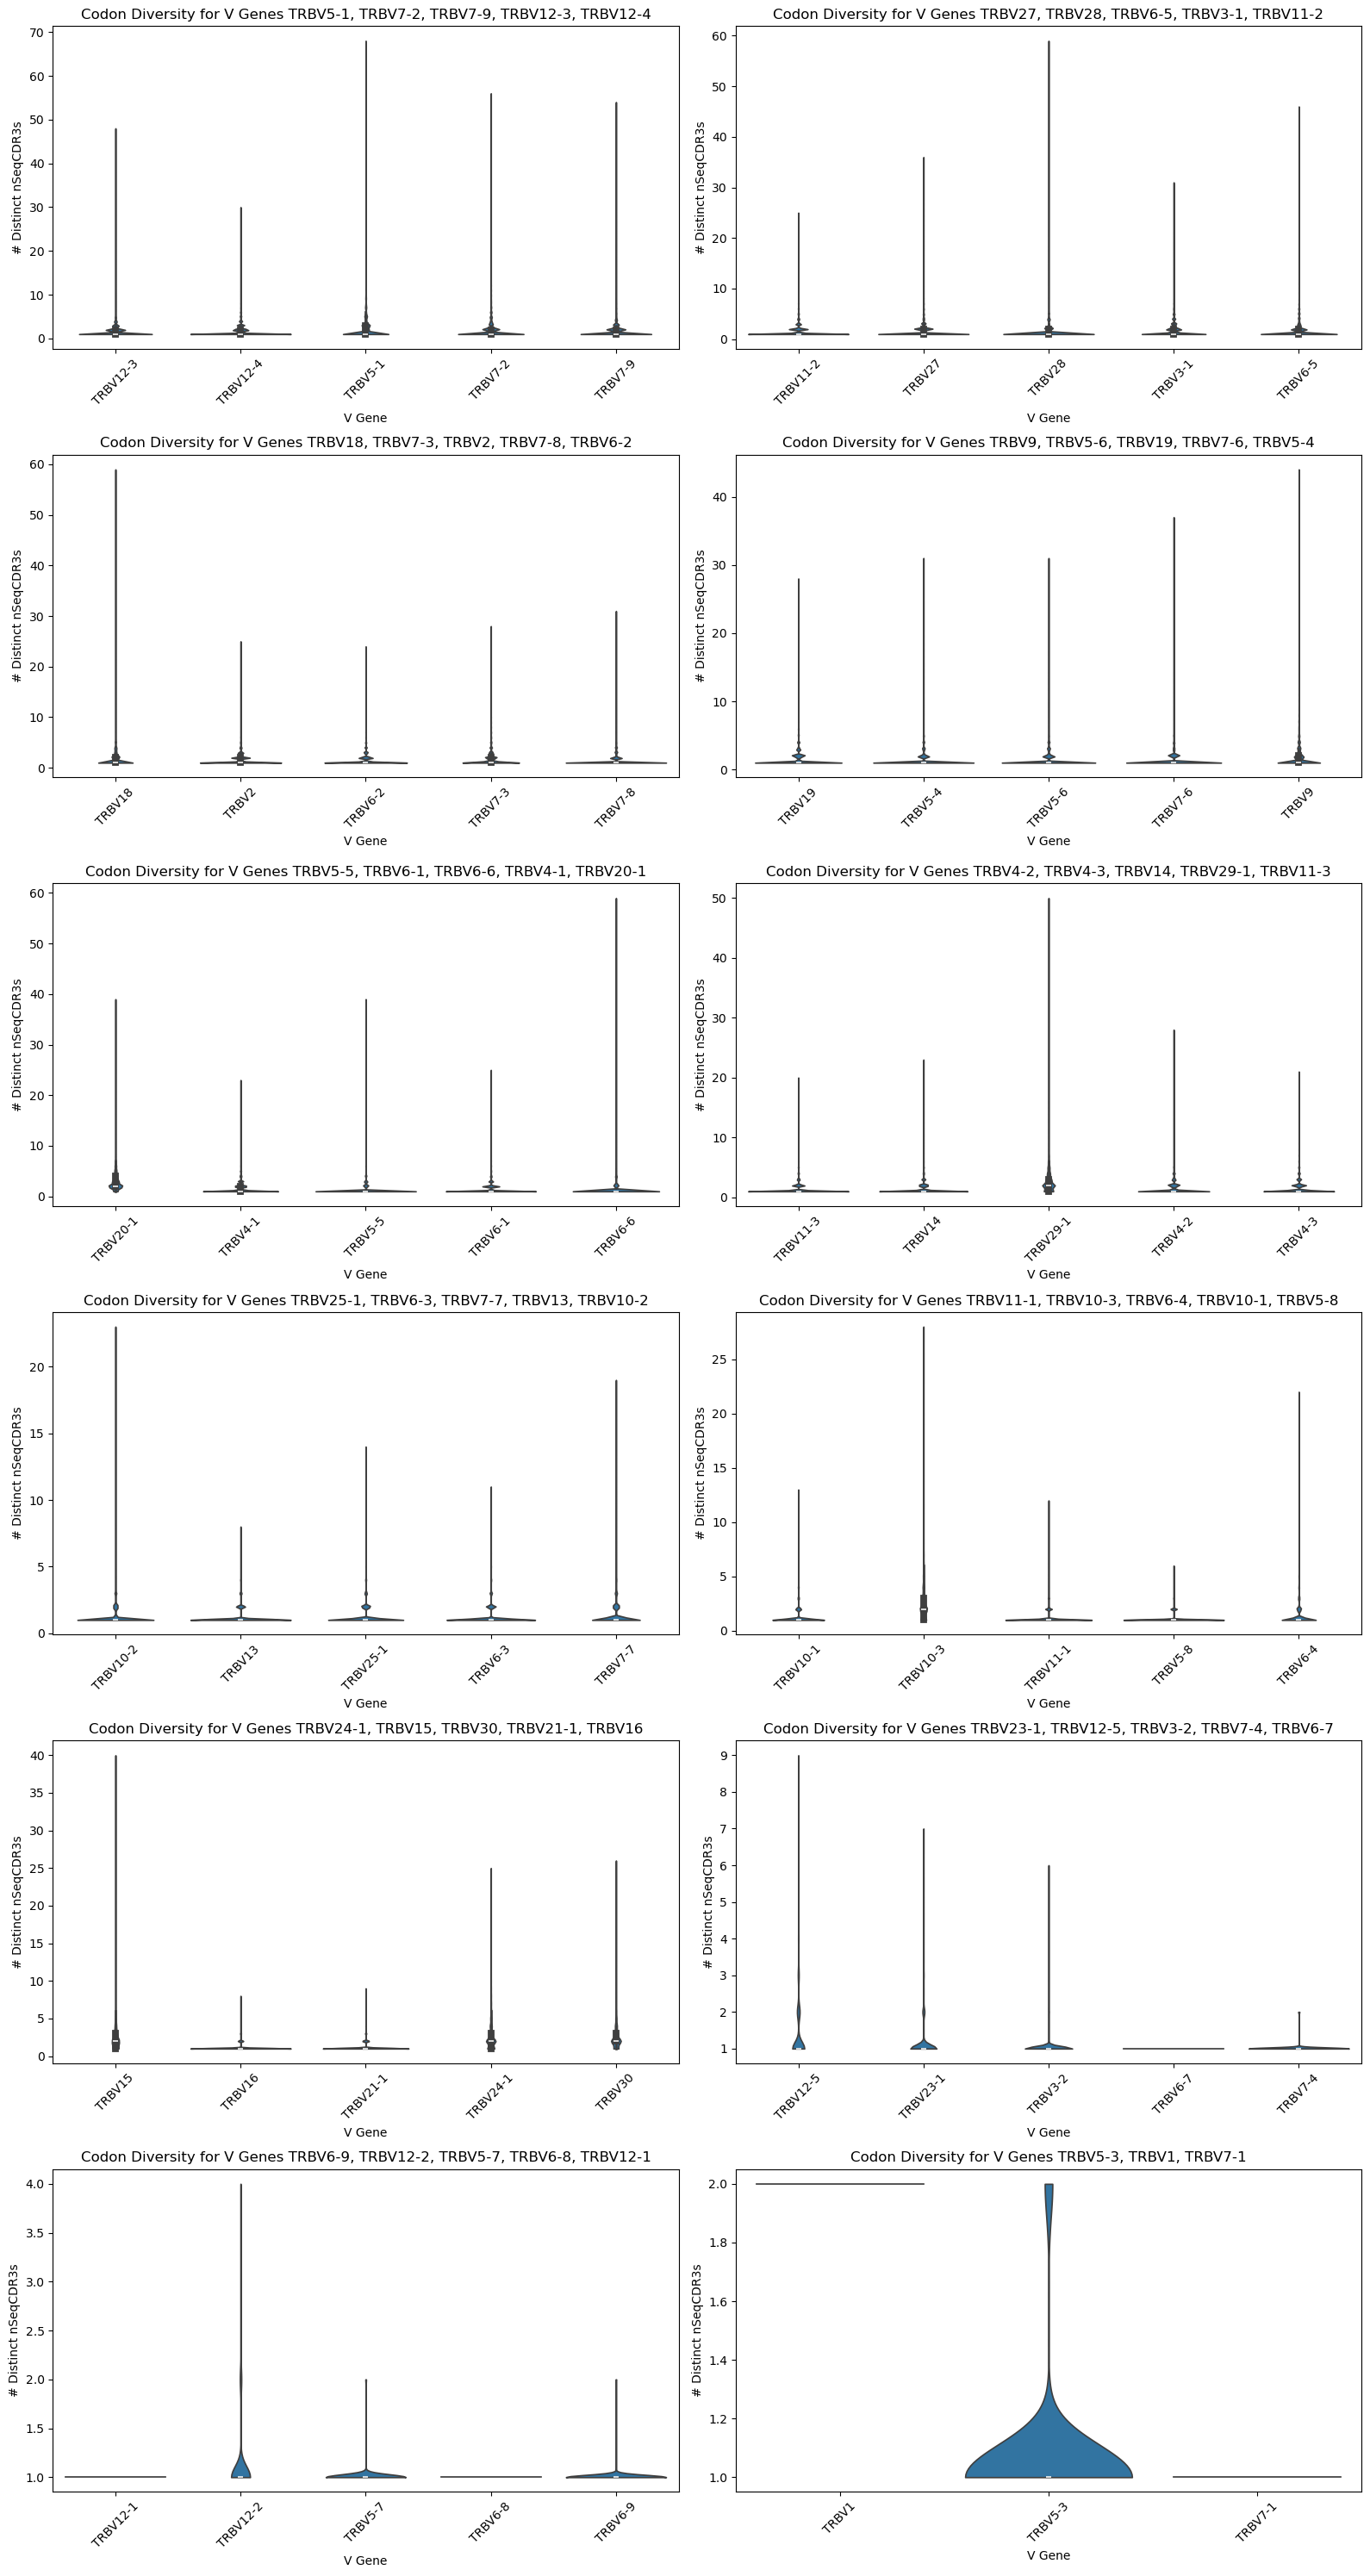

In [40]:
import math

# Step 1: Sort genes alphabetically or by frequency (you can change this)
v_genes_sorted = diversity_df_v["V_gene"].value_counts().index.tolist()

# Step 2: Split into chunks of 5 genes
chunk_size = 5
v_gene_chunks = [v_genes_sorted[i:i + chunk_size] for i in range(0, len(v_genes_sorted), chunk_size)]

# Step 3: Create subplots
n_chunks = len(v_gene_chunks)
n_cols = 2
n_rows = math.ceil(n_chunks / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 5), squeeze=False)

for idx, chunk in enumerate(v_gene_chunks):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    sns.violinplot(
        data=diversity_df_v[diversity_df_v["V_gene"].isin(chunk)],
        x="V_gene", y="n_nt_variants",
        inner="box", cut=0, ax=ax
    )
    ax.set_title(f"Codon Diversity for V Genes {', '.join(chunk)}")
    ax.set_xlabel("V Gene")
    ax.set_ylabel("# Distinct nSeqCDR3s")
    ax.tick_params(axis='x', rotation=45)

# Remove empty subplots if number isn't even
for i in range(n_chunks, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()


/tmp/ipykernel_128118/726708956.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


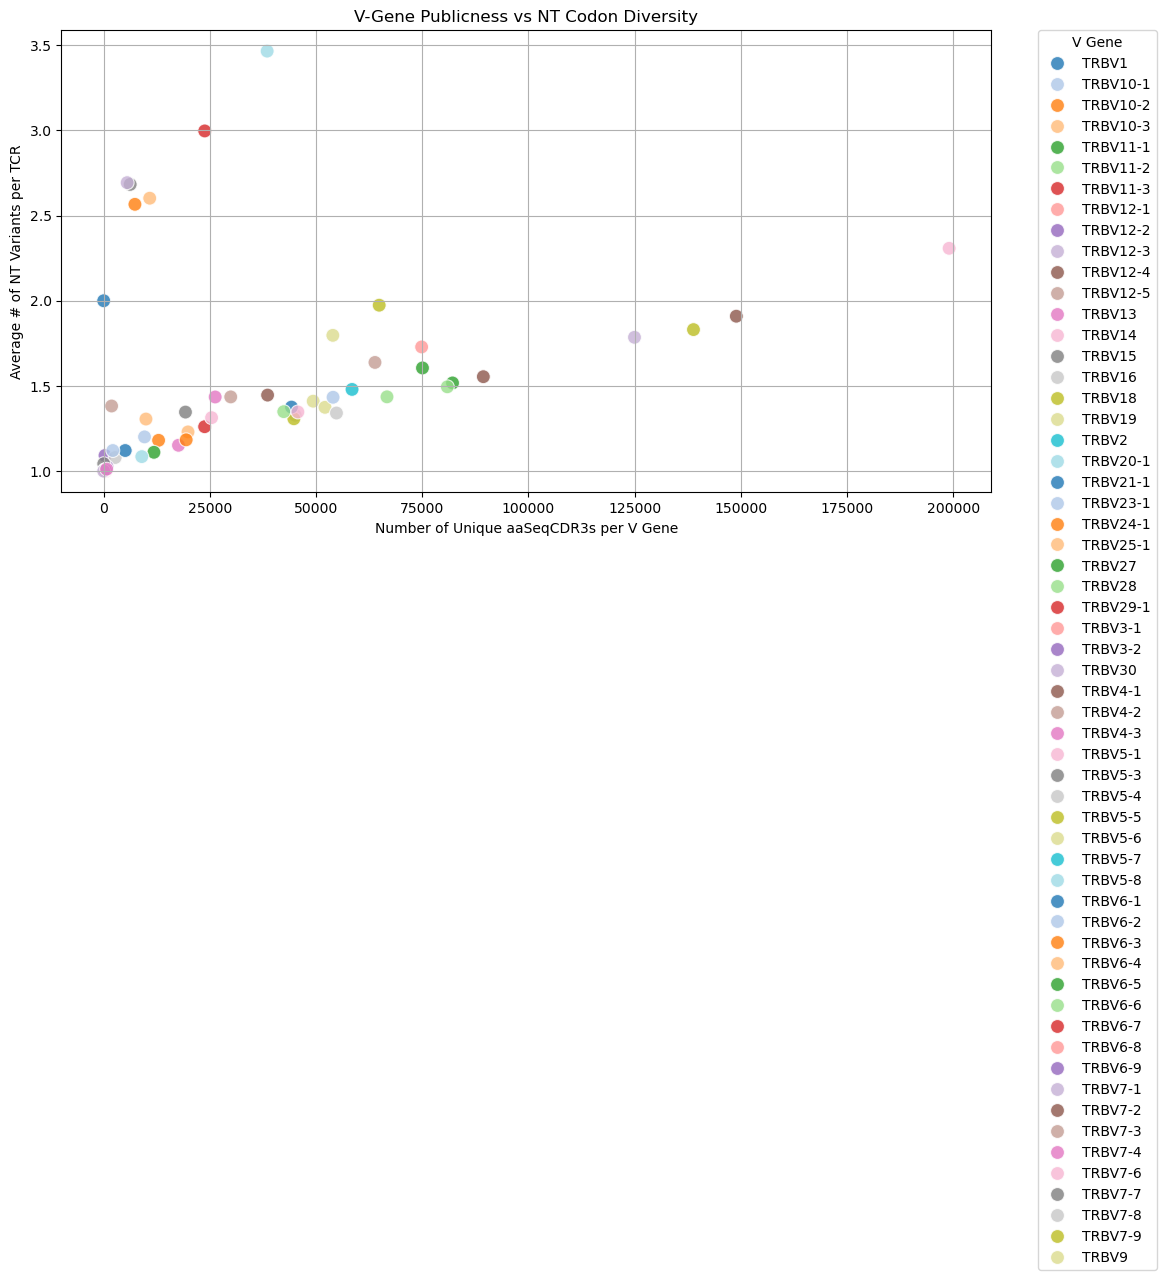

In [41]:
# Step 1: Aggregate V gene statistics
v_gene_summary = diversity_df_v.groupby("V_gene").agg(
    n_public_TCRs=("aaSeqCDR3", "nunique"),        # how many distinct TCRs use this V gene
    avg_nt_diversity=("n_nt_variants", "mean"),    # mean # of nt variants per TCR
    median_nt_diversity=("n_nt_variants", "median")
).reset_index()

# # Optional: filter out V genes with low sample size
# v_gene_summary = v_gene_summary[v_gene_summary["n_public_TCRs"] >= 5]

# Step 2: Scatter plot (publicness vs avg NT diversity)
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=v_gene_summary,
    x="n_public_TCRs",
    y="avg_nt_diversity",
    hue="V_gene",
    palette="tab20",
    s=100, alpha=0.8
)

plt.title("V-Gene Publicness vs NT Codon Diversity")
plt.xlabel("Number of Unique aaSeqCDR3s per V Gene")
plt.ylabel("Average # of NT Variants per TCR")
plt.grid(True)

# Move the legend outside the plot
plt.legend(title="V Gene", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()

avg_nt_diversity = sum of all unique TCR appearances divided by the number of unique TCRs for that v-gene.

the plot highlighted a group of v-genes that are "above" the corrolation plot. lets analyze them:

In [65]:
odd_v_genes = v_gene_summary[
    (v_gene_summary["n_public_TCRs"] < 50000) &
    (v_gene_summary["avg_nt_diversity"] >= 2.0)
]

# View or print them
print(odd_v_genes[["V_gene", "n_public_TCRs", "avg_nt_diversity"]])

      V_gene  n_public_TCRs  avg_nt_diversity
0      TRBV1              3          2.000000
3   TRBV10-3          10842          2.602011
14    TRBV15           6237          2.683021
19  TRBV20-1          38484          3.465440
22  TRBV24-1           7359          2.566110
26  TRBV29-1          23790          2.996805
29    TRBV30           5526          2.693268


Lets plot the logo for each of the groups (outliners and non-outliners v-genes)

In [66]:
outlier_v_genes = ["TRBV1", "TRBV10-3", "TRBV15", "TRBV20-1", "TRBV24-1", "TRBV29-1", "TRBV30"]

def extract_top_gene(series):
    cleaned = series.str.split(",").str[0]
    cleaned = cleaned.str.replace(r"\*00(\([^\)]*\))?", "*01", regex=True)
    cleaned = cleaned.str.split("*").str[0]
    return cleaned

# Copy to avoid modifying the original
cdr3_df = clonotype_df[["aaSeqCDR3", "allVHitsWithScore"]].dropna().copy()

cdr3_df["V_gene"] = extract_top_gene(cdr3_df["allVHitsWithScore"])
# Assign group label
cdr3_df["v_group"] = cdr3_df["V_gene"].apply(lambda x: "outlier" if x in outlier_v_genes else "non_outlier")


In [67]:
outlier_seqs = cdr3_df[cdr3_df["v_group"] == "outlier"]["aaSeqCDR3"].dropna().unique().tolist()
non_outlier_seqs = cdr3_df[cdr3_df["v_group"] == "non_outlier"]["aaSeqCDR3"].dropna().unique().tolist()

# Pad
all_seqs = outlier_seqs + non_outlier_seqs
max_len = max(len(s) for s in all_seqs)

def pad_sequences(seq_list, pad_char='-'):
    max_len = max(len(s) for s in seq_list)
    padded = [s.ljust(max_len, pad_char) for s in seq_list]
    if len(set(len(seq) for seq in padded)) > 1:
        raise ValueError("Padding failed — sequences are still of different lengths.")
    return padded

outlier_aligned = pad_sequences(outlier_seqs)
non_outlier_aligned = pad_sequences(non_outlier_seqs)

<Figure size 1200x300 with 0 Axes>

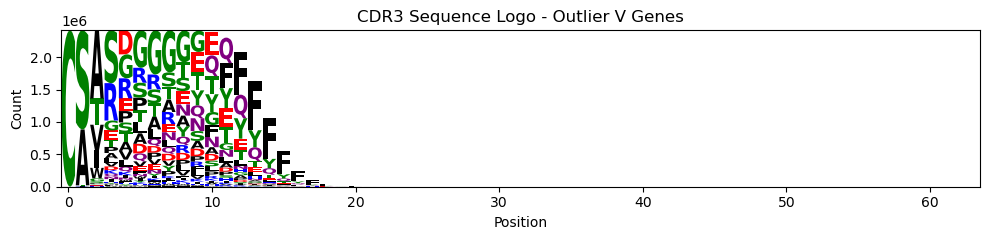

<Figure size 1200x300 with 0 Axes>

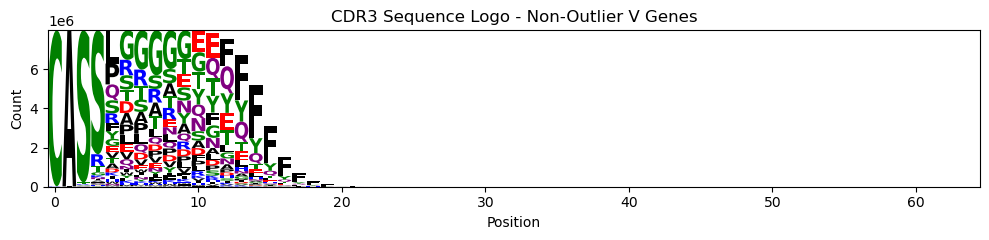

In [68]:
import logomaker
import matplotlib.pyplot as plt

def get_logo_df(seq_list):
    return logomaker.alignment_to_matrix(seq_list, to_type='counts')

def plot_logo(seq_list, title):
    logo_df = get_logo_df(seq_list)
    plt.figure(figsize=(12, 3))
    logomaker.Logo(logo_df, color_scheme='chemistry')
    plt.title(title)
    plt.xlabel("Position")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Plot
plot_logo(outlier_aligned, "CDR3 Sequence Logo - Outlier V Genes")
plot_logo(non_outlier_aligned, "CDR3 Sequence Logo - Non-Outlier V Genes")

Now lets do the same for J-genes.

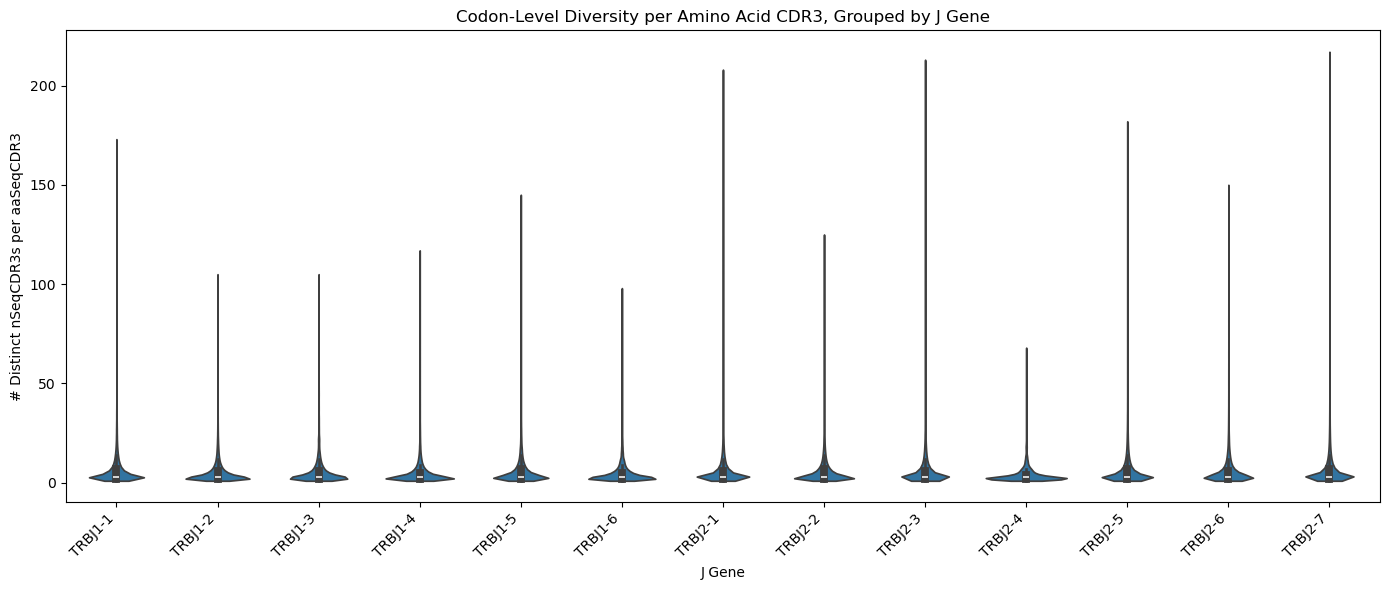

In [42]:
# Step 1: Create a filtered DataFrame with J gene info
gene_nt_df_j = clonotype_df[
    clonotype_df["aaSeqCDR3"].isin(diff_nt)
][["aaSeqCDR3", "nSeqCDR3", "allJHitsWithScore"]].dropna().drop_duplicates().copy()

# Step 2: Extract first J gene using fast vectorized method
gene_nt_df_j["J_gene"] = (
    gene_nt_df_j["allJHitsWithScore"]
    .str.split(",").str[0]               # take first hit
    .str.extract(r"^([^*]+)")[0]         # extract before '*'
)

# Step 3: Count distinct NTs per AA per J gene
diversity_df_j = (
    gene_nt_df_j.groupby(["J_gene", "aaSeqCDR3"])["nSeqCDR3"]
    .nunique()
    .reset_index(name="n_nt_variants")
)

# Step 4: Remove low-frequency genes for cleaner plot
min_cdr3s_per_gene = 10
valid_genes_j = diversity_df_j["J_gene"].value_counts()[lambda x: x >= min_cdr3s_per_gene].index
diversity_df_j = diversity_df_j[diversity_df_j["J_gene"].isin(valid_genes_j)]

# Step 5: Plot
plt.figure(figsize=(14, 6))
sns.violinplot(data=diversity_df_j, x="J_gene", y="n_nt_variants", inner="box", cut=0)
plt.xticks(rotation=45, ha="right")
plt.title("Codon-Level Diversity per Amino Acid CDR3, Grouped by J Gene")
plt.xlabel("J Gene")
plt.ylabel("# Distinct nSeqCDR3s per aaSeqCDR3")
plt.tight_layout()
plt.show()


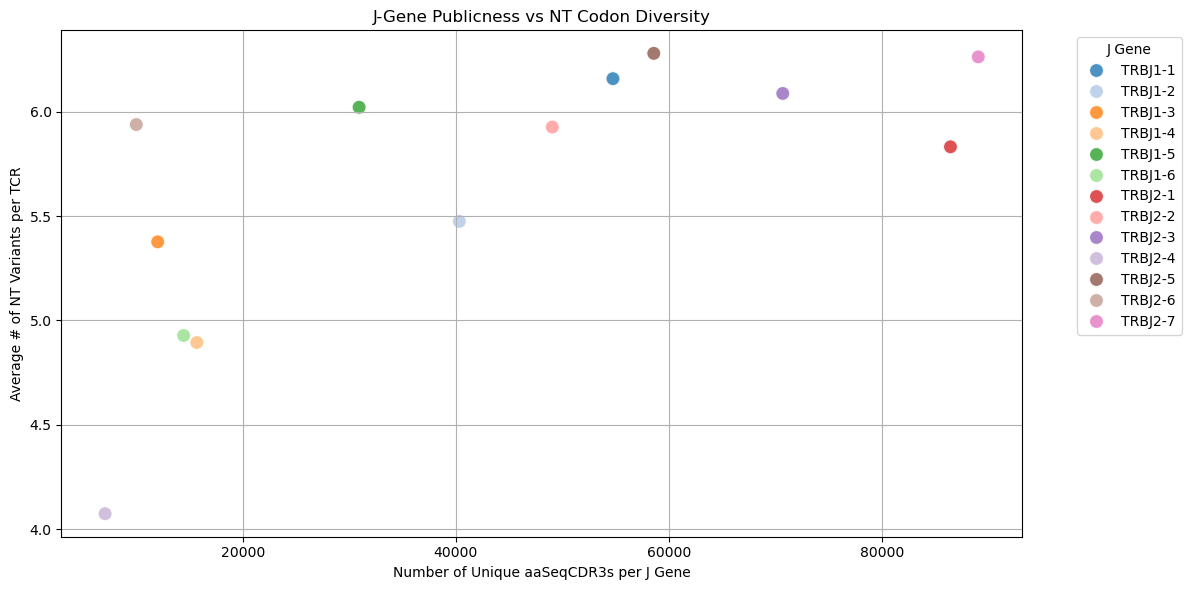

In [43]:
# Summary: average NT variants per J gene + publicness (# of TCRs)
j_gene_summary = (
    diversity_df_j.groupby("J_gene")
    .agg(
        avg_nt_diversity=("n_nt_variants", "mean"),
        n_public_TCRs=("aaSeqCDR3", "count")
    )
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=j_gene_summary,
    x="n_public_TCRs",
    y="avg_nt_diversity",
    hue="J_gene",
    palette="tab20",
    s=100,
    alpha=0.8
)

plt.title("J-Gene Publicness vs NT Codon Diversity")
plt.xlabel("Number of Unique aaSeqCDR3s per J Gene")
plt.ylabel("Average # of NT Variants per TCR")
plt.grid(True)
plt.legend(title="J Gene", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Codon frequencies across groups

for now lets focus on TCRs with publicity of >=2

In [44]:
# Step 1: Start from your existing filtered DataFrame
diff_nt_df_filtered_codons = clonotype_df[
    clonotype_df["aaSeqCDR3"].isin(diff_nt)
][["aaSeqCDR3", "nSeqCDR3", "Sample_ID", "group"]].dropna().drop_duplicates().copy()

# Step 2: Count how many samples each aaSeqCDR3 appears in per group
group_counts = (
    diff_nt_df_filtered_codons.groupby(["aaSeqCDR3", "group"])["Sample_ID"]
    .nunique()
    .unstack(fill_value=0)  # columns: fast | slow
)

# Step 3: Filter for those with ≥2 appearances in both fast and slow
public_aa = group_counts[
    (group_counts.get("fast", 0) >= 2) & (group_counts.get("slow", 0) >= 2)
].index

# Step 4: Filter the main dataframe to just those public aaSeqCDR3s
filtered_codon_df = diff_nt_df_filtered_codons[
    diff_nt_df_filtered_codons["aaSeqCDR3"].isin(public_aa)
].copy()


In [45]:
filtered_codon_df.columns

Index(['aaSeqCDR3', 'nSeqCDR3', 'Sample_ID', 'group'], dtype='object')

In [46]:
from collections import Counter

# Step 1: Filter rows where codon length matches AA length
filtered_codon_df["cdr3_len"] = filtered_codon_df["aaSeqCDR3"].str.len()
filtered_codon_df = filtered_codon_df[filtered_codon_df["nSeqCDR3"].str.len() == filtered_codon_df["cdr3_len"] * 3].copy()

# Step 2: Build codon-to-AA position mapping
codon_records = []

for idx, row in filtered_codon_df.iterrows():
    aa_seq = row["aaSeqCDR3"]
    nt_seq = row["nSeqCDR3"]
    group = row["group"]

    for i in range(len(aa_seq)):
        codon = nt_seq[i*3 : i*3+3]
        aa = aa_seq[i]
        codon_records.append({
            "AA": aa,
            "Position": i + 1,  # 1-based position
            "Codon": codon,
            "Group": group
        })

# Step 3: Convert to DataFrame
codon_df = pd.DataFrame(codon_records)

# # Step 4: Count codon usage
# codon_counts = (
#     codon_df.groupby(["AA", "Position", "Codon", "Group"])
#     .size()
#     .reset_index(name="Count")
# )

# # Optional: pivot for easy fast vs slow comparison
# codon_pivot = codon_counts.pivot_table(
#     index=["AA", "Position", "Codon"],
#     columns="Group",
#     values="Count",
#     fill_value=0
# ).reset_index()

# # Add log2 fold change (optional)
# codon_pivot["log2FC_fast_vs_slow"] = np.log2((codon_pivot.get("fast", 0) + 1) / (codon_pivot.get("slow", 0) + 1))


In [47]:
# Step 4: Count raw codon usage
codon_counts = (
    codon_df.groupby(["AA", "Position", "Codon", "Group"])
    .size()
    .reset_index(name="Count")
)

# Step 5: Normalize counts within each group
group_totals = codon_counts.groupby("Group")["Count"].transform("sum")
codon_counts["Normalized"] = codon_counts["Count"] / group_totals

# Step 6: Pivot normalized values for comparison
codon_pivot = codon_counts.pivot_table(
    index=["AA", "Position", "Codon"],
    columns="Group",
    values="Normalized",
    fill_value=0
).reset_index()

# Step 7: Add normalized log2 fold change
codon_pivot["log2FC_fast_vs_slow"] = np.log2(
    (codon_pivot.get("fast", 0) + 1e-9) / (codon_pivot.get("slow", 0) + 1e-9)
)

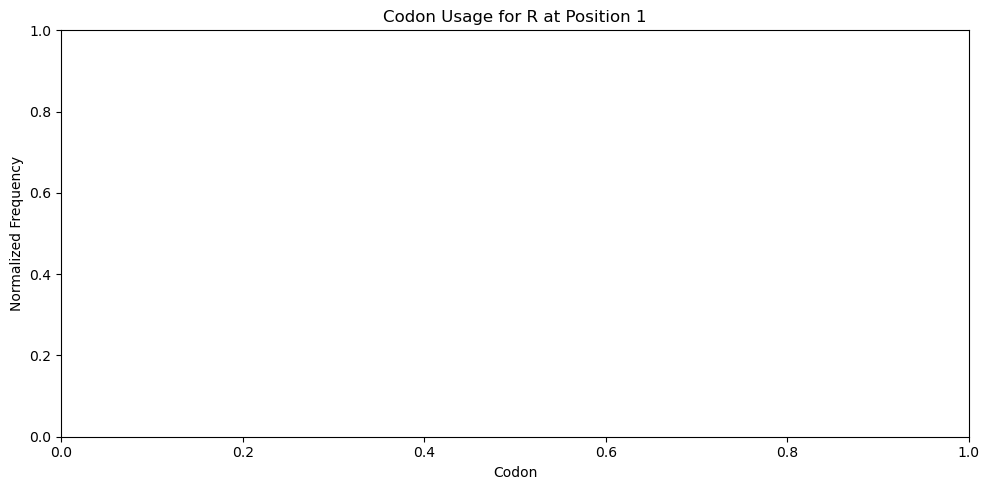

In [48]:
# --- Filter for specific AA and position ---
aa_of_interest = "R"        # e.g., Arginine
pos_of_interest = 1         # position index (1-based)

codon_subset = codon_counts[
    (codon_counts["AA"] == aa_of_interest) &
    (codon_counts["Position"] == pos_of_interest)
].copy()

# --- Normalize within group (optional, for fair comparison) ---
codon_subset["norm_count"] = codon_subset.groupby("Group")["Count"].transform(lambda x: x / x.sum())

# --- Plot ---
plt.figure(figsize=(10, 5))
sns.barplot(
    data=codon_subset,
    x="Codon",
    y="norm_count",
    hue="Group",
    palette="Set2"
)
plt.title(f"Codon Usage for {aa_of_interest} at Position {pos_of_interest}")
plt.ylabel("Normalized Frequency")
plt.xlabel("Codon")
plt.tight_layout()
plt.show()


now lets group them by their amino acid, across all available positions.
positive (normelized by total TCR amino acid counts [sum of all nt permutations for that amino acid]) indicated more frequent in fast group. negative - in slow group.

/tmp/ipykernel_128118/1948338303.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


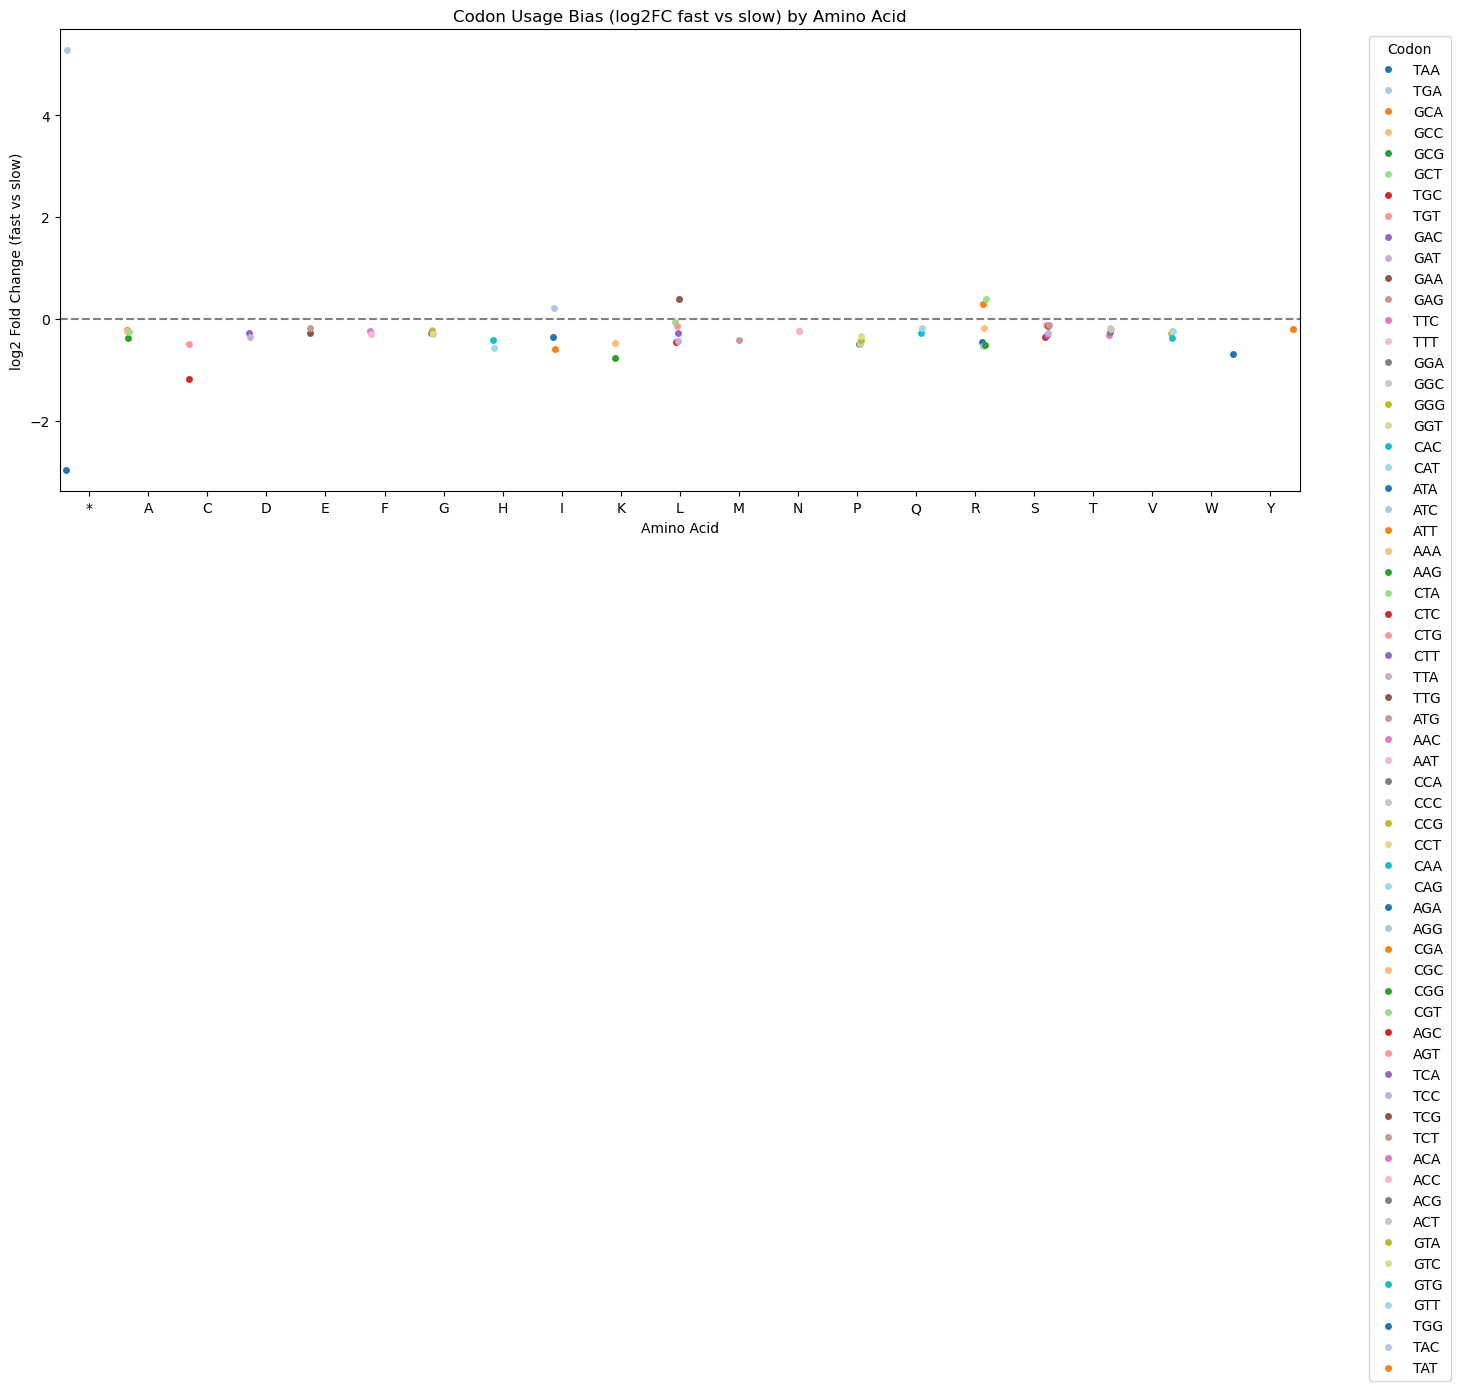

In [49]:
# Aggregate log2FC by AA and Codon
aa_grouped = codon_pivot.groupby(["AA", "Codon"], as_index=False).agg({
    "log2FC_fast_vs_slow": "mean"
})

# Sort amino acids for consistent plotting
aa_order = sorted(aa_grouped["AA"].unique())

# Plot
plt.figure(figsize=(16, 6))
sns.stripplot(
    data=aa_grouped,
    x="AA",
    y="log2FC_fast_vs_slow",
    hue="Codon",
    dodge=True,
    palette="tab20",
    jitter=True
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Codon Usage Bias (log2FC fast vs slow) by Amino Acid")
plt.ylabel("log2 Fold Change (fast vs slow)")
plt.xlabel("Amino Acid")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Codon")
plt.tight_layout()
plt.show()


Remmember that values above are for the same amino acid across ALL positions, so nt values can be all positive (or negative).

/tmp/ipykernel_128118/1878626892.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


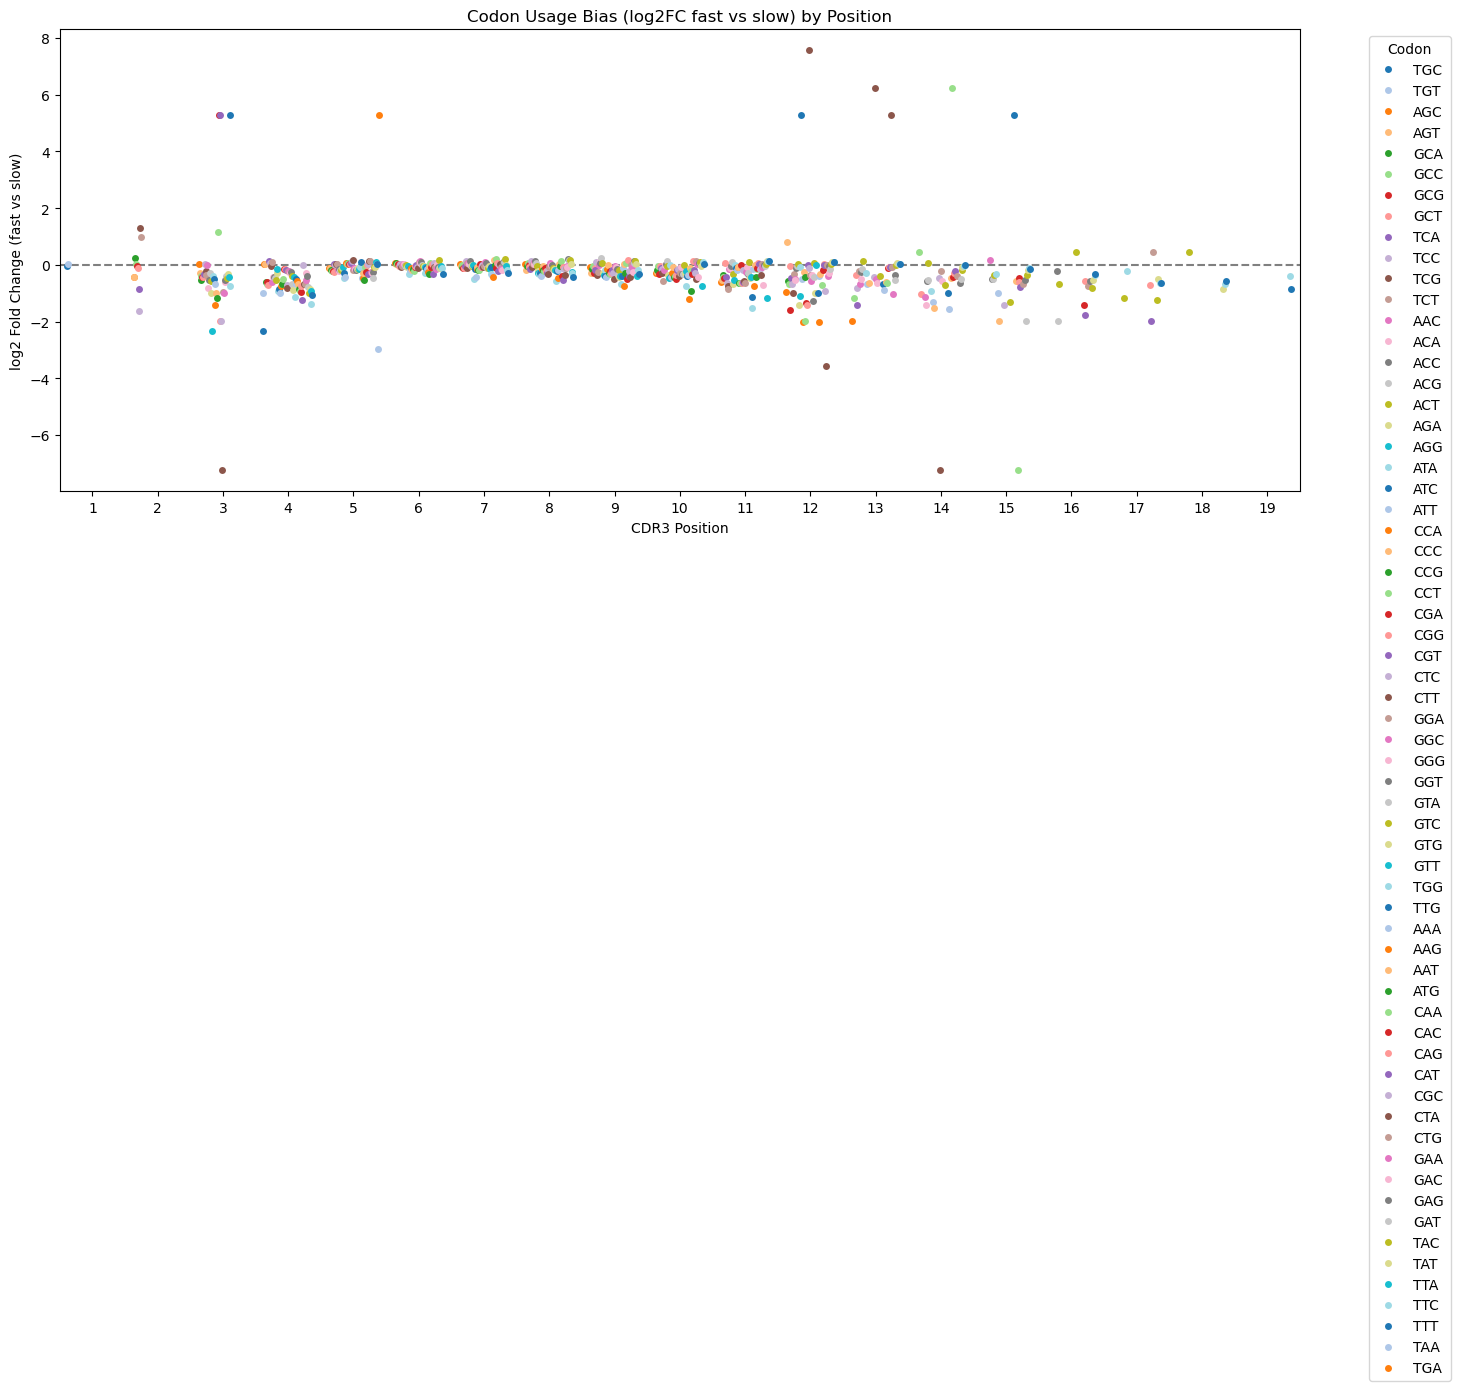

In [50]:
# Aggregate log2FC by Position and Codon
pos_grouped = codon_pivot.groupby(["Position", "Codon"], as_index=False).agg({
    "log2FC_fast_vs_slow": "mean"
})

# Plot
plt.figure(figsize=(16, 6))
sns.stripplot(
    data=pos_grouped,
    x="Position",
    y="log2FC_fast_vs_slow",
    hue="Codon",
    dodge=True,
    palette="tab20",
    jitter=True
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Codon Usage Bias (log2FC fast vs slow) by Position")
plt.ylabel("log2 Fold Change (fast vs slow)")
plt.xlabel("CDR3 Position")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Codon")
plt.tight_layout()
plt.show()


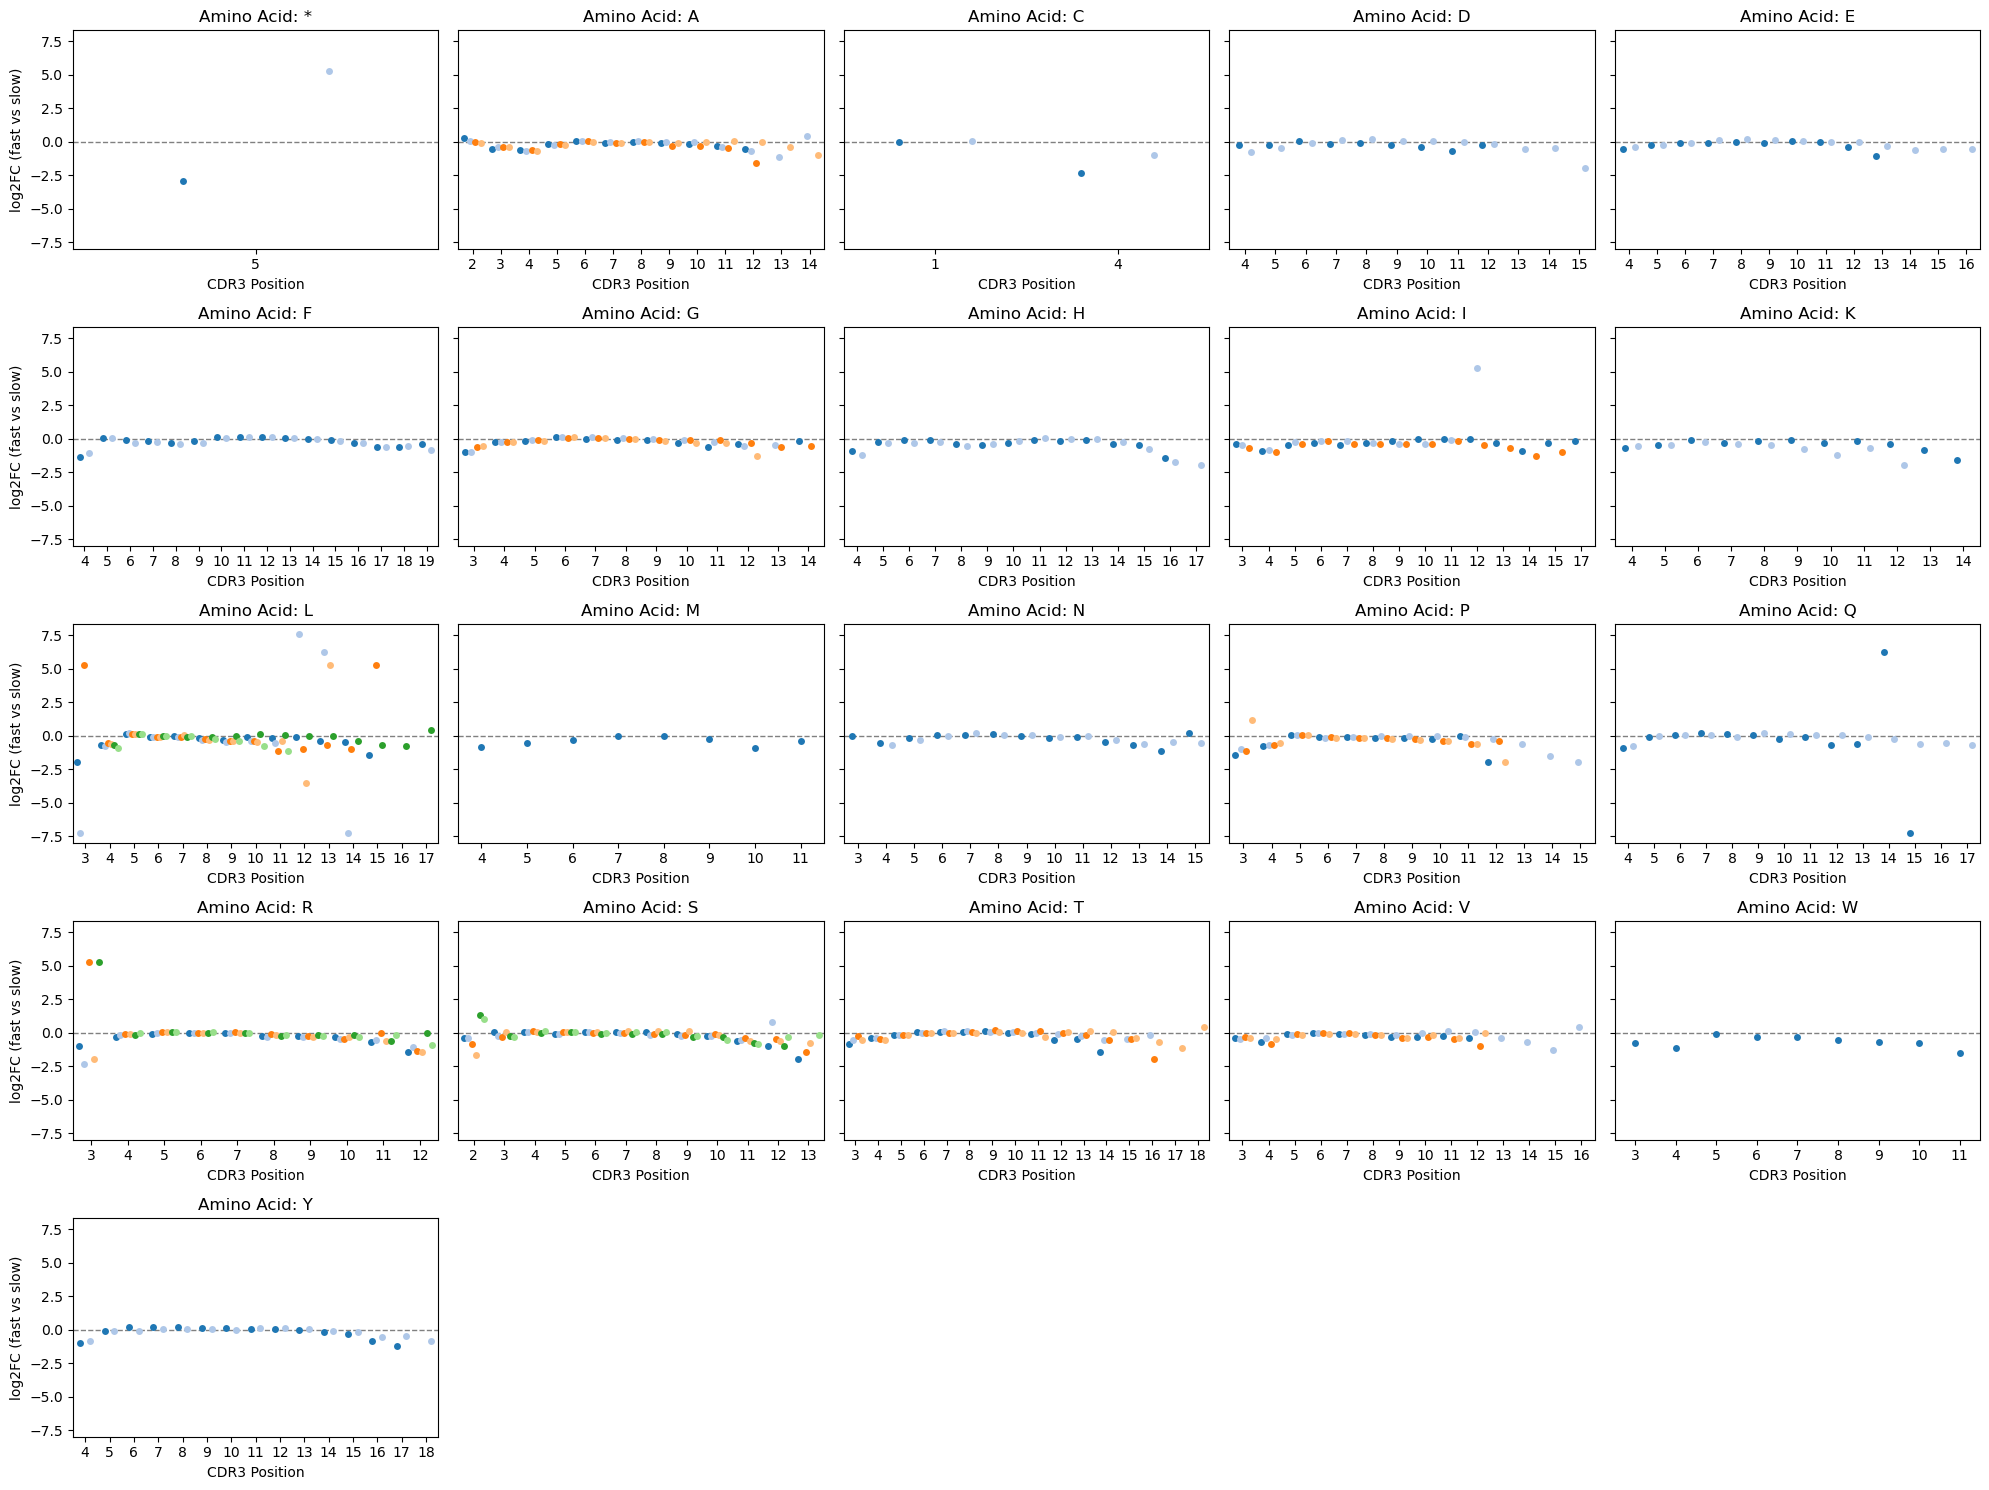

In [51]:
# Make sure codon_pivot exists and has needed columns
assert {"AA", "Position", "Codon", "log2FC_fast_vs_slow"}.issubset(codon_pivot.columns)

# Unique amino acids
amino_acids = sorted(codon_pivot["AA"].unique())

# Set up plot grid
n_cols = 5
n_rows = (len(amino_acids) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharey=True)
axes = axes.flatten()

# Plot each AA separately
for i, aa in enumerate(amino_acids):
    ax = axes[i]
    aa_data = codon_pivot[codon_pivot["AA"] == aa]

    sns.stripplot(
        data=aa_data,
        x="Position",
        y="log2FC_fast_vs_slow",
        hue="Codon",
        dodge=True,
        jitter=True,
        palette="tab20",
        ax=ax,
        legend=False
    )
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_title(f"Amino Acid: {aa}")
    ax.set_xlabel("CDR3 Position")
    ax.set_ylabel("log2FC (fast vs slow)")

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

מתכתב עם - אחרי שראינו את הלוגו - שבמרכז הרצפים יש וריביליות גבוהה ולכן רואים כמויות ביטוי שוות וייצוג שווה של כל אחד מהקודונים.

אם נניח הייתי צריך לייצג את S במרכז בצורה שמורה, הייתה העדפה לייצוג מסוים של אחד הקודונים.

## Housekeeping Genes

First run above code section, to create clonotype_df which contains: "aaSeqCDR3", "Sample_ID", "readCount".

Calculate frequency per clonotype per sample.

In [12]:
# Sum read counts per clonotype per sample
per_sample_freq = (
    clonotype_df.groupby(["aaSeqCDR3", "Sample_ID"])["readCount"]
    .sum()
    .reset_index()
)

# Normalize by total reads per sample
total_reads = clonotype_df.groupby("Sample_ID")["readCount"].sum().reset_index(name="total_reads")
per_sample_freq = per_sample_freq.merge(total_reads, on="Sample_ID")
per_sample_freq["frequency"] = per_sample_freq["readCount"] / per_sample_freq["total_reads"]

# Add group info (fast/slow) based on time threshold
per_sample_freq = per_sample_freq.merge(meta_df, on="Sample_ID", how="left")
per_sample_freq["group"] = per_sample_freq["extraction_time"].apply(
    lambda x: "fast" if x <= time_threshold else "slow"
)


In [13]:
def count_surviving_tcrs(
    per_sample_freq,
    presence_thresh=2,
    freq_thresh=1e-4, # 0.01%
    max_cv_thresh=1.0,
    max_abs_log2fc=1.0,
    use_presence=True,
    use_frequency=True,
    use_cv=True,
    use_log2fc=True,
):
    # Add group info if not already present
    if "group" not in per_sample_freq.columns:
        raise ValueError("Missing 'group' column. Please annotate 'fast'/'slow' groups first.")
    
    # Get clonotypes that appear in both fast and slow groups
    grouped = per_sample_freq.groupby(["aaSeqCDR3", "group"])["Sample_ID"].nunique().unstack(fill_value=0)
    shared_clones = grouped[(grouped["fast"] > 0) & (grouped["slow"] > 0)].index
    df = per_sample_freq[per_sample_freq["aaSeqCDR3"].isin(shared_clones)]

    # Compute summary stats per clonotype in slow group
    slow_df = df[df["group"] == "slow"]
    fast_df = df[df["group"] == "fast"]
    
    grouped_stats = slow_df.groupby("aaSeqCDR3")["frequency"].agg(
        n_samples="count",
        mean_freq="mean",
        std_freq="std"
    )
    grouped_stats["cv"] = grouped_stats["std_freq"] / grouped_stats["mean_freq"]

    # Compute mean frequency in fast group
    mean_fast = fast_df.groupby("aaSeqCDR3")["frequency"].mean()
    grouped_stats["mean_freq_fast"] = grouped_stats.index.map(mean_fast.to_dict())

    # Compute log2 fold change
    grouped_stats["log2FC"] = np.log2((grouped_stats["mean_freq"] + 1e-9) / (grouped_stats["mean_freq_fast"] + 1e-9))

    # Apply filters
    conditions = []
    if use_presence:
        conditions.append(grouped_stats["n_samples"] >= presence_thresh)
    if use_frequency:
        conditions.append(grouped_stats["mean_freq"] >= freq_thresh)
    if use_cv:
        conditions.append(grouped_stats["cv"] <= max_cv_thresh)
    if use_log2fc:
        conditions.append(grouped_stats["log2FC"].abs() <= max_abs_log2fc)

    if conditions:
        all_conditions = np.logical_and.reduce(conditions)
        surviving_clones = grouped_stats[all_conditions]
    else:
        surviving_clones = grouped_stats.copy()

    print(f"Number of surviving TCRs: {len(surviving_clones)}")
    return surviving_clones.reset_index()

In [14]:
survivors = count_surviving_tcrs(
    per_sample_freq,
    presence_thresh=3,
    freq_thresh=1e-4,
    max_cv_thresh=0.5,
    max_abs_log2fc=1.0,
    use_presence=True,
    use_frequency=False,
    use_cv=False,
    use_log2fc=False
)


Number of surviving TCRs: 62410


In [15]:
survivors.columns

Index(['aaSeqCDR3', 'n_samples', 'mean_freq', 'std_freq', 'cv',
       'mean_freq_fast', 'log2FC'],
      dtype='object')

Control group ideas:
- Option 1: Slow group TCRs in only 1–2 samples
Why it works:
These are TCRs that failed your survivor filter (didn't appear in enough samples).
They’re likely more sensitive to degradation or sequencing dropout.
Comparing to survivors may help reveal what features allow some TCRs to persist across samples.
How to use:
Filter slow group to CDR3s in exactly 1 or 2 samples.
Match length range (≤20 AAs).
You can optionally downsample to match the number of TCRs in survivors (for fairness). 

- Option 2: All fast group TCRs that appear in ≥3 samples (your current comparison)
Why it helps:
These TCRs are not degraded (fast extraction).
If survivors differ from these, it might be due to resilience under degradation, rather than just sample-sharing bias.
Limitation:
Fast and slow group donors might be biologically different.
This tells you what survives degradation, but not necessarily what’s public or shared.

- Option 3: Slow TCRs in ≥3 samples that are not in fast group
Earlier you saw 904 TCRs in slow (≥3 samples) that didn’t appear in fast. They are:
Less public.
Maybe artifacts.
Maybe degraded in fast samples (i.e., didn't survive)
This is a minimal control group, but interesting.

- Option 4: Matched control via propensity scoring
If you want to get rigorous, you can build a matched control group:
Match on total frequency, length, V gene usage, etc.
Survivors vs. matched nonsurvivors.
Helps isolate effect of variables like motif, hydrophobicity, etc.



Lets implement option 1:

In [16]:
# Count how many samples each TCR appears in (slow group)
slow_counts = per_sample_freq[per_sample_freq["group"] == "slow"]
slow_sample_counts = slow_counts.groupby("aaSeqCDR3")["Sample_ID"].nunique().reset_index(name="n_samples")

# Filter to 1–2 samples only
nonsurvivor_tcrs = slow_sample_counts[slow_sample_counts["n_samples"].between(1, 2)]["aaSeqCDR3"]


option 2:

In [17]:
# Filter to fast group
fast_group = per_sample_freq[per_sample_freq["group"] == "fast"]

# Count in how many fast samples each TCR appears
fast_sample_counts = fast_group.groupby("aaSeqCDR3")["Sample_ID"].nunique().reset_index(name="n_samples")

# Select TCRs present in ≥3 fast samples
fast_3plus_tcrs = fast_sample_counts[fast_sample_counts["n_samples"] >= 3]["aaSeqCDR3"]

# Get unique CDR3 sequences from fast group (≥3 samples)
fast_control_cdr3s = fast_group[fast_group["aaSeqCDR3"].isin(fast_3plus_tcrs)]["aaSeqCDR3"].drop_duplicates()


###  CDR3 Length Distribution

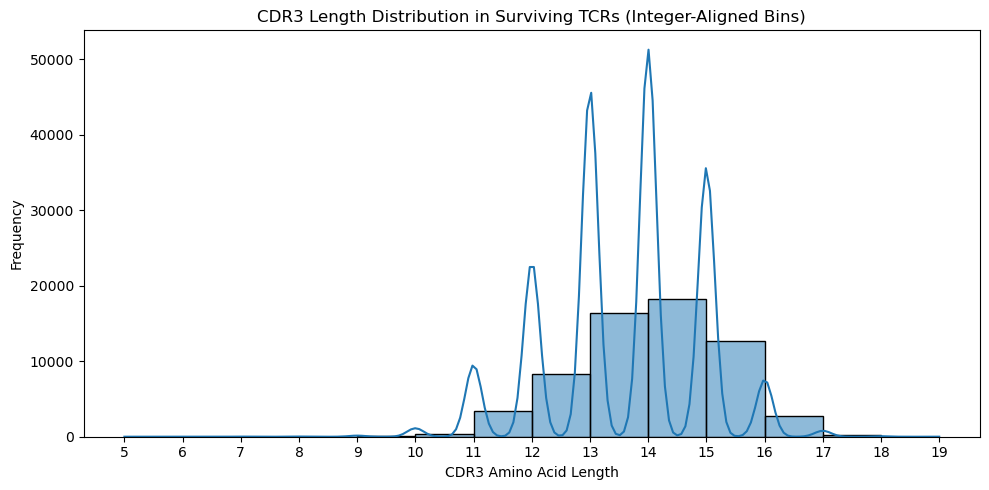

In [18]:
survivors["cdr3_length"] = survivors["aaSeqCDR3"].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(
    survivors["cdr3_length"],
    bins=np.arange(survivors["cdr3_length"].min(), survivors["cdr3_length"].max() + 1),
    kde=True,
    edgecolor="black"
)
plt.xticks(ticks=np.arange(survivors["cdr3_length"].min(), survivors["cdr3_length"].max() + 1))
plt.xlabel("CDR3 Amino Acid Length")
plt.ylabel("Frequency")
plt.title("CDR3 Length Distribution in Surviving TCRs (Integer-Aligned Bins)")
plt.tight_layout()
plt.show()


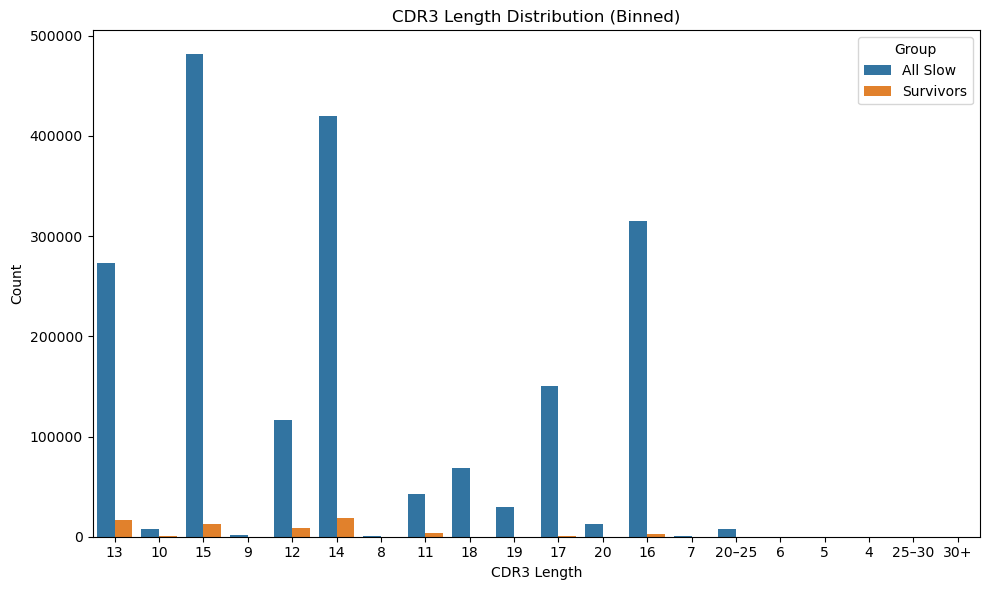

In [19]:
# Create capped length column for all slow CDR3s
def cap_length(l):
    if l <= 20:
        return str(l)
    elif l <= 25:
        return "20–25"
    elif l <= 30:
        return "25–30"
    else:
        return "30+"

# Apply transformation
all_slow_lengths = per_sample_freq[per_sample_freq["group"] == "slow"]["aaSeqCDR3"].drop_duplicates().str.len()
all_slow_bins = all_slow_lengths.map(cap_length)
survivor_bins = survivors["cdr3_length"].map(cap_length)

# Create count DataFrames
bin_df = pd.DataFrame({
    "CDR3 Length Bin": pd.concat([all_slow_bins, survivor_bins], ignore_index=True),
    "Group": ["All Slow"] * len(all_slow_bins) + ["Survivors"] * len(survivor_bins)
})

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=bin_df, x="CDR3 Length Bin", hue="Group")
plt.title("CDR3 Length Distribution (Binned)")
plt.xlabel("CDR3 Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


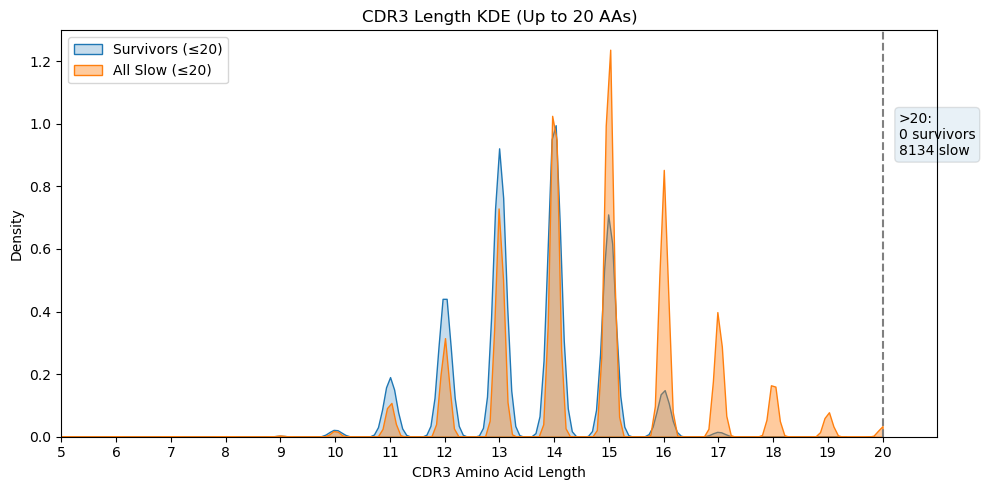

In [20]:
# Filter lengths ≤ 20 for KDE
survivor_kde = survivors[survivors["cdr3_length"] <= 20]["cdr3_length"]
slow_kde = all_slow_lengths[all_slow_lengths <= 20]

# Plot KDE
plt.figure(figsize=(10, 5))
sns.kdeplot(survivor_kde, label="Survivors (≤20)", fill=True, bw_adjust=0.8, clip=(0, 20))
sns.kdeplot(slow_kde, label="All Slow (≤20)", fill=True, alpha=0.4, bw_adjust=0.8, clip=(0, 20))

# Force integer ticks
plt.xticks(ticks=np.arange(5, 21, 1))  # adjust range if needed
plt.xlim(5, 21)

# Tail annotation
tail_survivors = (survivors["cdr3_length"] > 20).sum()
tail_allslow = (all_slow_lengths > 20).sum()
plt.axvline(20, color="gray", linestyle="--")
plt.text(20.3, plt.ylim()[1]*0.8, f">20:\n{tail_survivors} survivors\n{tail_allslow} slow",
         fontsize=10, va="top", bbox=dict(boxstyle="round", alpha=0.1))

plt.title("CDR3 Length KDE (Up to 20 AAs)")
plt.xlabel("CDR3 Amino Acid Length")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


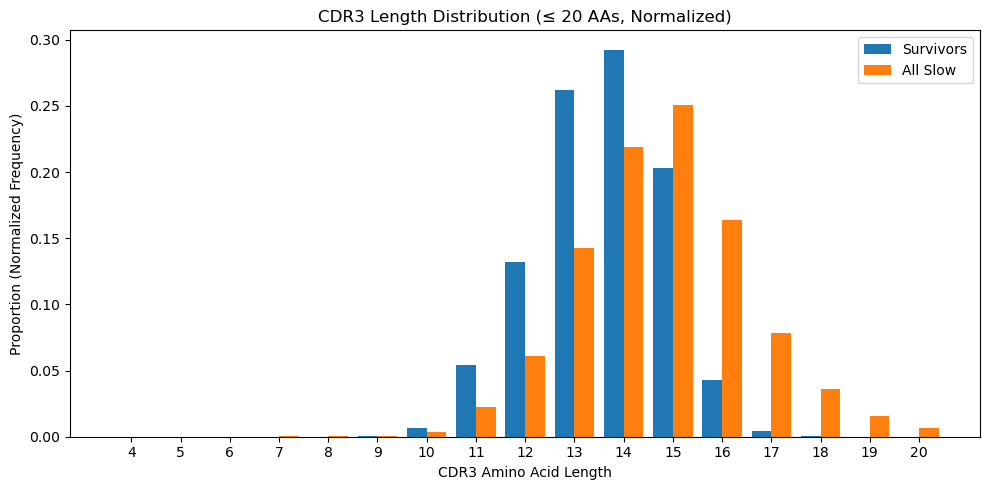

In [21]:
# Filter to lengths ≤ 20
survivor_lengths = survivors[survivors["cdr3_length"] <= 20]["cdr3_length"]
slow_lengths = all_slow_lengths[all_slow_lengths <= 20]

# Combine into one DataFrame
length_df = pd.concat([
    pd.DataFrame({"cdr3_length": survivor_lengths, "Group": "Survivors"}),
    pd.DataFrame({"cdr3_length": slow_lengths, "Group": "All Slow"})
])

# Count CDR3 lengths per group
length_counts = (
    length_df
    .groupby(["Group", "cdr3_length"])
    .size()
    .reset_index(name="count")
)

# Normalize within each group
length_counts["proportion"] = length_counts.groupby("Group")["count"].transform(lambda x: x / x.sum())

# Pivot for plotting
length_pivot = length_counts.pivot(index="cdr3_length", columns="Group", values="proportion").fillna(0)

# Plot
plt.figure(figsize=(10, 5))
bar_width = 0.4
x = np.arange(length_pivot.index.min(), length_pivot.index.max() + 1)

# Align values with available lengths
survivor_vals = length_pivot["Survivors"].reindex(x, fill_value=0)
slow_vals = length_pivot["All Slow"].reindex(x, fill_value=0)

plt.bar(x - bar_width/2, survivor_vals, width=bar_width, label="Survivors")
plt.bar(x + bar_width/2, slow_vals, width=bar_width, label="All Slow")

plt.xticks(ticks=x)
plt.xlabel("CDR3 Amino Acid Length")
plt.ylabel("Proportion (Normalized Frequency)")
plt.title("CDR3 Length Distribution (≤ 20 AAs, Normalized)")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# Count unique TCRs (aaSeqCDR3) with CDR3 length ≤ 20 in each group
n_survivors = survivors[survivors["cdr3_length"] <= 20]["aaSeqCDR3"].nunique()
n_allslow = all_slow_lengths[all_slow_lengths <= 20].shape[0]

print(f"Number of surviving TCRs (length ≤ 20): {n_survivors}, Any length: {survivors['aaSeqCDR3'].nunique()}")
print(f"Number of all slow TCRs (length ≤ 20): {n_allslow}, Any length: {all_slow_lengths.shape[0]}")


Number of surviving TCRs (length ≤ 20): 62410, Any length: 62410
Number of all slow TCRs (length ≤ 20): 1921728, Any length: 1929862


can we infer from above plot that survivors TCRs tend to be shorter, or my criterion (>= 3 samples) caused it? lets check.

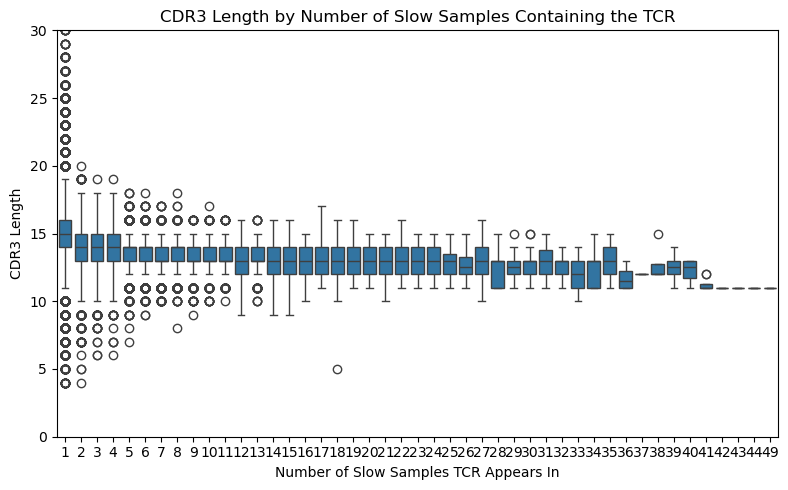

In [23]:
# Count in how many slow samples each TCR appears
slow_group = per_sample_freq[per_sample_freq["group"] == "slow"]
cdr3_sample_counts = slow_group.groupby("aaSeqCDR3")["Sample_ID"].nunique().reset_index(name="n_samples")

# Merge with length info
cdr3_sample_counts["cdr3_length"] = cdr3_sample_counts["aaSeqCDR3"].str.len()

# Plot: Number of samples vs CDR3 length
plt.figure(figsize=(8, 5))
sns.boxplot(data=cdr3_sample_counts, x="n_samples", y="cdr3_length")
plt.title("CDR3 Length by Number of Slow Samples Containing the TCR")
plt.xlabel("Number of Slow Samples TCR Appears In")
plt.ylabel("CDR3 Length")
plt.tight_layout()
plt.ylim(0, 30)
plt.show()


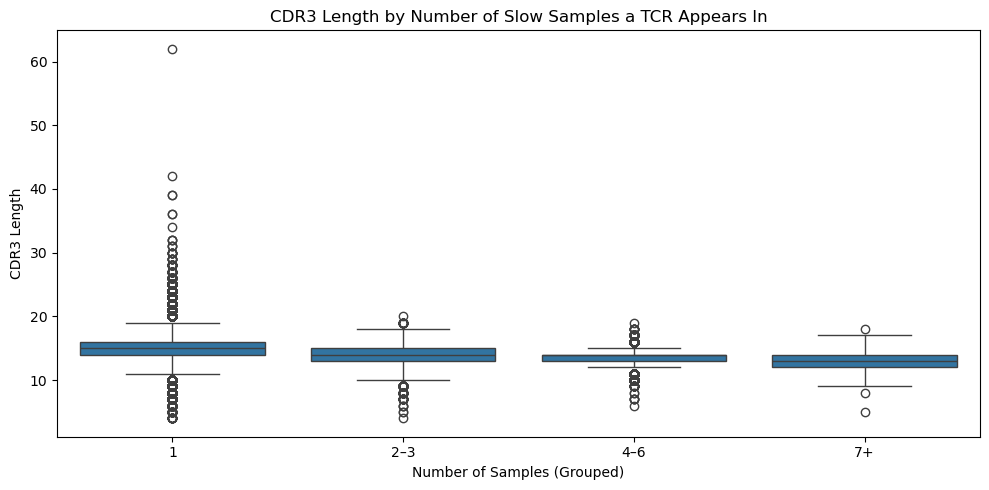

In [24]:
# Step 1: Count in how many slow samples each TCR appears
slow_group = per_sample_freq[per_sample_freq["group"] == "slow"]
cdr3_counts = (
    slow_group.groupby("aaSeqCDR3")["Sample_ID"]
    .nunique()
    .reset_index(name="n_samples")
)

# Step 2: Add CDR3 length
cdr3_counts["cdr3_length"] = cdr3_counts["aaSeqCDR3"].str.len()

# Step 3: Assign to bins based on number of samples
def bin_sample_count(n):
    if n == 1:
        return "1"
    elif n <= 3:
        return "2–3"
    elif n <= 6:
        return "4–6"
    else:
        return "7+"

cdr3_counts["sample_bin"] = cdr3_counts["n_samples"].apply(bin_sample_count)

# Step 4: Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=cdr3_counts, x="sample_bin", y="cdr3_length", order=["1", "2–3", "4–6", "7+"])
plt.title("CDR3 Length by Number of Slow Samples a TCR Appears In")
plt.xlabel("Number of Samples (Grouped)")
plt.ylabel("CDR3 Length")
plt.tight_layout()
plt.show()


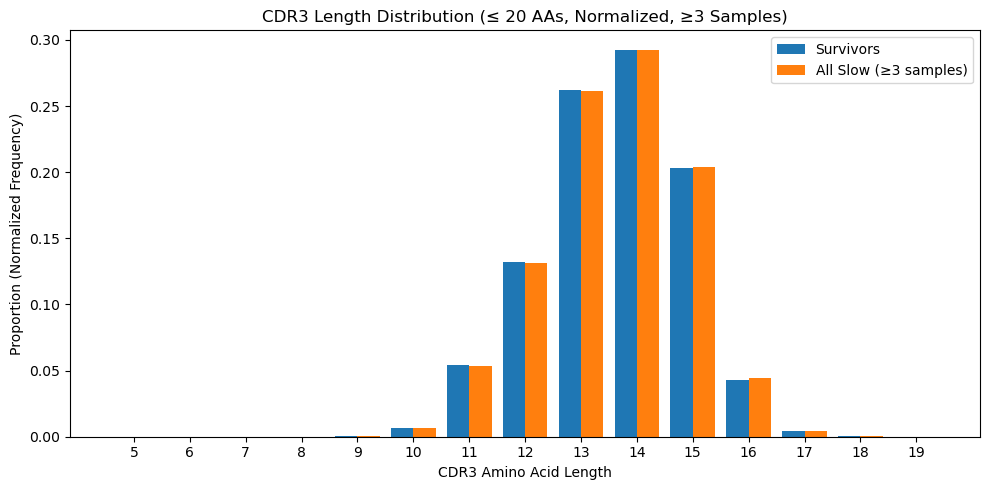

In [25]:
# Step 1: Get TCRs from slow group that appear in ≥3 samples
slow_group = per_sample_freq[per_sample_freq["group"] == "slow"]
slow_tcr_sample_counts = slow_group.groupby("aaSeqCDR3")["Sample_ID"].nunique().reset_index(name="n_samples")
slow_tcr_3plus = slow_tcr_sample_counts[slow_tcr_sample_counts["n_samples"] >= 3]["aaSeqCDR3"]

# Step 2: Filter slow group by these TCRs and calculate length
filtered_slow_lengths = (
    slow_group[slow_group["aaSeqCDR3"].isin(slow_tcr_3plus)]["aaSeqCDR3"]
    .drop_duplicates()
    .str.len()
)
filtered_slow_lengths = filtered_slow_lengths[filtered_slow_lengths <= 20]

# Step 3: Also filter survivors by length ≤ 20
survivor_lengths = survivors[survivors["cdr3_length"] <= 20]["cdr3_length"]

# Step 4: Combine into one DataFrame
length_df = pd.concat([
    pd.DataFrame({"cdr3_length": survivor_lengths, "Group": "Survivors"}),
    pd.DataFrame({"cdr3_length": filtered_slow_lengths, "Group": "All Slow (≥3 samples)"})
])

# Step 5: Count and normalize
length_counts = (
    length_df
    .groupby(["Group", "cdr3_length"])
    .size()
    .reset_index(name="count")
)
length_counts["proportion"] = length_counts.groupby("Group")["count"].transform(lambda x: x / x.sum())

# Step 6: Pivot for plotting
length_pivot = length_counts.pivot(index="cdr3_length", columns="Group", values="proportion").fillna(0)

# Step 7: Plot
plt.figure(figsize=(10, 5))
bar_width = 0.4
x = np.arange(length_pivot.index.min(), length_pivot.index.max() + 1)

# Reindex so all bars align
survivor_vals = length_pivot["Survivors"].reindex(x, fill_value=0)
slow_vals = length_pivot["All Slow (≥3 samples)"].reindex(x, fill_value=0)

plt.bar(x - bar_width/2, survivor_vals, width=bar_width, label="Survivors")
plt.bar(x + bar_width/2, slow_vals, width=bar_width, label="All Slow (≥3 samples)")

plt.xticks(ticks=x)
plt.xlabel("CDR3 Amino Acid Length")
plt.ylabel("Proportion (Normalized Frequency)")
plt.title("CDR3 Length Distribution (≤ 20 AAs, Normalized, ≥3 Samples)")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# Count number of unique TCRs (length ≤ 20) in each group
n_survivors = survivor_lengths.shape[0]
n_filtered_slow = filtered_slow_lengths.shape[0]

print(f"Number of surviving TCRs (length ≤ 20): {n_survivors}")
print(f"Number of slow TCRs (length ≤ 20, in ≥3 samples): {n_filtered_slow}")

# Extract TCR sets
survivor_tcrs = set(survivors[survivors["cdr3_length"] <= 20]["aaSeqCDR3"])
slow_3plus_tcrs = set(
    slow_group[slow_group["aaSeqCDR3"].isin(slow_tcr_3plus)]["aaSeqCDR3"]
    .drop_duplicates()
)

# Intersect
shared = survivor_tcrs & slow_3plus_tcrs
only_slow = slow_3plus_tcrs - survivor_tcrs
only_survivor = survivor_tcrs - slow_3plus_tcrs

# Print results
print(f"Shared TCRs: {len(shared)}")
print(f"TCRs only in slow group (≥3 samples): {len(only_slow)}")
print(f"TCRs only in survivors: {len(only_survivor)}")


Number of surviving TCRs (length ≤ 20): 62410
Number of slow TCRs (length ≤ 20, in ≥3 samples): 63314
Shared TCRs: 62410
TCRs only in slow group (≥3 samples): 904
TCRs only in survivors: 0


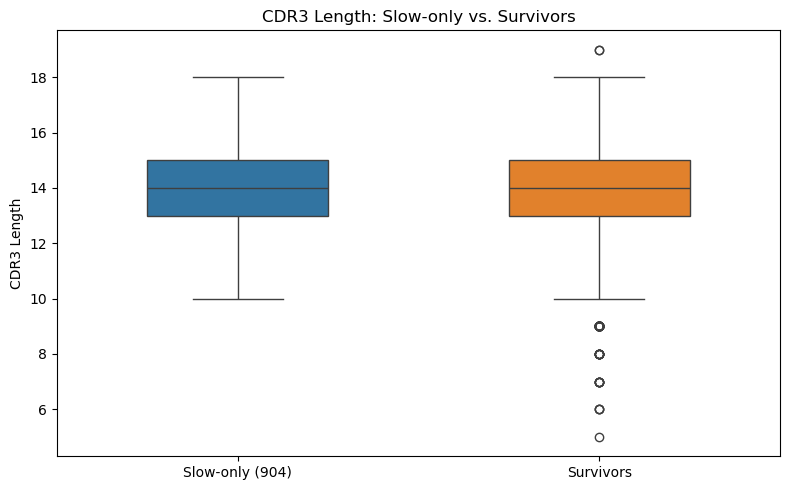

Point 2 — Mann-Whitney U Test (Slow-only vs Survivors):
p-value = 1.4939e-27
Mean length (slow-only): 14.06
Mean length (survivors): 13.58



In [27]:
from scipy.stats import mannwhitneyu

# -----------------------------
# Point 2: Analyze the 904 slow-only TCRs
# -----------------------------
# Filter 904 slow-only TCRs
slow_only_tcrs = list(only_slow)

# Get lengths of slow-only TCRs
slow_only_lengths = (
    slow_group[slow_group["aaSeqCDR3"].isin(slow_only_tcrs)]["aaSeqCDR3"]
    .drop_duplicates()
    .str.len()
)
slow_only_lengths = slow_only_lengths[slow_only_lengths <= 20]  # match survivor length cap

# Get survivor lengths again (already filtered to ≤20 earlier)
survivor_lengths = survivors[survivors["cdr3_length"] <= 20]["cdr3_length"]

# Plot comparison
plt.figure(figsize=(8, 5))
sns.boxplot(data=[slow_only_lengths, survivor_lengths], width=0.5)
plt.xticks([0, 1], ["Slow-only (904)", "Survivors"])
plt.ylabel("CDR3 Length")
plt.title("CDR3 Length: Slow-only vs. Survivors")
plt.tight_layout()
plt.show()

# Mann-Whitney U test
stat, pval = mannwhitneyu(slow_only_lengths, survivor_lengths, alternative="two-sided")
print(f"Point 2 — Mann-Whitney U Test (Slow-only vs Survivors):")
print(f"p-value = {pval:.4e}")
print(f"Mean length (slow-only): {slow_only_lengths.mean():.2f}")
print(f"Mean length (survivors): {survivor_lengths.mean():.2f}")
print()


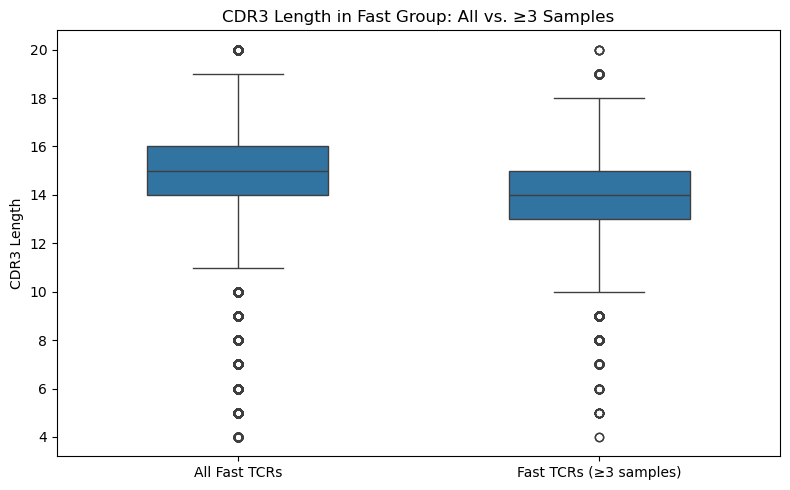

Mean length (All Fast TCRs): 14.91
Mean length (Fast TCRs ≥3 samples): 13.87
Mann–Whitney U test p-value: 0.0000e+00


In [28]:
# -----------------------------
# Point 3: Does the ≥3 sample filter bias fast group too?
# -----------------------------
# Get fast group
fast_group = per_sample_freq[per_sample_freq["group"] == "fast"]

# Count in how many fast samples each TCR appears
fast_sample_counts = fast_group.groupby("aaSeqCDR3")["Sample_ID"].nunique().reset_index(name="n_samples")
fast_sample_counts["cdr3_length"] = fast_sample_counts["aaSeqCDR3"].str.len()

# Filter to ≤20
fast_sample_counts = fast_sample_counts[fast_sample_counts["cdr3_length"] <= 20]
# Extract just the lengths
fast_all_lengths = fast_sample_counts["cdr3_length"]
fast_3plus_lengths = fast_sample_counts[fast_sample_counts["n_samples"] >= 3]["cdr3_length"]

# Combine into DataFrame for seaborn
compare_df = pd.concat([
    pd.DataFrame({"Group": "All Fast TCRs", "cdr3_length": fast_all_lengths}),
    pd.DataFrame({"Group": "Fast TCRs (≥3 samples)", "cdr3_length": fast_3plus_lengths}),
])

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=compare_df, x="Group", y="cdr3_length", width=0.5)
plt.title("CDR3 Length in Fast Group: All vs. ≥3 Samples")
plt.xlabel("")
plt.ylabel("CDR3 Length")
plt.tight_layout()
plt.show()

print(f"Mean length (All Fast TCRs): {fast_all_lengths.mean():.2f}")
print(f"Mean length (Fast TCRs ≥3 samples): {fast_3plus_lengths.mean():.2f}")

from scipy.stats import mannwhitneyu
stat, pval = mannwhitneyu(fast_all_lengths, fast_3plus_lengths, alternative="two-sided")
print(f"Mann–Whitney U test p-value: {pval:.4e}")


In [29]:
n_total_fast = fast_sample_counts.shape[0]
n_fast_3plus = fast_sample_counts[fast_sample_counts["n_samples"] >= 3].shape[0]

print(f"Number of fast TCRs (≤20 AAs): {n_total_fast}")
print(f"Number of fast TCRs in ≥3 samples (≤20 AAs): {n_fast_3plus}")


Number of fast TCRs (≤20 AAs): 8943196
Number of fast TCRs in ≥3 samples (≤20 AAs): 521891


### Biochemical properties

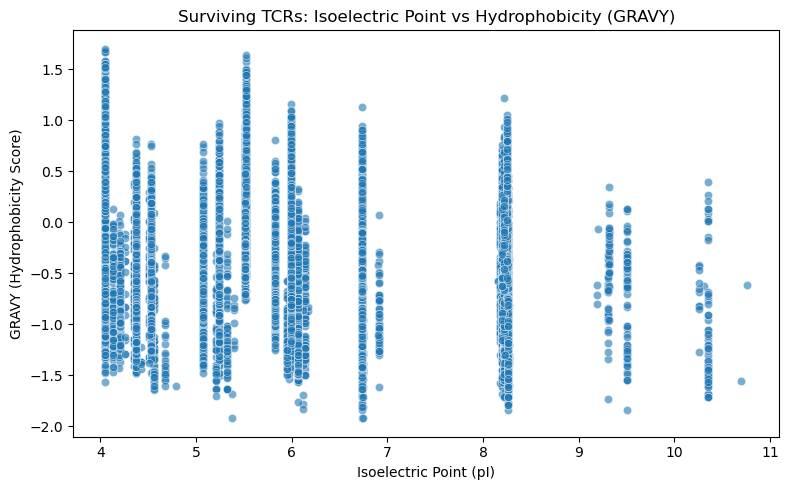

In [30]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def analyze_sequence(seq):
    try:
        prot = ProteinAnalysis(seq)
        return {
            "length": len(seq),
            "aromaticity": prot.aromaticity(),
            "instability_index": prot.instability_index(),
            "isoelectric_point": prot.isoelectric_point(),
            "gravy": prot.gravy(),  # Hydrophobicity
            "charge": prot.charge_at_pH(7.0)
        }
    except:
        return {k: np.nan for k in ["length", "aromaticity", "instability_index", "isoelectric_point", "gravy", "charge"]}

# Apply to survivors
biochem_df = pd.DataFrame([analyze_sequence(seq) for seq in survivors["aaSeqCDR3"]])
survivors = pd.concat([survivors.reset_index(drop=True), biochem_df], axis=1)

# Example: plot isoelectric point and GRAVY
plt.figure(figsize=(8, 5))
sns.scatterplot(data=survivors, x="isoelectric_point", y="gravy", alpha=0.6)
plt.title("Surviving TCRs: Isoelectric Point vs Hydrophobicity (GRAVY)")
plt.xlabel("Isoelectric Point (pI)")
plt.ylabel("GRAVY (Hydrophobicity Score)")
plt.tight_layout()
plt.show()

🧪 1. Aromaticity
Definition: Proportion of aromatic amino acids (Phe, Trp, Tyr) in the sequence.

Importance: Aromatic residues contribute to protein stability, stacking interactions, and antigen recognition.

Typical range: ~0.05–0.15

Interpretation: Higher aromaticity can indicate stable, structured TCRs.

🧪 2. Instability Index
Definition: Predicts in vitro protein stability based on dipeptide composition (Guruprasad et al.).

Importance: Values >40 suggest the protein is unstable; <40 means stable.

Typical threshold:

Stable: < 40

Unstable: > 40

Interpretation: Survivors might be more stable under degradation pressure.

🧪 3. Isoelectric Point (pI)
Definition: The pH at which the net charge of the protein is zero.

Importance: Affects solubility, interaction with other molecules, and degradation.

Typical range: 4.5–10.5 for peptides

Most TCRs: ~6.0–9.0

Interpretation: pI affects charge balance at physiological pH (7.4); extreme values may impact structure or aggregation.

🧪 4. GRAVY (Grand Average of Hydropathy)
Definition: Average hydrophobicity; higher = more hydrophobic.

Importance: Hydrophobicity affects folding, aggregation, membrane interaction.

Typical range:

Hydrophilic: < 0

Hydrophobic: > 0

Most soluble proteins: -0.6 to 0.4

Interpretation: Survivors may be more hydrophilic if they resist degradation better.

🧪 5. Charge at pH 7.0
Definition: Net electric charge of the peptide at physiological pH.

Importance: Influences solubility, binding, and interaction with MHCs or antigens.

Typical range: ~–2 to +5 for TCR-length peptides

Interpretation: Strong charge may promote interaction or solubility; could affect resilience.



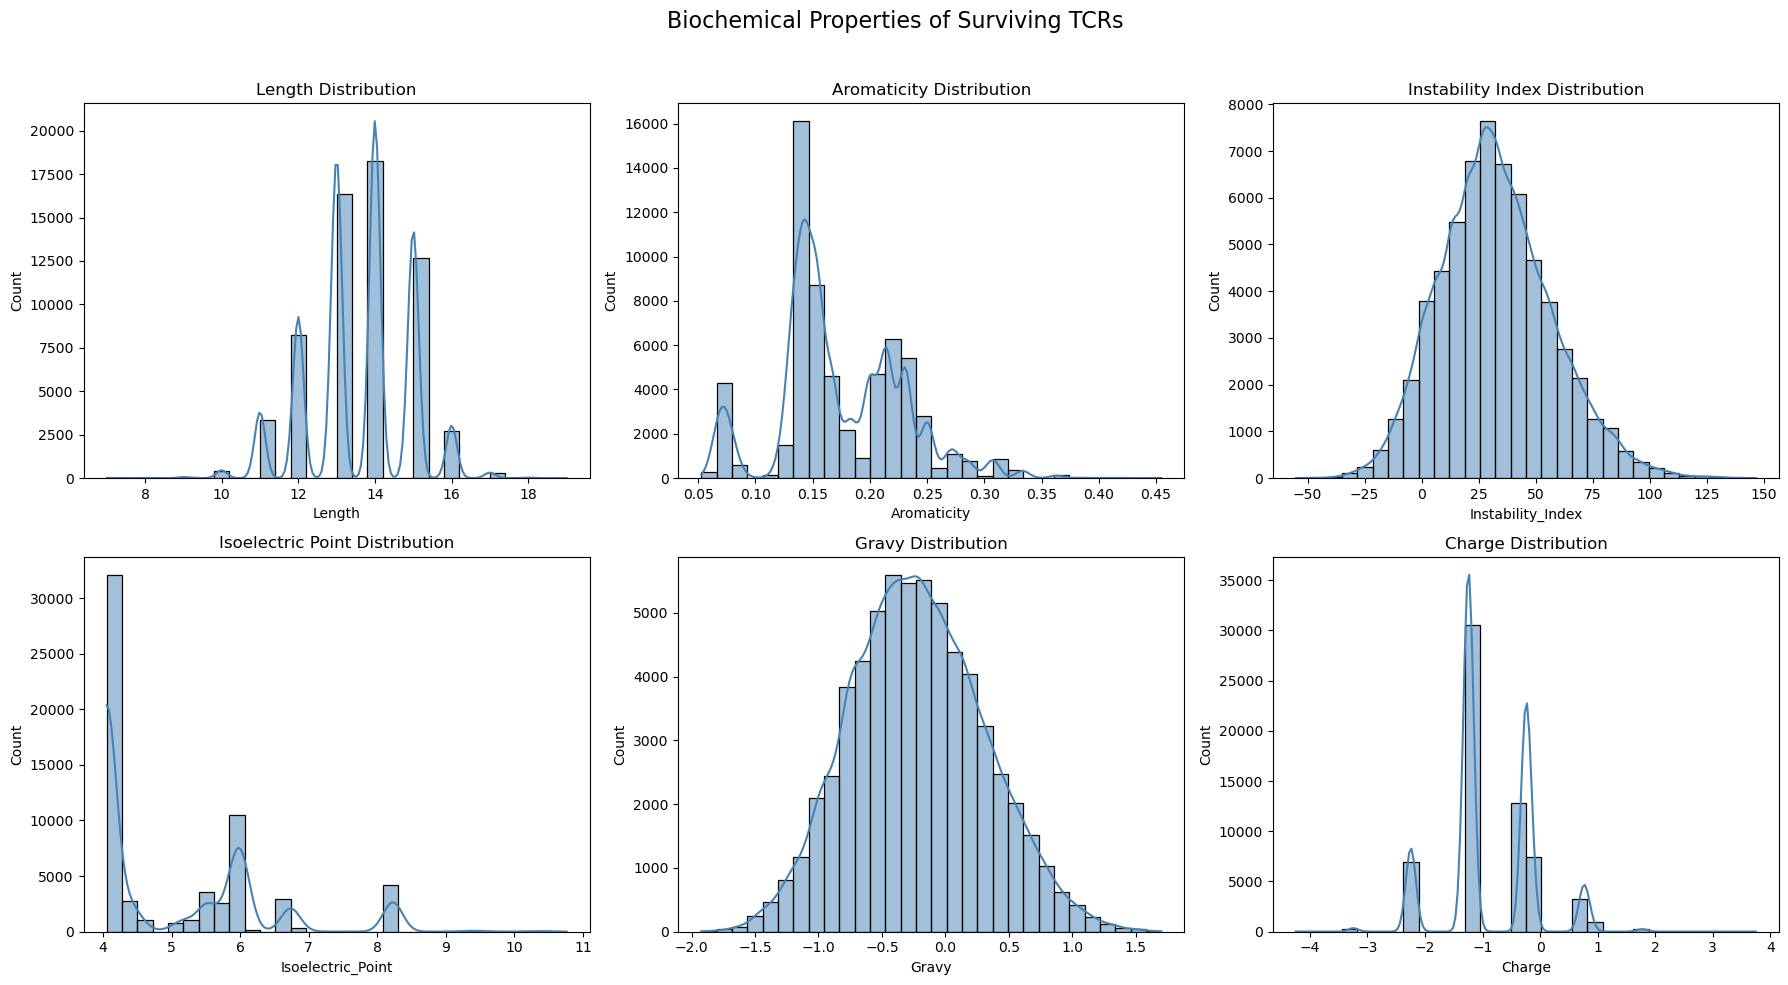

In [31]:
# Plot all properties
biochem_props = ["length", "aromaticity", "instability_index", "isoelectric_point", "gravy", "charge"]
n_props = len(biochem_props)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, prop in enumerate(biochem_props):
    sns.histplot(survivors[prop], kde=True, ax=axes[i], bins=30, color="steelblue")
    axes[i].set_title(f"{prop.replace('_', ' ').title()} Distribution")
    axes[i].set_xlabel(prop.title())
    axes[i].set_ylabel("Count")

plt.suptitle("Biochemical Properties of Surviving TCRs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

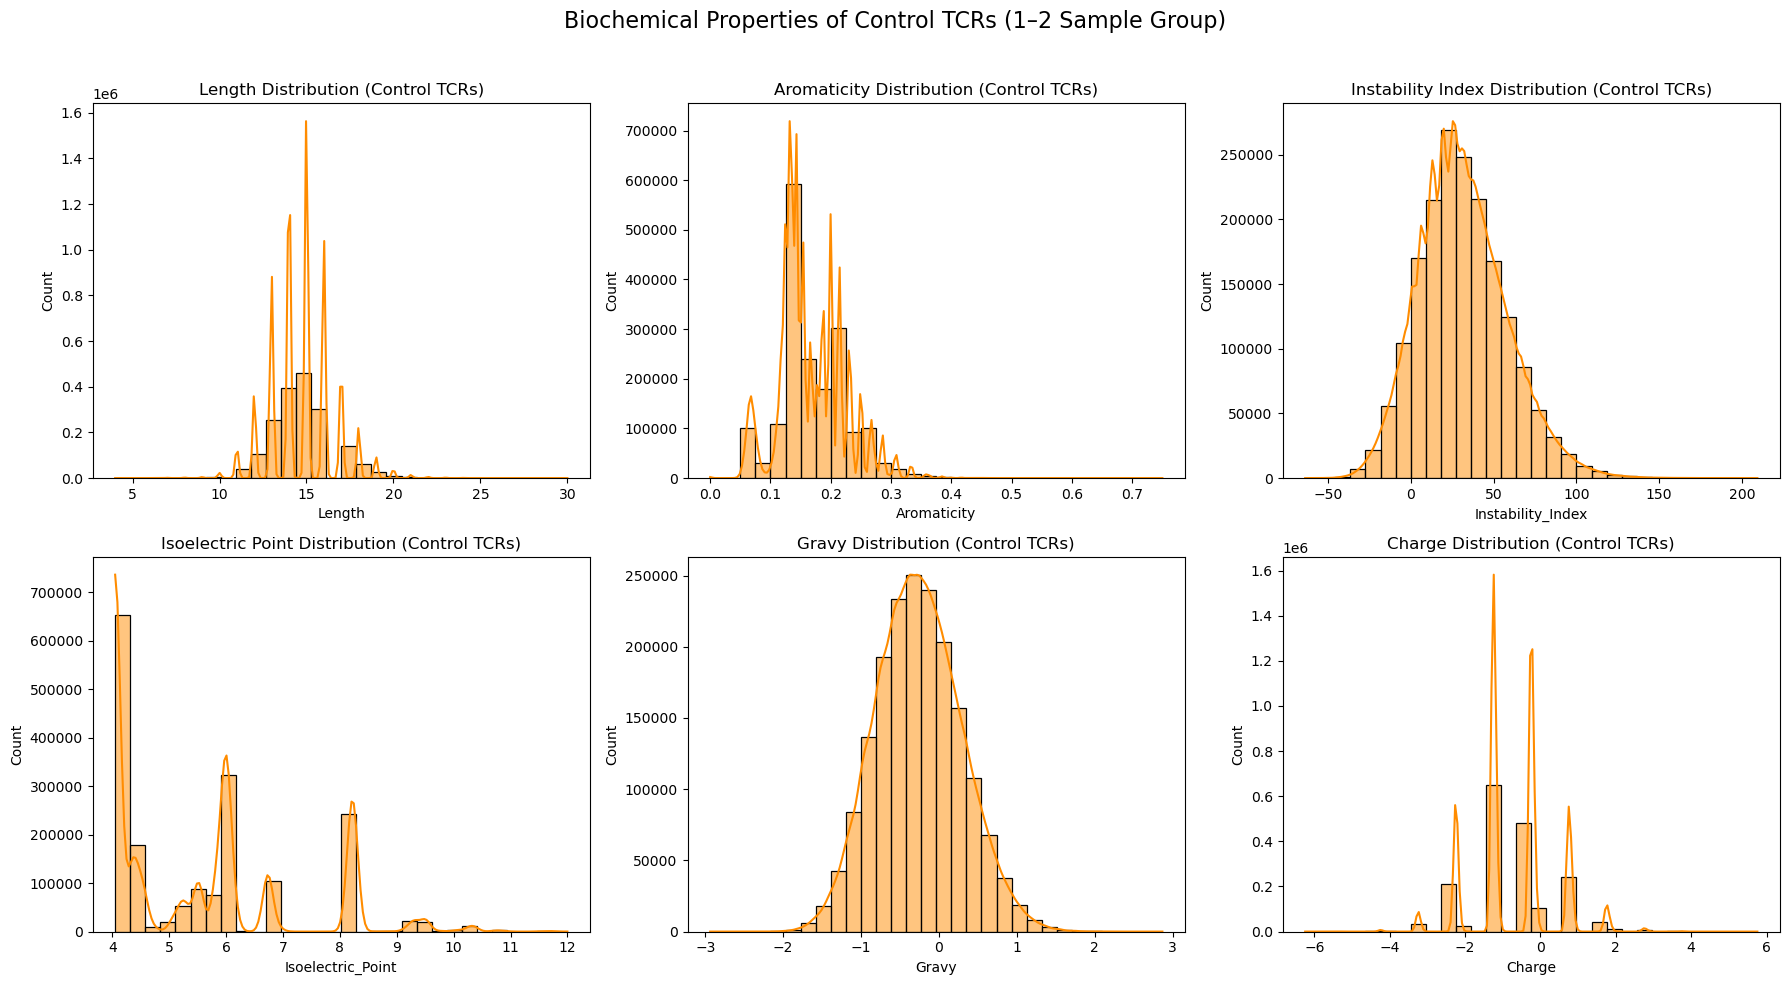

In [32]:
# Get unique CDR3 sequences from control group (slow group, 1–2 samples)
control_cdr3s = slow_counts[slow_counts["aaSeqCDR3"].isin(nonsurvivor_tcrs)]["aaSeqCDR3"].drop_duplicates()

# Run property analysis
control_biochem = pd.DataFrame([analyze_sequence(seq) for seq in control_cdr3s])

# Plot all properties
biochem_props = ["length", "aromaticity", "instability_index", "isoelectric_point", "gravy", "charge"]
n_props = len(biochem_props)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, prop in enumerate(biochem_props):
    sns.histplot(control_biochem[prop], kde=True, ax=axes[i], bins=30, color="darkorange")
    axes[i].set_title(f"{prop.replace('_', ' ').title()} Distribution (Control TCRs)")
    axes[i].set_xlabel(prop.title())
    axes[i].set_ylabel("Count")

plt.suptitle("Biochemical Properties of Control TCRs (1–2 Sample Group)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

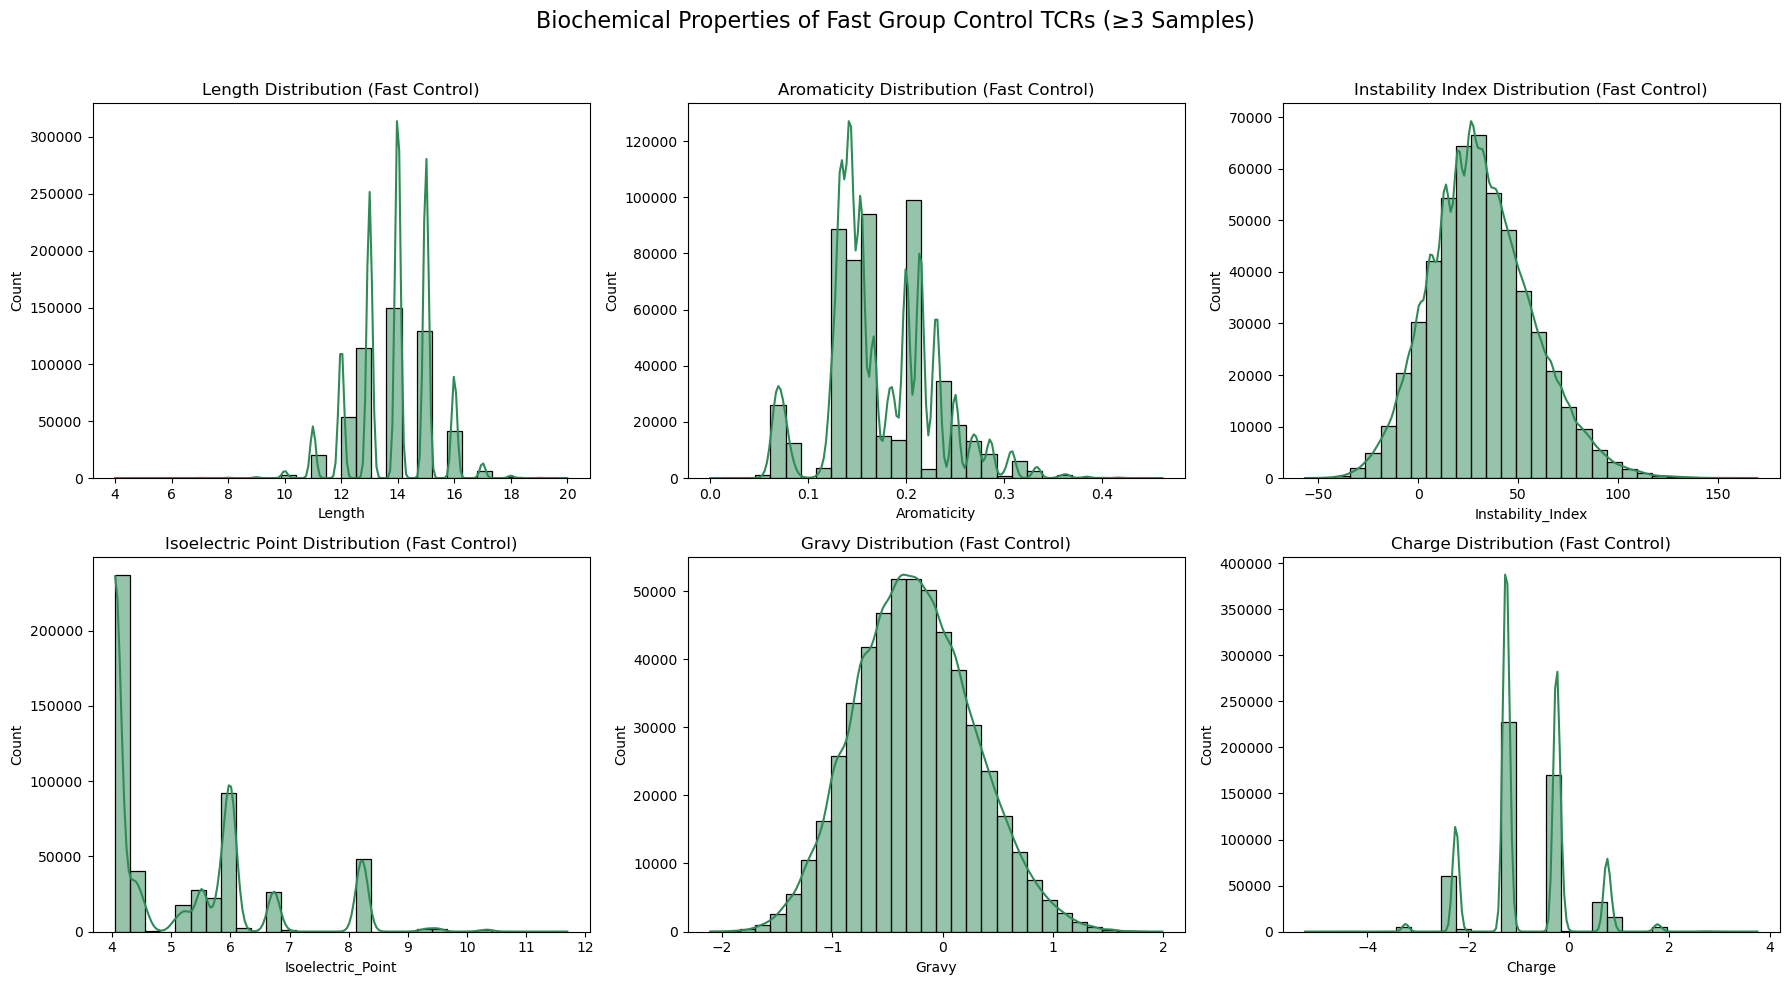

In [33]:
## Control option 2:

# Compute properties
fast_control_biochem = pd.DataFrame([analyze_sequence(seq) for seq in fast_control_cdr3s])

# Plot all properties
biochem_props = ["length", "aromaticity", "instability_index", "isoelectric_point", "gravy", "charge"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, prop in enumerate(biochem_props):
    sns.histplot(fast_control_biochem[prop], kde=True, ax=axes[i], bins=30, color="seagreen")
    axes[i].set_title(f"{prop.replace('_', ' ').title()} Distribution (Fast Control)")
    axes[i].set_xlabel(prop.title())
    axes[i].set_ylabel("Count")

plt.suptitle("Biochemical Properties of Fast Group Control TCRs (≥3 Samples)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [34]:
def plot_normalized_distributions(group1_df, group2_df, label1="Group 1", label2="Group 2"):
    biochem_props = ["length", "aromaticity", "instability_index", "isoelectric_point", "gravy", "charge"]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, prop in enumerate(biochem_props):
        sns.histplot(group1_df[prop], stat="density", kde=True, bins=30, color="steelblue", label=label1, ax=axes[i], alpha=0.6)
        sns.histplot(group2_df[prop], stat="density", kde=True, bins=30, color="darkorange", label=label2, ax=axes[i], alpha=0.6)
        axes[i].set_title(f"{prop.replace('_', ' ').title()} Distribution")
        axes[i].set_xlabel(prop.title())
        axes[i].set_ylabel("Density")
        axes[i].legend()

    plt.suptitle(f"{label1} vs {label2}: Biochemical Property Comparison (Normalized)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


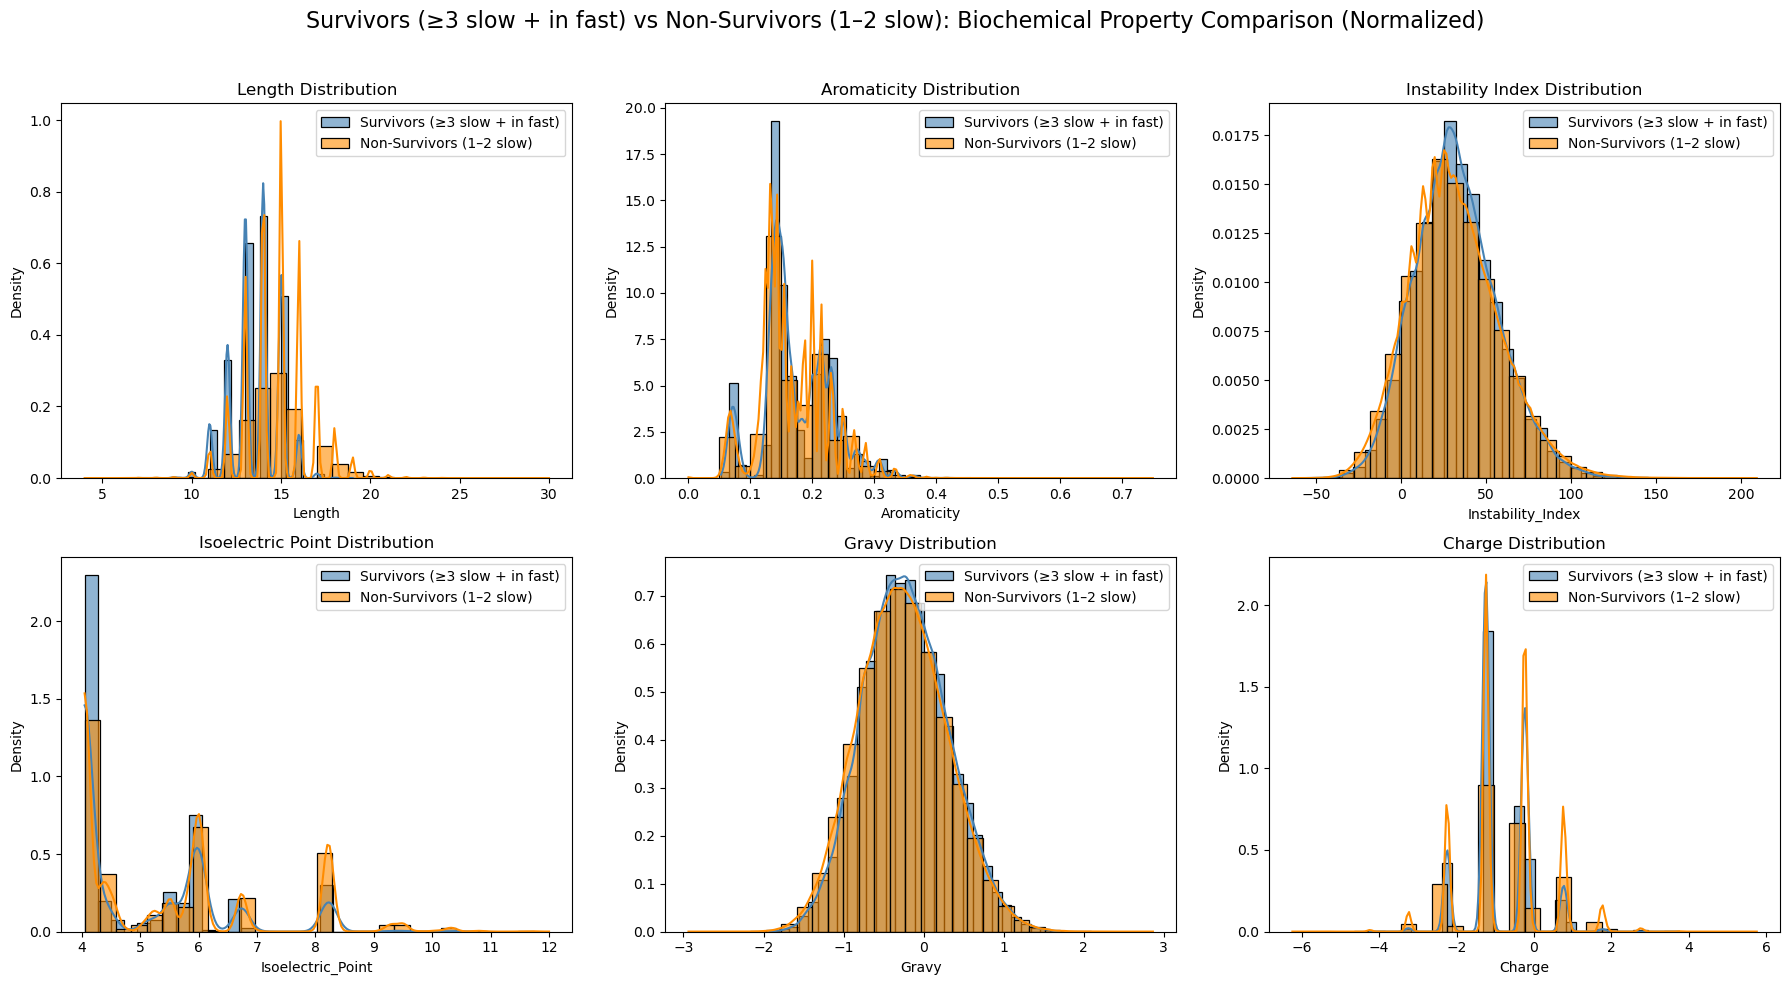

In [35]:
plot_normalized_distributions(
    group1_df=survivors,
    group2_df=control_biochem,
    label1="Survivors (≥3 slow + in fast)",
    label2="Non-Survivors (1–2 slow)"
)

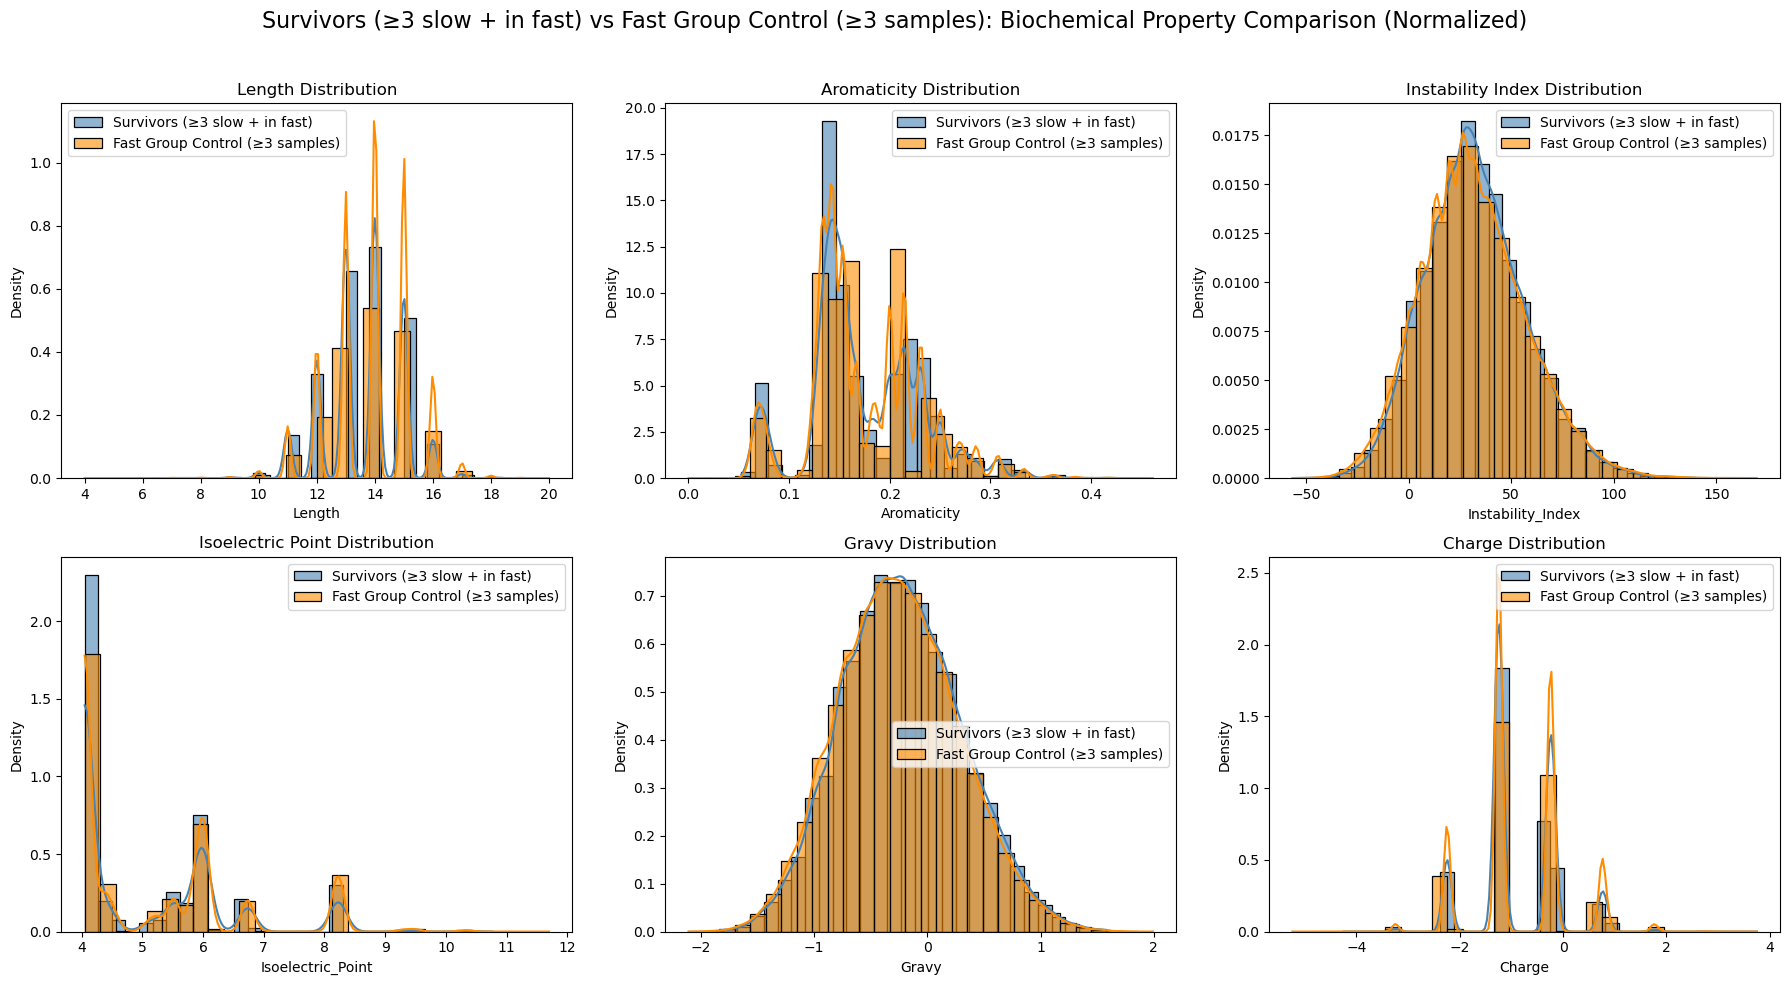

In [36]:
plot_normalized_distributions(
    group1_df=survivors,
    group2_df=fast_control_biochem,
    label1="Survivors (≥3 slow + in fast)",
    label2="Fast Group Control (≥3 samples)"
)


## Clonotype-level comparisons 

In [12]:
# --- Add group labels ---
clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# --- Normalize read counts per sample ---
total_reads = clonotype_df.groupby("Sample_ID")["readCount"].sum().reset_index(name="total_reads")
clonotype_df = clonotype_df.merge(total_reads, on="Sample_ID")
clonotype_df["frequency"] = clonotype_df["readCount"] / clonotype_df["total_reads"]

# --- Average frequency per clonotype per group ---
grouped = (
    clonotype_df.groupby(["aaSeqCDR3", "group"])["frequency"]
    .mean()
    .reset_index()
    .pivot(index="aaSeqCDR3", columns="group", values="frequency")
    .fillna(1e-9)  # small value to avoid div-by-zero
)

# --- Compute log2 fold-change ---
grouped["log2FC_fast_vs_slow"] = np.log2(grouped["fast"] / grouped["slow"])

# --- Optional: Count how many samples each clonotype appears in per group ---
clone_presence = (
    clonotype_df.groupby(["aaSeqCDR3", "group"])["Sample_ID"]
    .nunique()
    .reset_index()
    .pivot(index="aaSeqCDR3", columns="group", values="Sample_ID")
    .fillna(0)
    .astype(int)
    .rename(columns={"fast": "n_fast_samples", "slow": "n_slow_samples"})
)

# --- Merge counts with fold-change ---
foldchange_df = grouped.merge(clone_presence, left_index=True, right_index=True).reset_index()

# Sort by magnitude
foldchange_df = foldchange_df.sort_values("log2FC_fast_vs_slow", ascending=False)

/tmp/ipykernel_618482/682152930.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


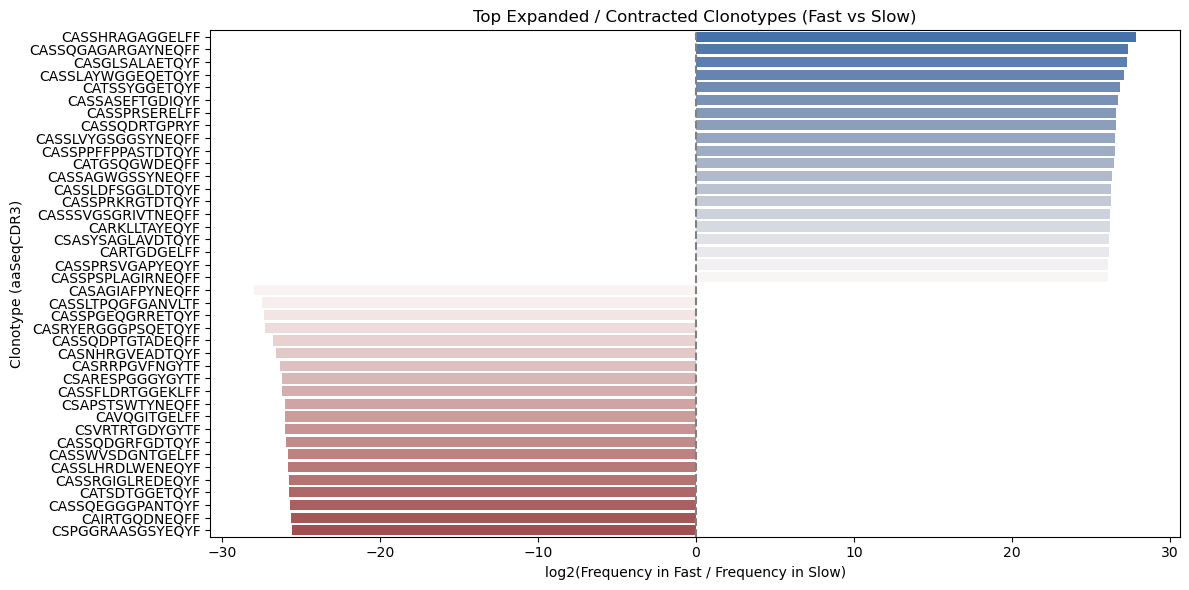

In [13]:
top_n = 20  # adjust as needed

# Top expanded in fast
top_expanded = foldchange_df.sort_values("log2FC_fast_vs_slow", ascending=False).head(top_n)

# Top depleted in fast (i.e., expanded in slow)
top_depleted = foldchange_df.sort_values("log2FC_fast_vs_slow").head(top_n)

# Combine
top_clones = pd.concat([top_expanded, top_depleted])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_clones,
    x="log2FC_fast_vs_slow",
    y="aaSeqCDR3",
    palette="vlag"
)
plt.axvline(0, linestyle="--", color="gray")
plt.title("Top Expanded / Contracted Clonotypes (Fast vs Slow)")
plt.xlabel("log2(Frequency in Fast / Frequency in Slow)")
plt.ylabel("Clonotype (aaSeqCDR3)")
plt.tight_layout()
plt.show()


IS normelized?

TODO: Check for similar motifs (vdj motifs, amino acids motifs) that are unique to each group.maybe logo?
their sized are different. maybe different vdj genes combinations?

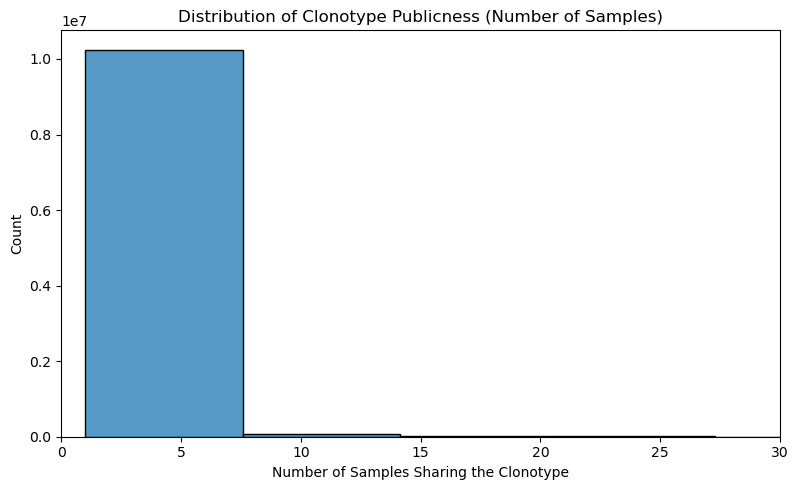

In [14]:
# Add a 'publicness' column
foldchange_df["publicness"] = foldchange_df[["n_fast_samples", "n_slow_samples"]].sum(axis=1)

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(foldchange_df["publicness"], bins=30)
plt.title("Distribution of Clonotype Publicness (Number of Samples)")
plt.xlabel("Number of Samples Sharing the Clonotype")
plt.tight_layout()
plt.xlim(0, 30)
plt.show()


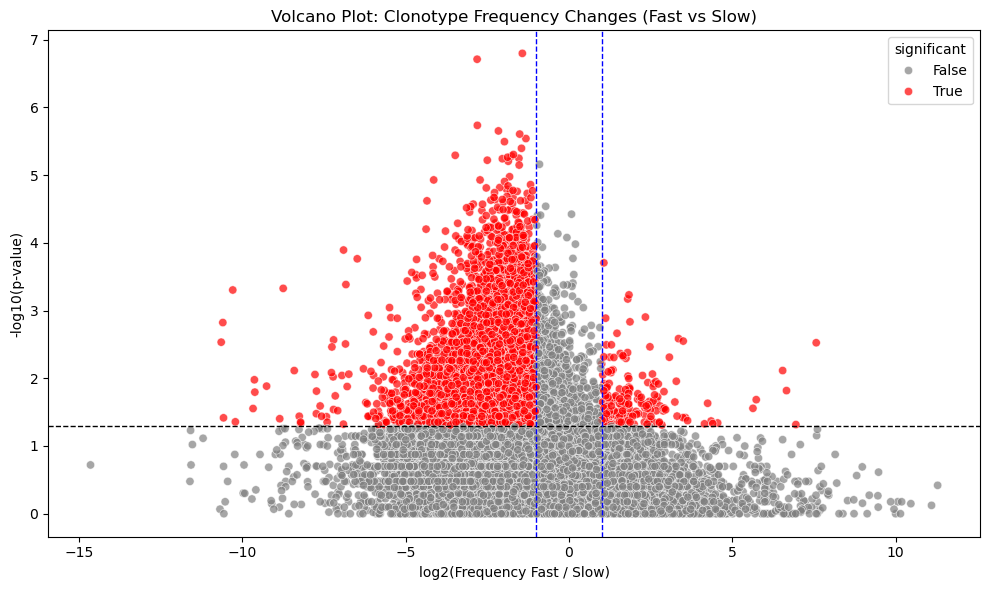

In [ ]:
from scipy.stats import mannwhitneyu

# --- Get frequencies per clonotype per sample ---
per_sample_freq = (
    clonotype_df.groupby(["aaSeqCDR3", "Sample_ID"])["readCount"]
    .sum()
    .reset_index()
)

# Normalize per sample
total_reads = clonotype_df.groupby("Sample_ID")["readCount"].sum().reset_index(name="total_reads")
per_sample_freq = per_sample_freq.merge(total_reads, on="Sample_ID")
per_sample_freq["frequency"] = per_sample_freq["readCount"] / per_sample_freq["total_reads"]

# Add metadata
per_sample_freq = per_sample_freq.merge(meta_df, on="Sample_ID", how="left")
per_sample_freq["group"] = per_sample_freq["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# --- For each clonotype: compute log2FC and p-value ---
results = []

for clone, group_df in per_sample_freq.groupby("aaSeqCDR3"):
    fast_vals = group_df[group_df["group"] == "fast"]["frequency"].values
    slow_vals = group_df[group_df["group"] == "slow"]["frequency"].values

    # To ensure reliability, only analyze clonotypes seen in at least 2 samples per group.
    if len(fast_vals) < 2 or len(slow_vals) < 2:
        continue  # Skip under-sampled clonotypes

    # Compute fold change
    mean_fast = np.mean(fast_vals)
    mean_slow = np.mean(slow_vals)
    log2fc = np.log2((mean_fast + 1e-9) / (mean_slow + 1e-9))

    # Mann–Whitney U test (non-parametric)
    stat, pval = mannwhitneyu(fast_vals, slow_vals, alternative="two-sided")

    results.append({
        "aaSeqCDR3": clone,
        "log2FC": log2fc,
        "pval": pval,
        "mean_fast": mean_fast,
        "mean_slow": mean_slow,
        "n_fast": len(fast_vals),
        "n_slow": len(slow_vals)
    })

# --- Build DataFrame ---
volcano_df = pd.DataFrame(results)
volcano_df["-log10_pval"] = -np.log10(volcano_df["pval"])
volcano_df["significant"] = (volcano_df["pval"] < 0.05) & (np.abs(volcano_df["log2FC"]) > 1)

# --- Volcano Plot ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volcano_df,
    x="log2FC",
    y="-log10_pval",
    hue="significant",
    palette={True: "red", False: "gray"},
    alpha=0.7
)
plt.axhline(-np.log10(0.05), linestyle="--", color="black", linewidth=1)
plt.axvline(1, linestyle="--", color="blue", linewidth=1)
plt.axvline(-1, linestyle="--", color="blue", linewidth=1)
plt.title("Volcano Plot: Clonotype Frequency Changes (Fast vs Slow)")
plt.xlabel("log2(Frequency Fast / Slow)")
plt.ylabel("-log10(p-value)")
plt.tight_layout()
plt.show()

Each dot = a unique clonotype (aaSeqCDR3) 
red dot: that pass both: pvalus < 0.05 and |log2FC| > 1 (i.e., ≥2-fold change up or down), meaning They are statistically significant and biologically meaningful differences.
grey dot: did not pass either threshold.
x-axis (log2FC) = log2 fold change of clonotype frequency in fast vs slow group

if > 0: clonotype is more abundant in fast group

if < 0: clonotype is more abundant in slow group

0: equal in both

y-axis (-log10(p-value)) = how statistically significant the difference is

higher = more significant (smaller p-value)



<Axes: xlabel='group', ylabel='frequency'>

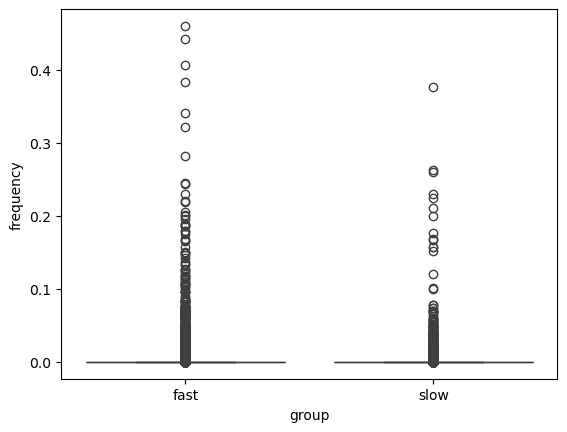

In [16]:
sns.boxplot(data=per_sample_freq, x="group", y="frequency")


## Scirpy - analyzing repertoire difference via extraction time

In [11]:
import scirpy as ir
import pandas as pd
import anndata as ad

/home/dsi/orrbavly/miniconda3/envs/scirpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


Load previously loaded fast, slow groups to scirpy format.

In [12]:
# --- Build AIRR-like DataFrame for fast samples ---
fast_entries = []
for idx, row in fast_group.iterrows():
    fast_entries.append({
        "cell_id": f"{row['Sample_ID']}_{idx}",  # unique id
        "locus": "TRB",
        "junction_aa": row["aaSeqCDR3"],
        "productive": True,
        "duplicate_count": row["readCount"],
        "sample_id": row["Sample_ID"],  # save sample for grouping later
        "extraction_time": row["extraction_time"]  # optional metadata
    })

fast_df = pd.DataFrame(fast_entries)

# --- Build AIRR-like DataFrame for slow samples ---
slow_entries = []
for idx, row in slow_group.iterrows():
    slow_entries.append({
        "cell_id": f"{row['Sample_ID']}_{idx}",
        "locus": "TRB",
        "junction_aa": row["aaSeqCDR3"],
        "productive": True,
        "duplicate_count": row["readCount"],
        "sample_id": row["Sample_ID"],
        "extraction_time": row["extraction_time"]
    })

slow_df = pd.DataFrame(slow_entries)

In [35]:
fast_adata = ir.io.read_airr(
    fast_df,
    cell_attributes=["sample_id", "extraction_time", "junction_aa"]
)

slow_adata = ir.io.read_airr(
    slow_df,
    cell_attributes=["sample_id", "extraction_time", "junction_aa"]
)
fast_adata.obs["group"] = "fast"
slow_adata.obs["group"] = "slow"

In [40]:
print(fast_adata.obs.columns)
print(fast_adata.shape)

Index(['extraction_time', 'junction_aa', 'sample_id', 'group',
       'shannon_junction_aa'],
      dtype='object')
(12982717, 0)


### Shannon diversity 

In [39]:
ir.tl.alpha_diversity(
    fast_adata,
    groupby="sample_id",
    target_col="junction_aa",  # <- KEY addition
    metric="shannon"
)

ir.tl.alpha_diversity(
    slow_adata,
    groupby="sample_id",
    target_col="junction_aa",
    metric="shannon"
)

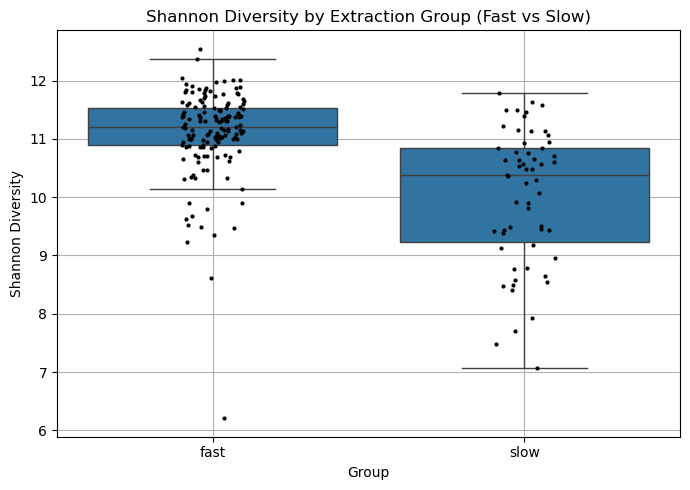

In [42]:
# Aggregate diversity scores per sample
fast_div = (
    fast_adata.obs.groupby("sample_id")
    .agg({
        "extraction_time": "first",
        "shannon_junction_aa": "mean",  # could also be 'first', since it's identical per sample
        "group": "first"
    })
    .reset_index()
)

slow_div = (
    slow_adata.obs.groupby("sample_id")
    .agg({
        "extraction_time": "first",
        "shannon_junction_aa": "mean",
        "group": "first"
    })
    .reset_index()
)

# Combine
diversity_df = pd.concat([fast_div, slow_div], ignore_index=True)
diversity_df = diversity_df.rename(columns={"shannon_junction_aa": "shannon_diversity"})

plt.figure(figsize=(7, 5))
sns.boxplot(x="group", y="shannon_diversity", data=diversity_df, showfliers=False)
sns.stripplot(x="group", y="shannon_diversity", data=diversity_df, color="black", size=3, jitter=True)
plt.title("Shannon Diversity by Extraction Group (Fast vs Slow)")
plt.ylabel("Shannon Diversity")
plt.xlabel("Group")
plt.grid(True)
plt.tight_layout()
plt.show()


Shannon diversity measures:

How broad the immune response is

Whether the TCR repertoire is dominated by a few clonotypes (low diversity)

Or is diverse and evenly expressed (high diversity)

In [44]:
from scipy.stats import mannwhitneyu

fast_vals = diversity_df[diversity_df["group"] == "fast"]["shannon_diversity"]
slow_vals = diversity_df[diversity_df["group"] == "slow"]["shannon_diversity"]

stat, p = mannwhitneyu(fast_vals, slow_vals, alternative="two-sided")
print(f"Mann-Whitney U test p-value: {p}")


Mann-Whitney U test p-value: 6.495141152701467e-12


Spearman correlation: rho = -0.349, p = 0.0000


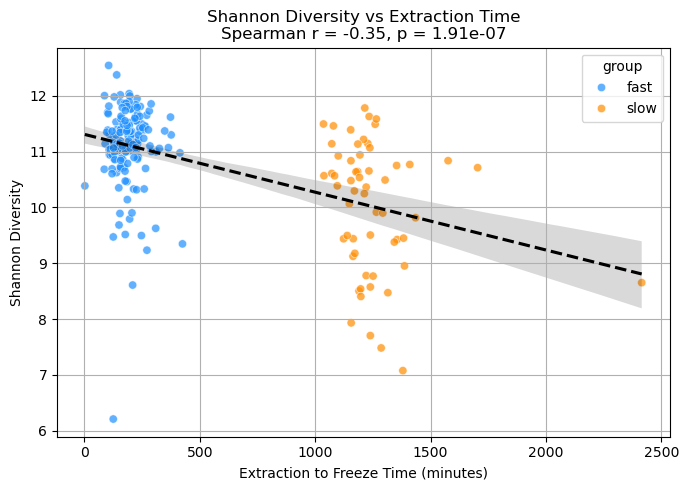

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Compute Spearman correlation
rho, pval = spearmanr(diversity_df["extraction_time"], diversity_df["shannon_diversity"])
print(f"Spearman correlation: rho = {rho:.3f}, p = {pval:.4f}")

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=diversity_df,
    x="extraction_time",
    y="shannon_diversity",
    hue="group",
    palette={"fast": "dodgerblue", "slow": "darkorange"},
    alpha=0.7
)
sns.regplot(
    data=diversity_df,
    x="extraction_time",
    y="shannon_diversity",
    scatter=False,
    color="black",
    line_kws={"linestyle": "dashed"}
)
plt.title(f"Shannon Diversity vs Extraction Time\nSpearman r = {rho:.2f}, p = {pval:.3g}")
plt.xlabel("Extraction to Freeze Time (minutes)")
plt.ylabel("Shannon Diversity")
plt.grid(True)
plt.tight_layout()
plt.show()


fast group has higher shanon entropy, that suggets more clonotype diversity, and more balanced read fraction

### Dominance analysis

How dominant is the top clone per sample?
Lets measure whether slower freezing leads to skewed repertoires dominated by one or few clones.


In [48]:
# 1. Top clonotype read count per sample
dominance_df = (
    clonotype_df.groupby(["Sample_ID", "aaSeqCDR3"])["readCount"]
    .sum()
    .reset_index()
    .sort_values(["Sample_ID", "readCount"], ascending=[True, False])
    .groupby("Sample_ID")
    .first()
    .reset_index()
    .rename(columns={"readCount": "top_clone_reads"})
)

# 2. Total reads per sample
total_reads_df = (
    clonotype_df.groupby("Sample_ID")["readCount"]
    .sum()
    .reset_index()
    .rename(columns={"readCount": "total_reads"})
)

# 3. Merge and compute normalized dominance
dominance_df = dominance_df.merge(total_reads_df, on="Sample_ID", how="left")
dominance_df["dominance_fraction"] = dominance_df["top_clone_reads"] / dominance_df["total_reads"]

# 4. Add group info
dominance_df = dominance_df.merge(meta_df, on="Sample_ID", how="left")
dominance_df["group"] = dominance_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")


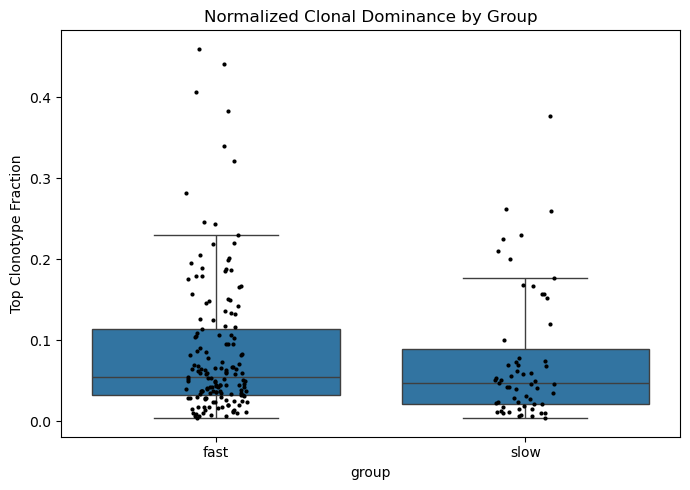

In [49]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=dominance_df, x="group", y="dominance_fraction", showfliers=False)
sns.stripplot(data=dominance_df, x="group", y="dominance_fraction", color="black", size=3, jitter=True)
plt.ylabel("Top Clonotype Fraction")
plt.title("Normalized Clonal Dominance by Group")
plt.tight_layout()
plt.show()

y-axis: 
It is the fraction of total reads that came from the single most abundant (top) clonotype in each sample.

shows less variance in fast group samples compared to slow samples.

/tmp/ipykernel_515560/2653046378.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["readCount"].head(top_n).sum() / g["readCount"].sum())


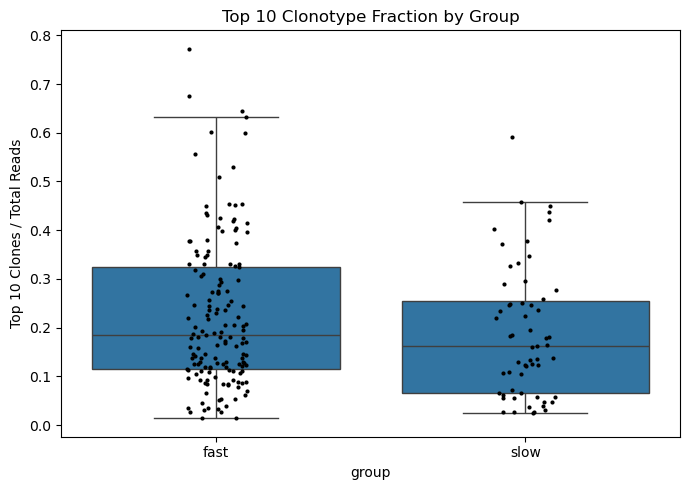

In [50]:
# Compute top-10 clone fraction per sample
top_n = 10
top10_df = (
    clonotype_df
    .sort_values(["Sample_ID", "readCount"], ascending=[True, False])
    .groupby("Sample_ID")
    .apply(lambda g: g["readCount"].head(top_n).sum() / g["readCount"].sum())
    .reset_index()
    .rename(columns={0: f"top{top_n}_fraction"})
)

# Merge with metadata
top10_df = top10_df.merge(meta_df, on="Sample_ID", how="left")
top10_df["group"] = top10_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# Plot
plt.figure(figsize=(7, 5))
sns.boxplot(data=top10_df, x="group", y=f"top{top_n}_fraction", showfliers=False)
sns.stripplot(data=top10_df, x="group", y=f"top{top_n}_fraction", color="black", size=3, jitter=True)
plt.title(f"Top {top_n} Clonotype Fraction by Group")
plt.ylabel(f"Top {top_n} Clones / Total Reads")
plt.tight_layout()
plt.show()

plot is normelized.

### Gini index

The Gini index measures inequality (Clonal inequality). In repertoire analysis:

0 = perfectly equal (all clonotypes have the same size)

1 = perfect inequality (all reads go to one clone) - More skewed repertoire

It captures clonal skew across the full distribution, not just top clones.



In [51]:
def gini(array):
    """Compute Gini index (inequality) of an array."""
    array = np.sort(array)
    n = len(array)
    cumulative = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n

# Apply to each sample
gini_df = (
    clonotype_df.groupby("Sample_ID")["readCount"]
    .apply(gini)
    .reset_index()
    .rename(columns={"readCount": "gini_index"})
)

# Add metadata
gini_df = gini_df.merge(meta_df, on="Sample_ID", how="left")
gini_df["group"] = gini_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")


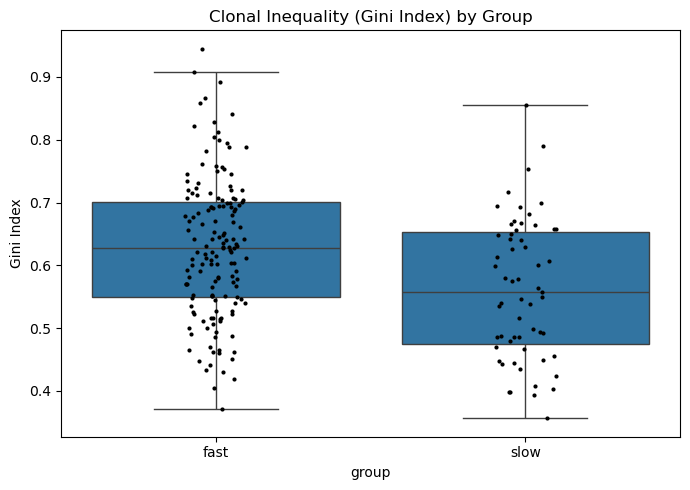

In [52]:
# Plot
plt.figure(figsize=(7, 5))
sns.boxplot(data=gini_df, x="group", y="gini_index", showfliers=False)
sns.stripplot(data=gini_df, x="group", y="gini_index", color="black", size=3, jitter=True)
plt.title("Clonal Inequality (Gini Index) by Group")
plt.ylabel("Gini Index")
plt.tight_layout()
plt.show()

### Clonal Evenness

This measures how evenly the reads are distributed across clones (Diversity normalized by richness).
High value means More uniform clone distribution.

It corrects Shannon entropy to account for how many clones there are — helps distinguish between:

Broad but skewed repertoires

Broad and even repertoires

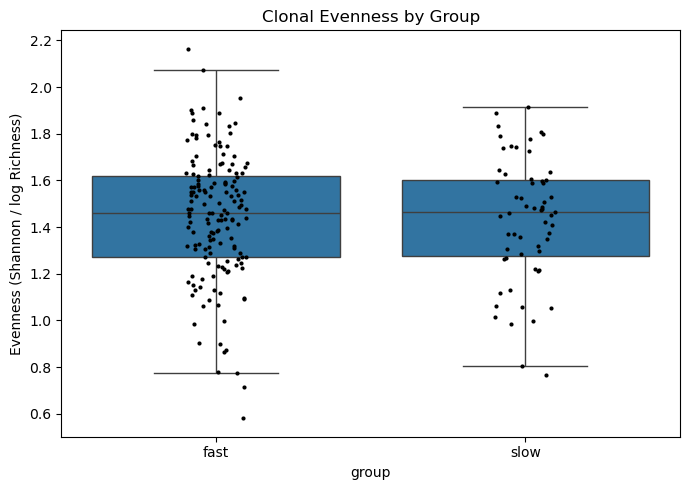

In [53]:
from scipy.stats import entropy

def compute_evenness(reads):
    total = reads.sum()
    proportions = reads / total
    shannon = entropy(proportions)
    richness = reads.nunique()
    return shannon / np.log(richness) if richness > 1 else 0

evenness_df = (
    clonotype_df.groupby("Sample_ID")["readCount"]
    .apply(compute_evenness)
    .reset_index()
    .rename(columns={"readCount": "evenness"})
)

# Merge with metadata
evenness_df = evenness_df.merge(meta_df, on="Sample_ID", how="left")
evenness_df["group"] = evenness_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# Plot
plt.figure(figsize=(7, 5))
sns.boxplot(data=evenness_df, x="group", y="evenness", showfliers=False)
sns.stripplot(data=evenness_df, x="group", y="evenness", color="black", size=3, jitter=True)
plt.title("Clonal Evenness by Group")
plt.ylabel("Evenness (Shannon / log Richness)")
plt.tight_layout()
plt.show()


In [55]:
print("Gini NaNs:\n", gini_df[["extraction_time", "gini_index"]].isna().sum())
print("Evenness NaNs:\n", evenness_df[["extraction_time", "evenness"]].isna().sum())
print("Top10 NaNs:\n", top10_df[["extraction_time", "top10_fraction"]].isna().sum())


Gini NaNs:
 extraction_time    1
gini_index         0
dtype: int64
Evenness NaNs:
 extraction_time    1
evenness           0
dtype: int64
Top10 NaNs:
 extraction_time    1
top10_fraction     0
dtype: int64


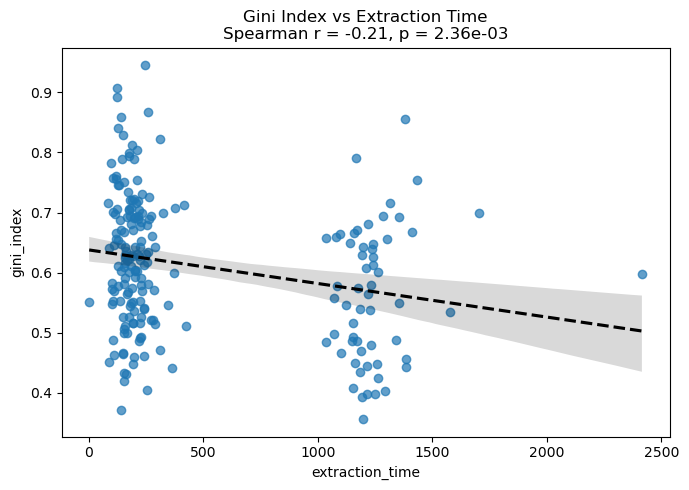

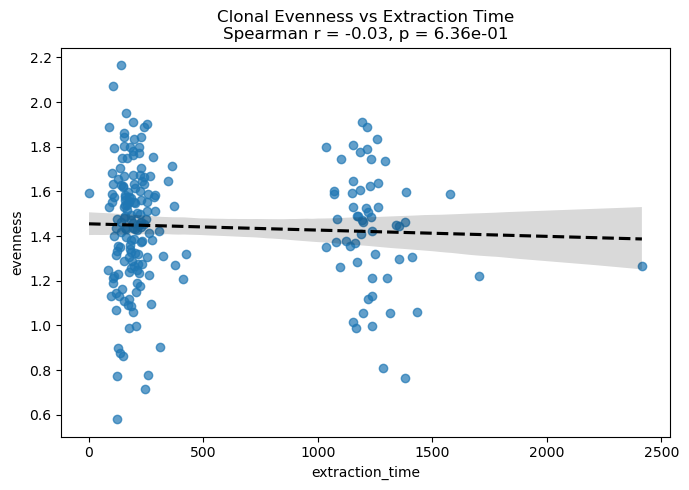

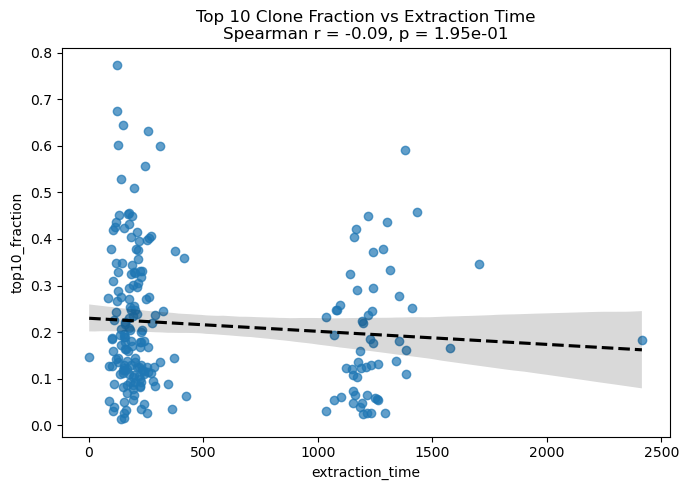

In [56]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(df, x, y, title):
    df_clean = df[[x, y]].dropna()
    if df_clean[y].nunique() <= 1:
        print(f"Cannot compute correlation for {title}: target is constant.")
        return

    r, p = spearmanr(df_clean[x], df_clean[y])
    plt.figure(figsize=(7, 5))
    sns.regplot(data=df_clean, x=x, y=y, scatter_kws={'alpha': 0.7}, line_kws={'color': 'black', 'linestyle': 'dashed'})
    plt.title(f"{title}\nSpearman r = {r:.2f}, p = {p:.2e}")
    plt.tight_layout()
    plt.show()

# Correlate Gini index
plot_correlation(gini_df, x="extraction_time", y="gini_index", title="Gini Index vs Extraction Time")

# Correlate Evenness
plot_correlation(evenness_df, x="extraction_time", y="evenness", title="Clonal Evenness vs Extraction Time")

# Correlate Top 10 Clone Fraction
plot_correlation(top10_df, x="extraction_time", y="top10_fraction", title="Top 10 Clone Fraction vs Extraction Time")


### Simpson diversity

Emphasizes common clones — penalizes dominance.
The Simpson diversity index measures the probability that two randomly chosen reads belong to different clonotypes.

Closer to 1 → High diversity, many clones with similar frequencies.

Closer to 0 → Low diversity, few dominant clones.

It emphasizes dominant clones more heavily than Shannon entropy.

In [58]:
# Add Simpson diversity to existing adata objects
ir.tl.alpha_diversity(fast_adata, groupby="sample_id", target_col="junction_aa", metric="simpson")
ir.tl.alpha_diversity(slow_adata, groupby="sample_id", target_col="junction_aa", metric="simpson")


In [60]:
# Extract and merge
fast_simpson = (
    fast_adata.obs.groupby("sample_id")
    .agg({"simpson_junction_aa": "mean", "extraction_time": "first"})
    .reset_index()
)
fast_simpson["group"] = "fast"

slow_simpson = (
    slow_adata.obs.groupby("sample_id")
    .agg({"simpson_junction_aa": "mean", "extraction_time": "first"})
    .reset_index()
)
slow_simpson["group"] = "slow"

simpson_df = pd.concat([fast_simpson, slow_simpson], ignore_index=True)
simpson_df = simpson_df.rename(columns={"simpson_junction_aa": "simpson_diversity"})


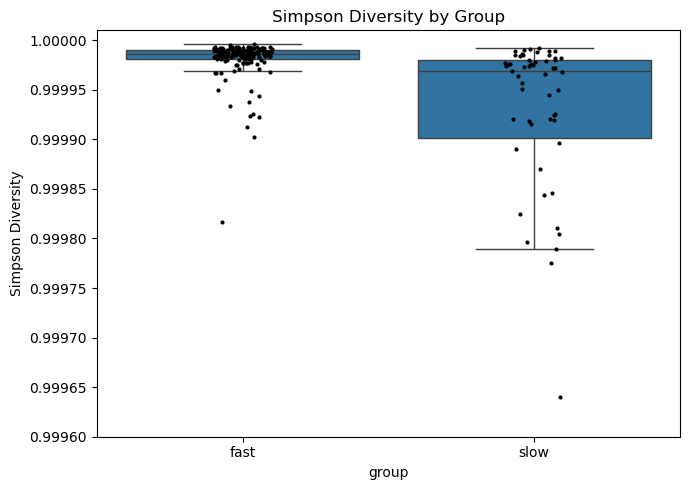

In [67]:
# Plot
plt.figure(figsize=(7, 5))
sns.boxplot(data=simpson_df, x="group", y="simpson_diversity", showfliers=False)
sns.stripplot(data=simpson_df, x="group", y="simpson_diversity", color="black", size=3, jitter=True)
plt.ylim(0.9996, 1.00001)
plt.ylabel("Simpson Diversity")
plt.title("Simpson Diversity by Group")
plt.tight_layout()
plt.show()


## Subsampling samples to compare clonotypes depth

Plot number of unique clonotypes discovered as a function of the number of reads sampled (subsampling).
Shows whether diversity is saturated or still increasing — i.e., if the sample was deeply sequenced enough.

Why it’s useful:

Helps control for differences in sequencing depth.

Can reveal repertoire complexity differences that are masked at fixed depths.

In [70]:
min_reads = clonotype_df.groupby("Sample_ID")["readCount"].sum().min()
print(f"Lowest total read count among samples: {min_reads}")

Lowest total read count among samples: 209378.0


In [72]:
max_depth = clonotype_df.groupby("Sample_ID")["readCount"].sum().min()
depths = np.arange(10000, int(max_depth // 10000) * 10000 + 1, 20000)
rarefaction_curves = []

# For each sample
for sample_id, group_df in clonotype_df.groupby("Sample_ID"):
    total_reads = group_df["readCount"].sum()
    if total_reads < depths[0]:
        print(f"skipping samples: {sample_id} due to low-depth.")
        continue  # Skip low-depth samples

    # Expand readCount into actual sequence list
    sequences = []
    for _, row in group_df.iterrows():
        sequences.extend([row["aaSeqCDR3"]] * int(row["readCount"]))
    sequences = np.array(sequences)

    for depth in depths:
        if len(sequences) < depth:
            continue
        subsampled = np.random.choice(sequences, size=depth, replace=False)
        unique_clonotypes = len(set(subsampled))
        extraction_time = meta_df.loc[meta_df["Sample_ID"] == sample_id, "extraction_time"].values[0]
        group = "fast" if extraction_time <= time_threshold else "slow"
        
        rarefaction_curves.append({
            "Sample_ID": sample_id,
            "depth": depth,
            "unique_clonotypes": unique_clonotypes,
            "group": group
        })

# Convert to DataFrame
rarefaction_df = pd.DataFrame(rarefaction_curves)

/tmp/ipykernel_515560/1663985684.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=rarefaction_df, x="depth", y="unique_clonotypes", hue="group", estimator="mean", ci="sd")


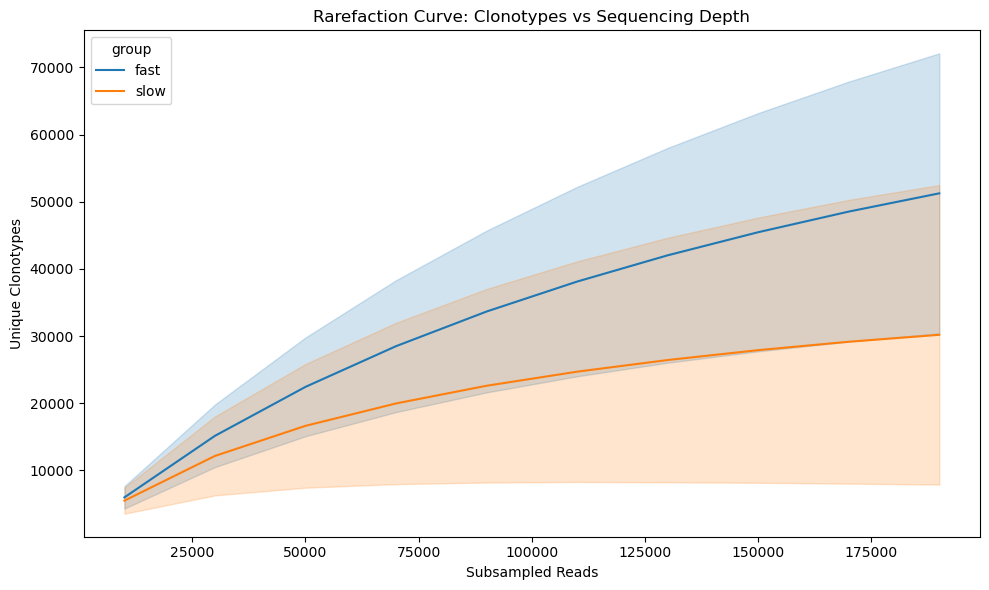

In [73]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=rarefaction_df, x="depth", y="unique_clonotypes", hue="group", estimator="mean", ci="sd")
plt.title("Rarefaction Curve: Clonotypes vs Sequencing Depth")
plt.xlabel("Subsampled Reads")
plt.ylabel("Unique Clonotypes")
plt.tight_layout()
plt.show()

We can see steeper unique clonotype growth in fast group.
since we downsamples samples to the same number of reads, we can infer that The fast group discovers more unique clonotypes per read at every depth.

This means their diversity is truly higher, not just an artifact of deeper sequencing.

If raw read count were the only factor, we wouldn’t see a consistent difference at the same subsampled depths.

2 fast groups samples had 25000 singletone values (hugh outliners) so we adjusted ylim to 2000.

Notice that readcount is not normelized.

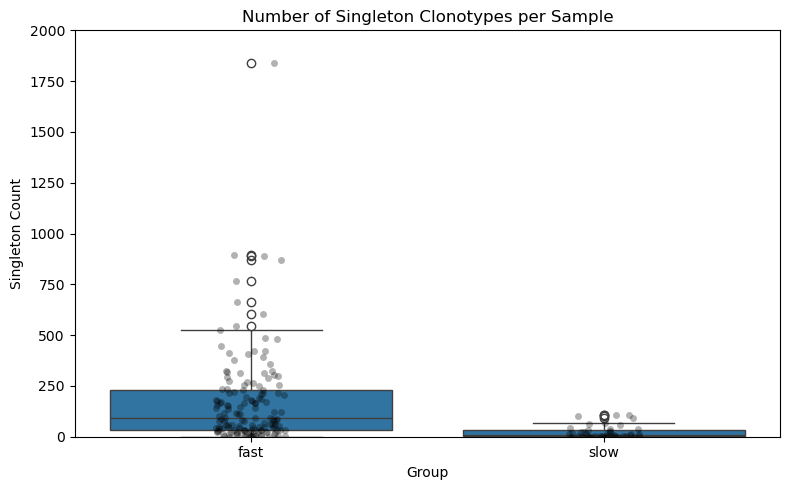

In [80]:
# Count singletons per sample
singleton_counts = (
    clonotype_df[clonotype_df["readCount"] == 1]
    .groupby("Sample_ID")["aaSeqCDR3"]
    .count()
    .reset_index()
    .rename(columns={"aaSeqCDR3": "singleton_count"})
)

# Merge with metadata
singleton_counts = singleton_counts.merge(meta_df, on="Sample_ID", how="left")
singleton_counts["group"] = singleton_counts["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=singleton_counts, x="group", y="singleton_count")
sns.stripplot(data=singleton_counts, x="group", y="singleton_count", color="black", alpha=0.3)
plt.title("Number of Singleton Clonotypes per Sample")
plt.ylabel("Singleton Count")
plt.xlabel("Group")
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()


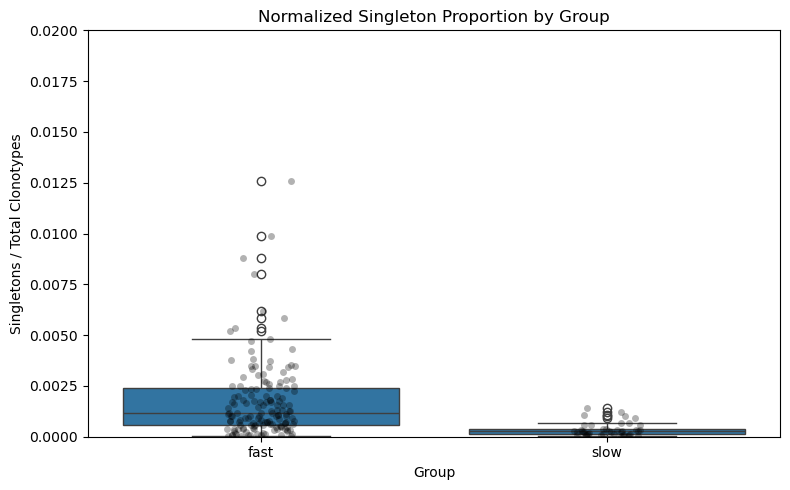

In [82]:
# 1. Count singletons
singleton_counts = (
    clonotype_df[clonotype_df["readCount"] == 1]
    .groupby("Sample_ID")["aaSeqCDR3"]
    .count()
    .reset_index()
    .rename(columns={"aaSeqCDR3": "singleton_count"})
)

# 2. Total clonotypes per sample
total_clonotypes = (
    clonotype_df.groupby("Sample_ID")["aaSeqCDR3"]
    .nunique()
    .reset_index()
    .rename(columns={"aaSeqCDR3": "total_clonotypes"})
)

# 3. Merge and normalize
singleton_df = singleton_counts.merge(total_clonotypes, on="Sample_ID", how="inner")
singleton_df["singleton_proportion"] = singleton_df["singleton_count"] / singleton_df["total_clonotypes"]

# 4. Add metadata
singleton_df = singleton_df.merge(meta_df, on="Sample_ID", how="left")
singleton_df["group"] = singleton_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# 5. Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=singleton_df, x="group", y="singleton_proportion")
sns.stripplot(data=singleton_df, x="group", y="singleton_proportion", color="black", alpha=0.3)
plt.title("Normalized Singleton Proportion by Group")
plt.ylabel("Singletons / Total Clonotypes")
plt.xlabel("Group")
plt.ylim(0, 0.02)
plt.tight_layout()
plt.show()


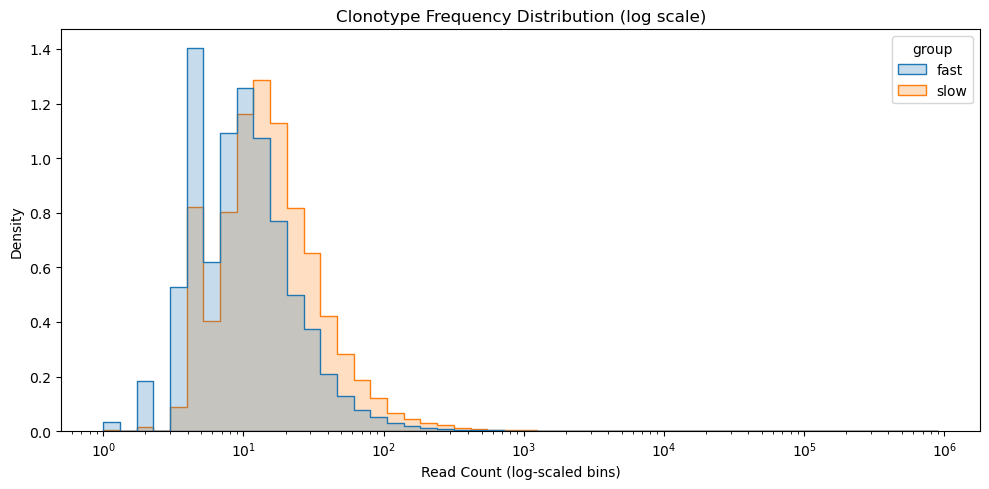

In [77]:
# Group-wide frequency histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=clonotype_df, x="readCount", hue="group", log_scale=(True, False), bins=50, element="step", stat="density", common_norm=False)
plt.title("Clonotype Frequency Distribution (log scale)")
plt.xlabel("Read Count (log-scaled bins)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


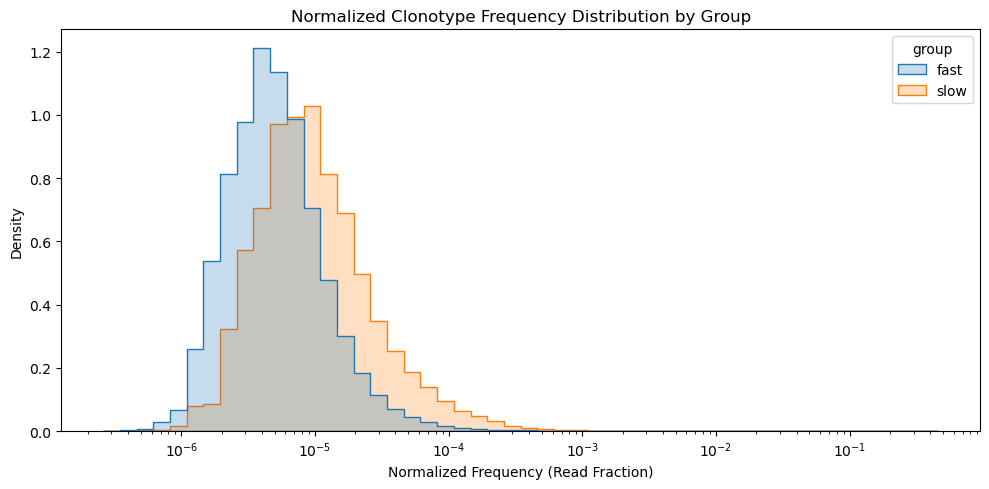

In [83]:
# 1. Normalize clonotype frequencies per sample
clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

normalized_clones = []
for sample_id, group in clonotype_df.groupby("Sample_ID"):
    total_reads = group["readCount"].sum()
    norm_df = group.copy()
    norm_df["norm_freq"] = norm_df["readCount"] / total_reads
    normalized_clones.append(norm_df)

clones_df = pd.concat(normalized_clones, ignore_index=True)

# 2. Plot histogram (log-scaled bins for clarity)
plt.figure(figsize=(10, 5))
sns.histplot(
    data=clones_df,
    x="norm_freq",
    hue="group",
    log_scale=(True, False),
    bins=50,
    element="step",
    stat="density",
    common_norm=False
)
plt.title("Normalized Clonotype Frequency Distribution by Group")
plt.xlabel("Normalized Frequency (Read Fraction)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


###  Clonal Size Distribution Binning

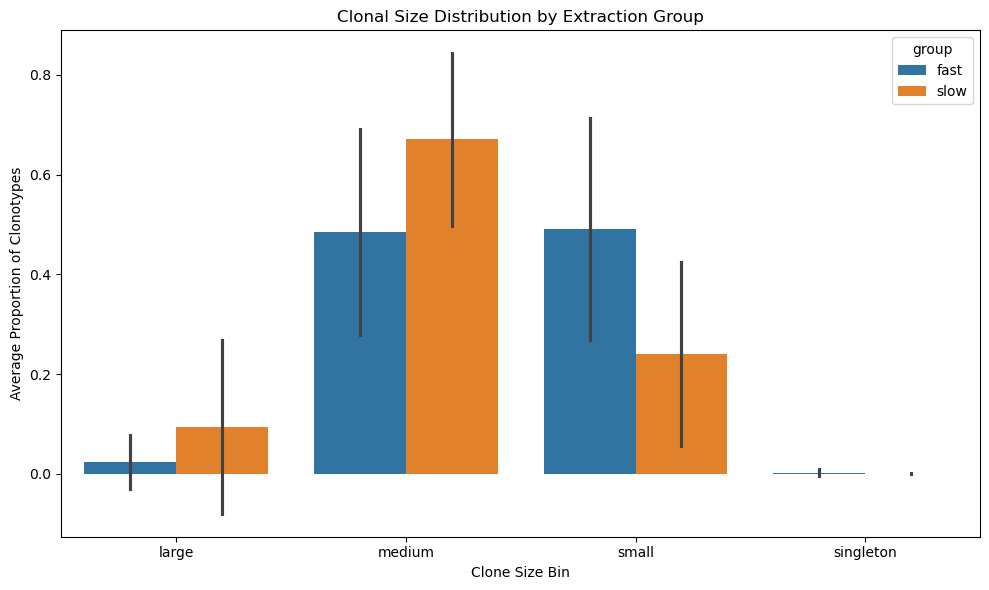

In [ ]:
# 1. Merge metadata for group assignment
clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="left")
clonotype_df["group"] = clonotype_df["extraction_time_x"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# 2. Define binning function
def classify_clone_size(read_count):
    if read_count == 1:
        return "singleton"
    elif 2 <= read_count <= 10:
        return "small"
    elif 11 <= read_count <= 100:
        return "medium"
    else:
        return "large"

clonotype_df["size_bin"] = clonotype_df["readCount"].apply(classify_clone_size)

# 3. Compute per-sample bin proportions
bin_counts = (
    clonotype_df.groupby(["Sample_ID", "size_bin"])["aaSeqCDR3"]
    .count()
    .reset_index()
    .rename(columns={"aaSeqCDR3": "count"})
)

# Add total counts per sample
total_counts = (
    bin_counts.groupby("Sample_ID")["count"]
    .sum()
    .reset_index()
    .rename(columns={"count": "total"})
)
bin_counts = bin_counts.merge(total_counts, on="Sample_ID")
# proportion for normalization
bin_counts["proportion"] = bin_counts["count"] / bin_counts["total"]

# Add group info
bin_counts = bin_counts.merge(meta_df, on="Sample_ID")
bin_counts["group"] = bin_counts["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# 4. Plot average distribution by group
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bin_counts,
    x="size_bin",
    y="proportion",
    hue="group",
    estimator="mean",
    errorbar="sd"
)
plt.title("Clonal Size Distribution by Extraction Group")
plt.ylabel("Average Proportion of Clonotypes")
plt.xlabel("Clone Size Bin")
plt.tight_layout()
plt.show()

# Instance Hardness corolation

analyzing whether hardness of a sample is related to its extraction time.

In [38]:
hardness_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon_hardness_rf_cos_every5_new_mixcr.csv")
hardness_old_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon_hardness_rf_cos_every5_old_mixcr.csv")

In [39]:
# --- Create a clean 'Sample_ID' in hardness_df ---
hardness_df["Sample_ID"] = hardness_df["sample_name"].apply(lambda x: x.split("_")[0])

# --- Merge meta_df and hardness_df on Sample_ID ---
merged_df = meta_df.merge(
    hardness_df[["Sample_ID", "appearance_rate"]],
    on="Sample_ID",
    how="inner"  # inner join ensures only matching samples are kept
)

# --- Report missing samples ---
missing_in_meta = set(hardness_df["Sample_ID"]) - set(meta_df["Sample_ID"])
missing_in_hardness = set(meta_df["Sample_ID"]) - set(hardness_df["Sample_ID"])

print(f"Samples missing from meta_df (extraction_time): {list(missing_in_meta)}")
print(f"Samples missing from hardness_df (appearance_rate): {list(missing_in_hardness)}")



Samples missing from meta_df (extraction_time): []
Samples missing from hardness_df (appearance_rate): ['P1-S14', 'P6-S15', 'P2-S1', 'P6-S12', 'P5-S20', 'P9-S18', 'P3-S16', 'P9-S8', 'P5-S14', 'P6-S1', 'P1-S4', 'P9-S20', 'P1-S24', 'P4-S14', 'P2-S8', 'P1-S1', 'P6-S6', 'P6-S7', 'P8-S18', 'P2-S6', 'P7-S22', 'P6-S2', 'P6-S9', 'P2-S2', 'P9-S17', 'P4-S20', 'P5-S19', 'P9-S22', 'P1-S20', 'P4-S18', 'P5-S23', 'P5-S7', 'P6-S21', 'P7-S10', 'P2-S19', 'P2-S12', 'P4-S15', 'P3-S22', 'P8-S16', 'P4-S3', 'P4-S21', 'P2-S3', 'P1-S17', 'P7-S21', 'P9-S6', 'P6-S22', 'P6-S20', 'P2-S17', 'P2-S21', 'P5-S3', 'P8-S6', 'P1-S15', 'P3-S3', 'P8-S13', 'P3-S2', 'P2-S14', 'P2-S22', 'P8-S17', 'P2-S9', 'P3-S11', 'P7-S9', 'P4-S4', 'P9-S24', 'P9-S9', 'P2-S11', 'P4-S2', 'P1-S10', 'P6-S17', 'P9-S15']


Dropped P4-S1 as there is no extraction time available.
Note that only valid percentiles samples (after downsampling and choosing only annotation-valid samples) there should be 146 samples.

In [40]:
# Drop samples with missing extraction_time or appearance_rate
clean_df = merged_df.dropna(subset=["extraction_time", "appearance_rate"])

# Now compute Pearson correlation
from scipy.stats import pearsonr

correlation, p_value = pearsonr(
    clean_df["extraction_time"],
    clean_df["appearance_rate"]
)

print(f"\nPearson correlation: {correlation:.3f}")
print(f"P-value: {p_value:.3g}")



Pearson correlation: 0.158
P-value: 0.0564


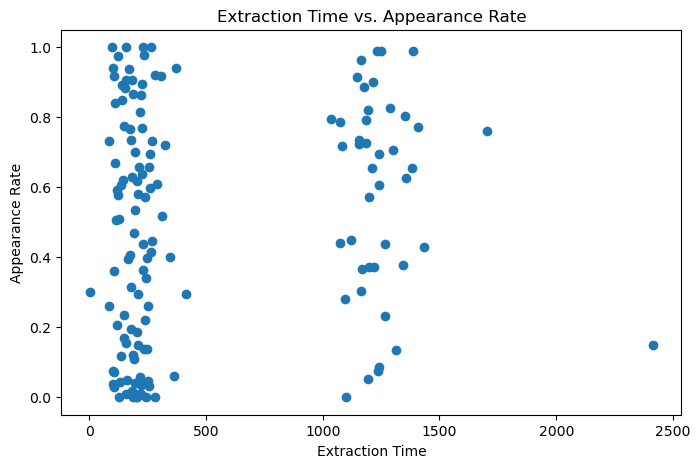

In [44]:

plt.figure(figsize=(8, 5))  # Optional: adjust figure size

plt.scatter(clean_df['extraction_time'], clean_df['appearance_rate'])  # Line plot with markers
plt.xlabel("Extraction Time")  # Label x-axis
plt.ylabel("Appearance Rate")  # Label y-axis
plt.title("Extraction Time vs. Appearance Rate")  # Add a title

plt.show()


In [41]:
print("Extraction time variance:", merged_df["extraction_time"].var())
print("Appearance rate variance:", merged_df["appearance_rate"].var())

print(merged_df.isna().sum())
print(merged_df.shape)
print(merged_df[["extraction_time", "appearance_rate"]].dropna().shape)


Extraction time variance: 253638.49957487013
Appearance rate variance: 0.10881097520408436
Sample_ID          0
extraction_time    1
appearance_rate    0
dtype: int64
(147, 3)
(146, 2)


Matched 134 samples between old and new hardness datasets.


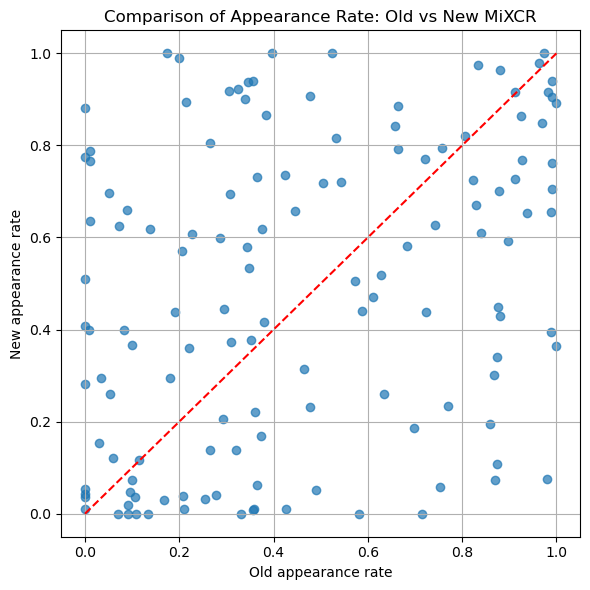

In [19]:
import re

# --- Extract Sample_ID from hardness_df (new) ---
def extract_sample_id_new(name):
    match = re.match(r'(P\d+-S\d+)', name)
    if match:
        return match.group(1)
    else:
        return None

hardness_df["Sample_ID"] = hardness_df["sample_name"].apply(extract_sample_id_new)

# --- Extract Sample_ID from hardness_old_df (old) ---
def extract_sample_id_old(name):
    match = re.match(r'pool(\d+)_S(\d+)', name)
    if match:
        pool, sample = match.groups()
        return f"P{pool}-S{sample}"
    else:
        return None

hardness_old_df["Sample_ID"] = hardness_old_df["sample_name"].apply(extract_sample_id_old)

# --- Merge old and new by Sample_ID ---
merged_hardness = hardness_df[["Sample_ID", "appearance_rate"]].rename(columns={"appearance_rate": "new_appearance_rate"}).merge(
    hardness_old_df[["Sample_ID", "appearance_rate"]].rename(columns={"appearance_rate": "old_appearance_rate"}),
    on="Sample_ID",
    how="inner"
)

print(f"Matched {len(merged_hardness)} samples between old and new hardness datasets.")

# --- Quick scatter plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(
    merged_hardness["old_appearance_rate"],
    merged_hardness["new_appearance_rate"],
    alpha=0.7
)
plt.plot([0,1], [0,1], color='red', linestyle='--')  # y=x line
plt.xlabel("Old appearance rate")
plt.ylabel("New appearance rate")
plt.title("Comparison of Appearance Rate: Old vs New MiXCR")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
#  Correlation
from scipy.stats import pearsonr

correlation, p_value = pearsonr(
    merged_hardness["old_appearance_rate"],
    merged_hardness["new_appearance_rate"]
)

print(f"\nPearson correlation between old and new appearance rates: {correlation:.3f}")
print(f"P-value: {p_value:.3g}")



Pearson correlation between old and new appearance rates: 0.330
P-value: 9.84e-05


Why some samples got "easier" and some got "harder"? i expected samples to follow some sort of corrolation.

Number of samples that got harder: 68
Number of samples that got easier: 66


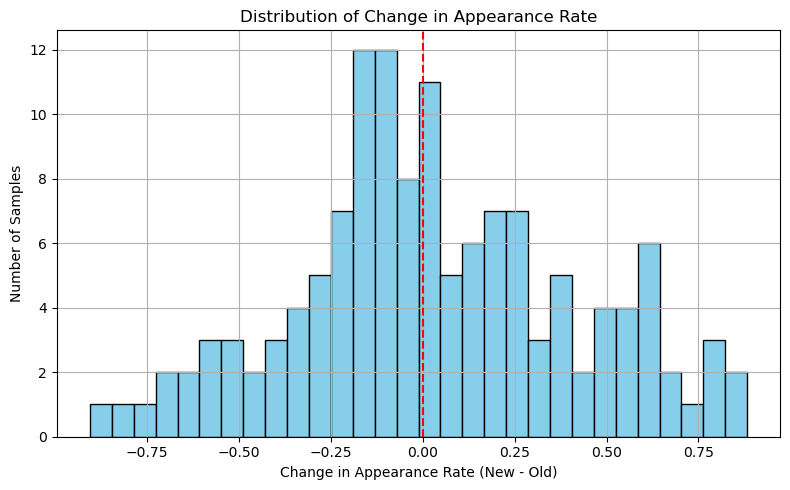

In [21]:
merged_hardness["delta"] = merged_hardness["new_appearance_rate"] - merged_hardness["old_appearance_rate"]

num_harder = (merged_hardness["delta"] > 0).sum()
num_easier = (merged_hardness["delta"] < 0).sum()

print(f"Number of samples that got harder: {num_harder}")
print(f"Number of samples that got easier: {num_easier}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(merged_hardness["delta"], bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Change in Appearance Rate (New - Old)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Change in Appearance Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


lets try to generate more stats about each sample, for later use in the old/new mixcr comparrison.

In [22]:
import os
import pandas as pd
from scipy.stats import entropy

# --- Paths ---
new_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/downsamples_209378/original_data/"
old_dir = "/dsi/sbm/or/for_sol/downsampled/TRB/"

# --- Load NEW MiXCR downsampled data ---
new_sample_stats = []

for fname in os.listdir(new_dir):
    if fname.endswith(".csv"):
        sample_id = fname.split("_")[0]
        
        df = pd.read_csv(os.path.join(new_dir, fname))

        total_reads = df["readCount"].sum()
        num_clonotypes = df["Sequences"].nunique()
        shannon_entropy = entropy(df["readFraction"])  # <--- USE readFraction here
        top_clone_freq = df["readFraction"].max()      # <--- can also use readFraction for top clone

        new_sample_stats.append({
            "Sample_ID": sample_id,
            "total_reads_new": total_reads,
            "num_clonotypes_new": num_clonotypes,
            "entropy_new": shannon_entropy,
            "dominance_new": top_clone_freq
        })

new_stats_df = pd.DataFrame(new_sample_stats)

# --- Load OLD MiXCR downsampled data ---
old_sample_stats = []

for fname in os.listdir(old_dir):
    if fname.endswith(".txt"):
        # Example filename: pool6_S7_TRB_mig_cdr3_clones_all.txt
        parts = fname.split("_")
        pool_number = parts[0].replace("pool", "")  # e.g., pool6 -> 6
        sample_number = parts[1].replace("S", "")  # e.g., S7 -> 7
        sample_id = f"P{pool_number}-S{sample_number}"
        
        df = pd.read_csv(os.path.join(old_dir, fname), sep="\t")
        
        if "CDR3.aa" in df.columns:
            num_clonotypes = df["CDR3.aa"].nunique()
        else:
            print(f"CDR3 column wasn't found in {fname}")
            continue  # Skip bad files
        
        old_sample_stats.append({
            "Sample_ID": sample_id,
            "num_clonotypes_old": num_clonotypes
        })

old_stats_df = pd.DataFrame(old_sample_stats)


In [23]:
# Merge
sample_stats_combined = pd.merge(new_stats_df, old_stats_df, on="Sample_ID", how="inner")

# Normalize only for new MiXCR
sample_stats_combined["clonotypes_per_read_new"] = sample_stats_combined["num_clonotypes_new"] / sample_stats_combined["total_reads_new"]

# (no normalization for old samples)


In [24]:
sample_stats_combined.head()

Sample_ID  total_reads_new  num_clonotypes_new  entropy_new  dominance_new  \
0     P6-S9           209378               57858     9.763235       0.016219   
1     P7-S4           209378               12373     8.413001       0.023512   
2    P6-S11           209378               50701     9.753357       0.024281   
3    P3-S20           209378               66071     9.500813       0.030314   
4    P9-S12           209378               74690     8.821892       0.151334   

   num_clonotypes_old  clonotypes_per_read_new  
0               13880                 0.276333  
1               11376                 0.059094  
2               15082                 0.242151  
3               13501                 0.315558  
4               13218                 0.356723

Final dataset has 134 matched samples.
Correlation between hardness change (delta) and num_clonotypes_old: -0.122 (p=0.16)
Correlation between hardness change (delta) and num_clonotypes_new: -0.076 (p=0.383)
Correlation between hardness change (delta) and clonotypes_per_read_new: -0.076 (p=0.383)
Correlation between hardness change (delta) and entropy_new: -0.103 (p=0.235)
Correlation between hardness change (delta) and dominance_new: 0.067 (p=0.44)


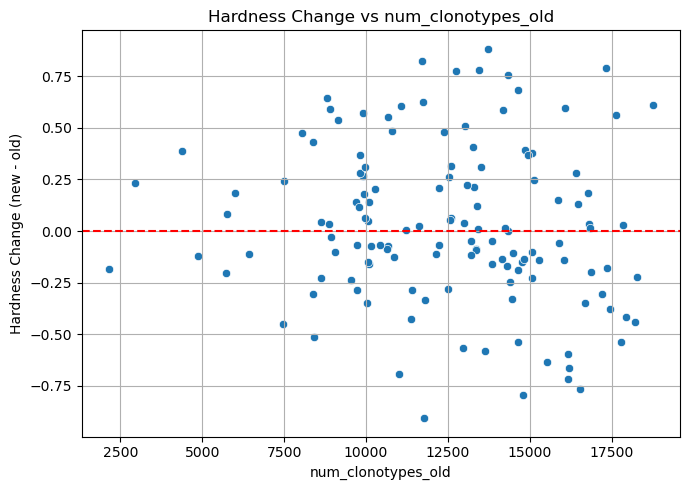

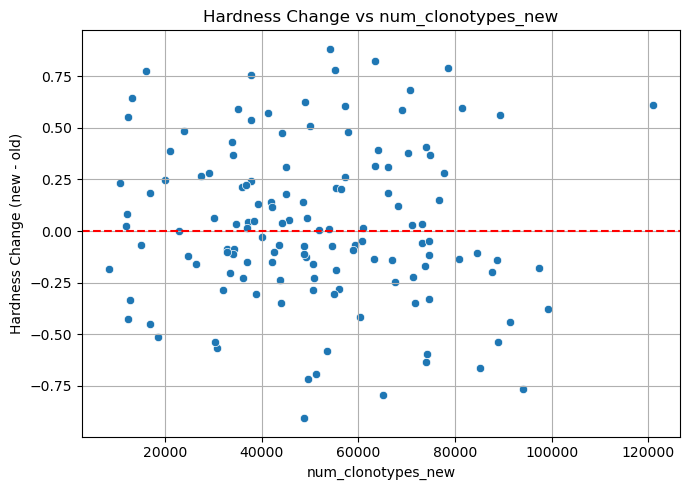

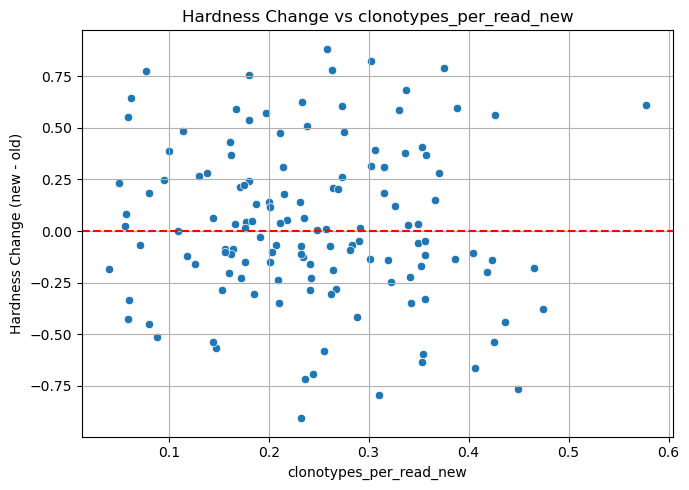

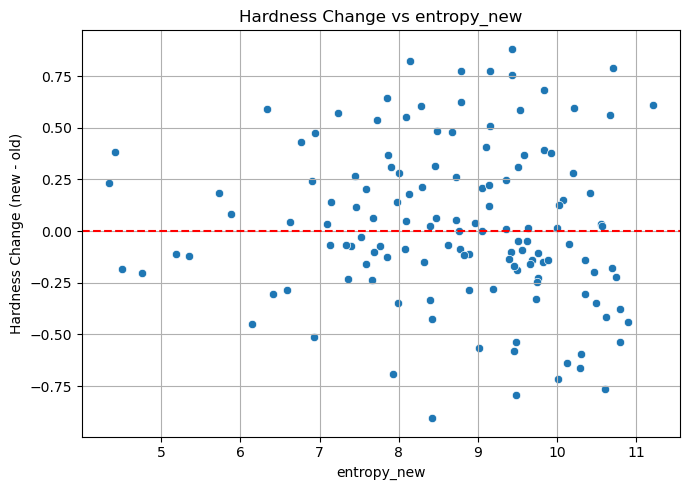

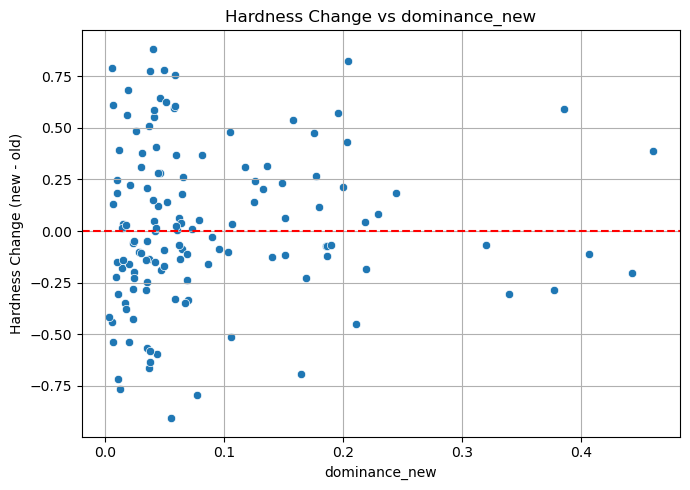

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# --- Step 1: Merge stats with hardness change ---
full_data = merged_hardness.merge(sample_stats_combined, on="Sample_ID", how="inner")

# Calculate hardness delta
full_data["delta"] = full_data["new_appearance_rate"] - full_data["old_appearance_rate"]

print(f"Final dataset has {full_data.shape[0]} matched samples.")

# --- Step 2: Features to test ---
features = ["num_clonotypes_old", "num_clonotypes_new", "clonotypes_per_read_new", "entropy_new", "dominance_new"]

# --- Step 3: Analyze correlations ---
for feature in features:
    corr, pval = pearsonr(full_data["delta"], full_data[feature])
    print(f"Correlation between hardness change (delta) and {feature}: {corr:.3f} (p={pval:.3g})")

# --- Step 4: Plotting ---
for feature in features:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=feature, y="delta", data=full_data)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"Hardness Change vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Hardness Change (new - old)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


R² score (proportion of hardness change explained): 0.021

Feature Coefficients:
                   Feature   Coefficient
0       num_clonotypes_old -6.742424e-05
1       num_clonotypes_new -3.857266e-07
2  clonotypes_per_read_new -1.841773e-12
3              entropy_new  1.521049e-01
4            dominance_new  4.702402e-01


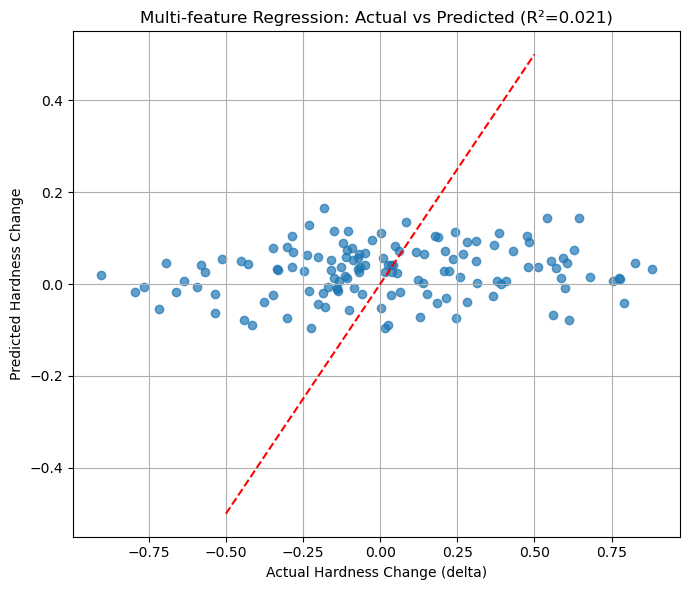

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Features to use
X = full_data[["num_clonotypes_old", "num_clonotypes_new", "clonotypes_per_read_new", "entropy_new", "dominance_new"]]
y = full_data["delta"]

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# R2 score
r2 = r2_score(y, y_pred)
print(f"R² score (proportion of hardness change explained): {r2:.3f}")

# Coefficients
coef_table = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
})
print("\nFeature Coefficients:")
print(coef_table)

# Scatter plot: real vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([-0.5, 0.5], [-0.5, 0.5], color="red", linestyle="--")
plt.xlabel("Actual Hardness Change (delta)")
plt.ylabel("Predicted Hardness Change")
plt.title(f"Multi-feature Regression: Actual vs Predicted (R²={r2:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
from itertools import combinations

# Features
feature_list = ["num_clonotypes_old", "num_clonotypes_new", "clonotypes_per_read_new", "entropy_new", "dominance_new"]

# Store results
results = []

# Try all 2-feature combinations
for combo in combinations(feature_list, 2):
    X = full_data[list(combo)]
    y = full_data["delta"]
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    r2 = r2_score(y, y_pred)
    
    results.append({
        "Feature 1": combo[0],
        "Feature 2": combo[1],
        "R2 Score": r2
    })

# Show sorted results
results_df = pd.DataFrame(results).sort_values("R2 Score", ascending=False)
print(results_df)


                 Feature 1                Feature 2  R2 Score
2       num_clonotypes_old              entropy_new  0.019558
3       num_clonotypes_old            dominance_new  0.015693
1       num_clonotypes_old  clonotypes_per_read_new  0.015150
0       num_clonotypes_old       num_clonotypes_new  0.015150
9              entropy_new            dominance_new  0.011640
7  clonotypes_per_read_new              entropy_new  0.010693
5       num_clonotypes_new              entropy_new  0.010693
6       num_clonotypes_new            dominance_new  0.007400
8  clonotypes_per_read_new            dominance_new  0.007400
4       num_clonotypes_new  clonotypes_per_read_new  0.005763


# Inspecting Clonotypes difference

In [28]:
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# --- Paths ---
new_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/downsamples_209378/original_data/"
old_dir = "/dsi/sbm/or/for_sol/downsampled/TRB/"

# --- Load clonotypes from NEW MiXCR ---
new_clonotypes = {}

for fname in os.listdir(new_dir):
    if fname.endswith(".csv"):
        sample_id = fname.split("_")[0]  # e.g., P6-S7
        df = pd.read_csv(os.path.join(new_dir, fname))
        clonotypes = set(df["Sequences"].dropna())
        new_clonotypes[sample_id] = clonotypes

# --- Load clonotypes from OLD MiXCR ---
old_clonotypes = {}

for fname in os.listdir(old_dir):
    if fname.endswith(".txt"):
        parts = fname.split("_")
        pool_number = parts[0].replace("pool", "")
        sample_number = parts[1].replace("S", "")
        sample_id = f"P{pool_number}-S{sample_number}"
        
        df = pd.read_csv(os.path.join(old_dir, fname), sep="\t")
        
        if "CDR3.aa" in df.columns:
            clonotypes = set(df["CDR3.aa"].dropna())
            old_clonotypes[sample_id] = clonotypes

# --- Compute species change metrics per sample ---
species_change_metrics = []

# Only analyze samples that exist in both
common_samples = set(old_clonotypes.keys()).intersection(new_clonotypes.keys())

for sample_id in common_samples:
    old_set = old_clonotypes[sample_id]
    new_set = new_clonotypes[sample_id]
    
    lost = len(old_set - new_set)
    gained = len(new_set - old_set)
    intersection = len(old_set.intersection(new_set))
    union = len(old_set.union(new_set))
    
    jaccard = intersection / union if union > 0 else np.nan
    
    species_change_metrics.append({
        "Sample_ID": sample_id,
        "num_lost_clonotypes": lost,
        "num_gained_clonotypes": gained,
        "jaccard_index": jaccard
    })

species_change_df = pd.DataFrame(species_change_metrics)

# --- Merge with full_data (containing hardness delta) ---
full_data_with_species = full_data.merge(species_change_df, on="Sample_ID", how="inner")


Correlation between hardness change (delta) and num_lost_clonotypes: -0.044 (p=0.618)
Correlation between hardness change (delta) and num_gained_clonotypes: -0.063 (p=0.472)
Correlation between hardness change (delta) and jaccard_index: 0.020 (p=0.82)


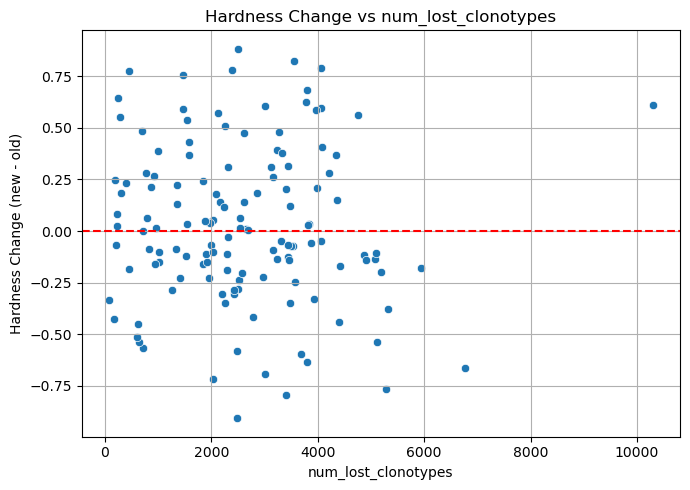

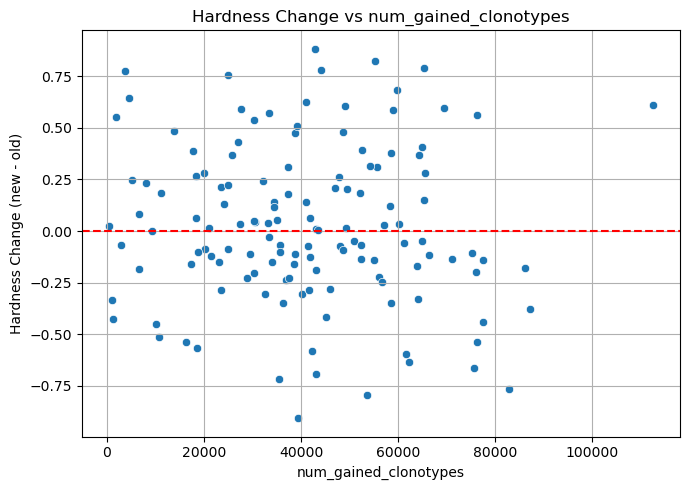

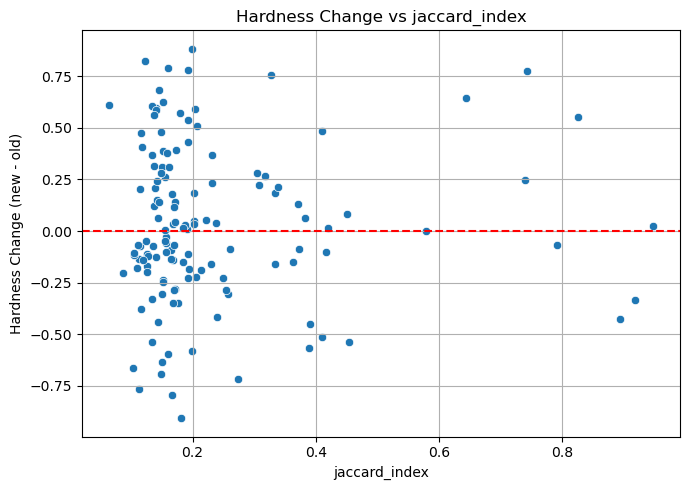

In [29]:
# --- Correlate new features with hardness delta ---
for feature in ["num_lost_clonotypes", "num_gained_clonotypes", "jaccard_index"]:
    corr, pval = pearsonr(full_data_with_species["delta"], full_data_with_species[feature])
    print(f"Correlation between hardness change (delta) and {feature}: {corr:.3f} (p={pval:.3g})")

# --- Plotting ---
for feature in ["num_lost_clonotypes", "num_gained_clonotypes", "jaccard_index"]:
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=feature, y="delta", data=full_data_with_species)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"Hardness Change vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Hardness Change (new - old)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# SCIRPY

In [30]:
import scirpy as ir
import pandas as pd
import anndata as ad

Now we'll load the data into scirpy format. We will also set a dummy "c_call" column, as scirpy demands, but it should not interfere with our analysis(as it affects function regarding chain comparisson, that we will not use).

In [31]:
# --- Flatten new clonotypes ---
new_entries = []
for sample_id, seqs in new_clonotypes.items():
    for seq in seqs:
        new_entries.append({
            "cell_id": sample_id,
            "chain": "TRB",  # assuming TRB
            "cdr3": seq,
            "c_call": "TRBC1"  # dummy constant region
        })
new_df = pd.DataFrame(new_entries)

# --- Flatten old clonotypes ---
old_entries = []
for sample_id, seqs in old_clonotypes.items():
    for seq in seqs:
        old_entries.append({
            "cell_id": sample_id,
            "chain": "TRB",
            "cdr3": seq,
            "c_call": "TRBC1"
        })
old_df = pd.DataFrame(old_entries)


In [32]:
new_adata = ir.io.read_airr(new_df, airr_mod="minimal", index_column="cell_id", validate=False)
old_adata = ir.io.read_airr(old_df, airr_mod="minimal", index_column="cell_id", validate=False)


KeyboardInterrupt: 